# **Question 2a**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Your file paths
files = [
    "/Users/eshansharif/Documents/st239/Assignment-20250310/Question2-20250311/Dataset_1.csv",
    "/Users/eshansharif/Documents/st239/Assignment-20250310/Question2-20250311/Dataset_2.csv",
    "/Users/eshansharif/Documents/st239/Assignment-20250310/Question2-20250311/Dataset_3.csv",
    "/Users/eshansharif/Documents/st239/Assignment-20250310/Question2-20250311/Dataset_4.csv",
    "/Users/eshansharif/Documents/st239/Assignment-20250310/Question2-20250311/Dataset_5.csv"
]

# Function to load and clean datasets
def load_cleaned_data(file_path):
    def clean_lines(file_path):
        with open(file_path, "r") as f:
            for line in f:
                if line.strip():
                    yield line
    return np.loadtxt(clean_lines(file_path), delimiter=" ")

# Load datasets into memory (run this first!)
datasets = [load_cleaned_data(file) for file in files]

# Now split into features (X) and true labels (y_true)
datasets_with_labels = [(data[:, :-1], data[:, -1].astype(int)) for data in datasets]


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def cluster_and_evaluate_ari(datasets_with_labels, n_clusters):
    ari_scores = []
    for idx, (X, y_true) in enumerate(datasets_with_labels):
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels_pred = kmeans.fit_predict(X)

        # Calculate ARI score
        ari = adjusted_rand_score(y_true, labels_pred)
        ari_scores.append(ari)

        print(f"Dataset {idx+1} - ARI score: {ari:.4f}")
    
    return ari_scores

# Example: Compute ARI assuming the number of clusters is known (replace with correct number)
ari_scores = cluster_and_evaluate_ari(datasets_with_labels, n_clusters=3)  # Adjust n_clusters appropriately


Dataset 1 - ARI score: 0.1835
Dataset 2 - ARI score: 1.0000
Dataset 3 - ARI score: 0.7347
Dataset 4 - ARI score: 0.9767
Dataset 5 - ARI score: 0.5081


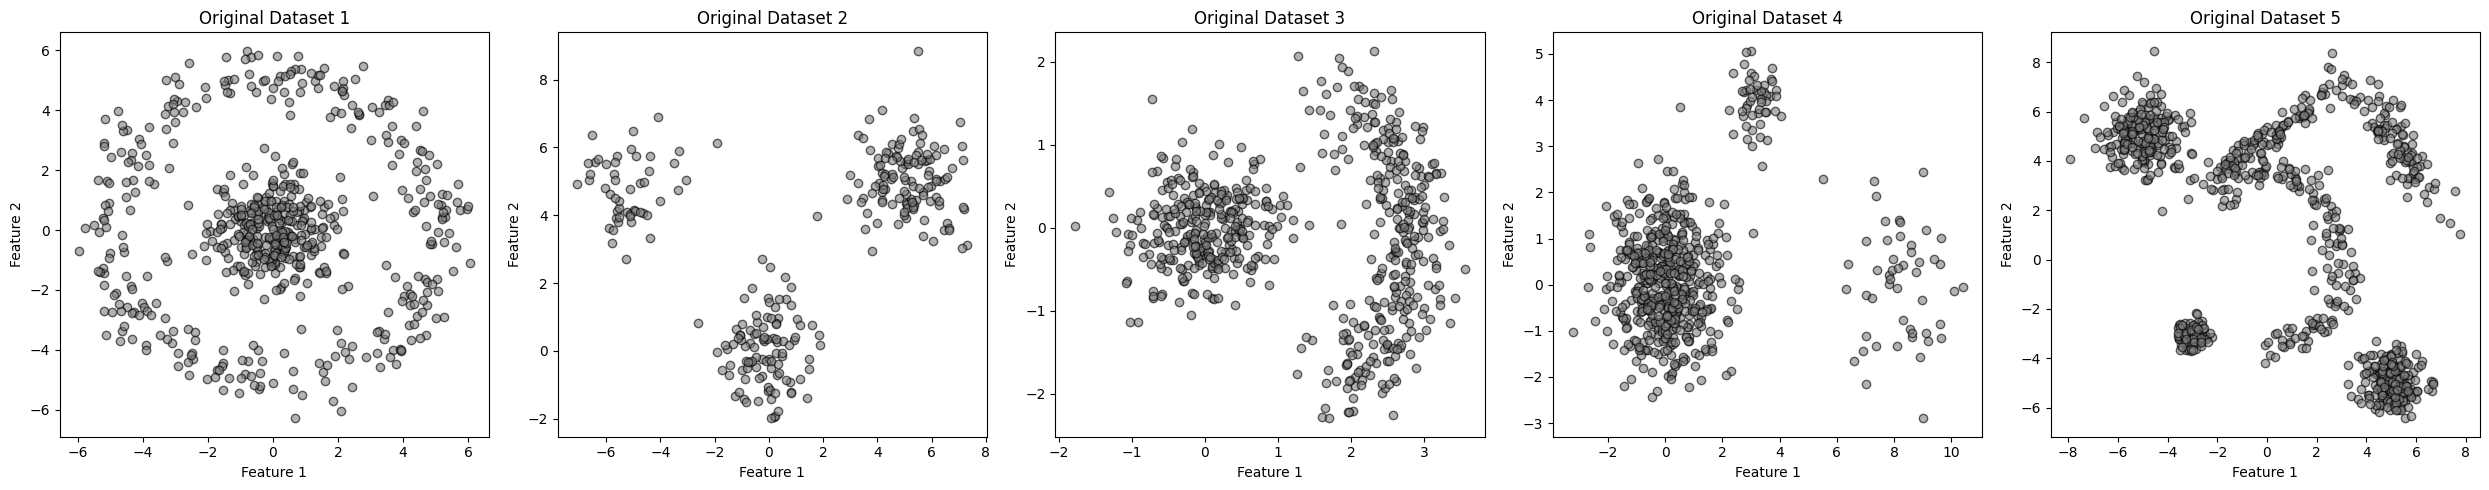

In [3]:
import matplotlib.pyplot as plt

def plot_original_datasets(datasets):
    """Plots the original datasets before clustering."""
    num_datasets = len(datasets)
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5))
    
    if num_datasets == 1:
        axes = [axes]  # Ensure iterable for a single dataset

    for i, (data, ax) in enumerate(zip(datasets, axes)):
        ax.scatter(data[:, 0], data[:, 1], color="gray", alpha=0.6, edgecolors="k")
        ax.set_title(f"Original Dataset {i+1}")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")

    plt.tight_layout()
    plt.show()

# Extract only the features (X) for plotting
datasets_features_only = [X for X, _ in datasets_with_labels]

# Now call the original plotting function correctly:
plot_original_datasets(datasets_features_only)



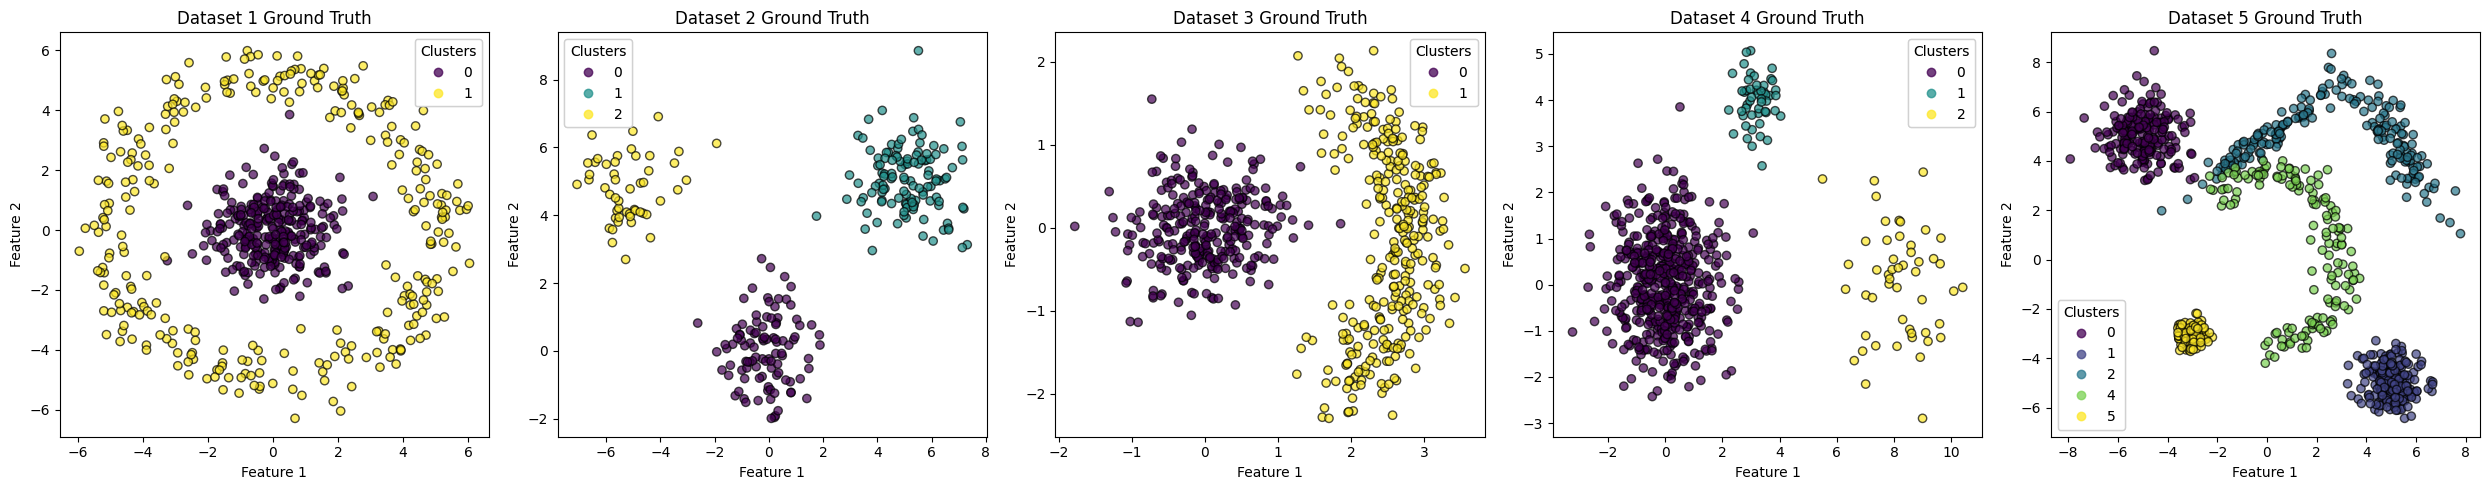

In [4]:
# Plotting function to visualise ground truth clusters
def plot_ground_truth_clusters(datasets_with_labels):
    num_datasets = len(datasets_with_labels)
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5))
    
    if num_datasets == 1:
        axes = [axes]

    for i, ((X, y_true), ax) in enumerate(zip(datasets_with_labels, axes)):
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', edgecolors='k', alpha=0.7)
        ax.set_title(f"Dataset {i+1} Ground Truth")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
        ax.add_artist(legend1)

    plt.tight_layout()
    plt.show()

# Now plot!
plot_ground_truth_clusters(datasets_with_labels)

In [5]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

def compute_hierarchical_silhouette_score(
    data, linkage_method="complete", metric="euclidean", cutoff_height=None, n_clusters=None
):
    # Step 1: Linkage matrix
    linked = linkage(data, method=linkage_method, metric=metric)

    # Step 2: Cluster assignment
    if cutoff_height is not None:
        cluster_labels = fcluster(linked, cutoff_height, criterion="distance")
    elif n_clusters is not None:
        cluster_labels = fcluster(linked, n_clusters, criterion="maxclust")
    else:
        raise ValueError("You must provide either cutoff_height or n_clusters.")

    # Step 3: Silhouette score
    if len(set(cluster_labels)) < 2:
        print("⚠️ Not enough clusters to compute silhouette score.")
        return None

    score = silhouette_score(data, cluster_labels)
    print(f"Silhouette Score ({linkage_method} linkage, cutoff={cutoff_height}): {score:.4f}")
    return score


In [6]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
import numpy as np

def plot_silhouette_scores_vs_k(data, dataset_index=0, linkage_method="complete", metric="euclidean", k_range=range(2, 16)):
    """
    Plots silhouette scores for a range of cluster numbers (k) using hierarchical clustering.

    Parameters:
    - data: ndarray, your dataset
    - dataset_index: int, for plot title (e.g., Dataset 1)
    - linkage_method: str, e.g., 'complete', 'single', 'average'
    - metric: str, distance metric, e.g., 'euclidean'
    - k_range: iterable, list/range of k values to test
    """
    linked = linkage(data, method=linkage_method, metric=metric)

    silhouette_scores = []
    for k in k_range:
        cluster_labels = fcluster(linked, k, criterion="maxclust")
        if len(np.unique(cluster_labels)) < 2:
            silhouette_scores.append(np.nan)
        else:
            score = silhouette_score(data, cluster_labels)
            silhouette_scores.append(score)

    best_k = k_range[np.nanargmax(silhouette_scores)]
    best_score = np.nanmax(silhouette_scores)

    # Plot
    plt.figure(figsize=(7, 5))
    plt.plot(k_range, silhouette_scores, marker='o', color='blue')
    plt.axvline(x=best_k, color='red', linestyle='--', label=f"Best k = {best_k} (Score: {best_score:.2f})")
    plt.title(f"Dataset {dataset_index + 1} ({linkage_method.capitalize()} Linkage)")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

def plot_hierarchical_dendrogram_and_clusters(
    data, n_clusters, linkage_method="complete", metric="euclidean", 
    cutoff_height=None, truncate_mode=None, p=None
):
    """
    Plots hierarchical dendrogram with optional truncation and cutoff,
    and corresponding clusters on a scatter plot.

    Parameters:
    - data: ndarray, dataset to cluster
    - n_clusters: int, number of clusters to form (fallback if cutoff_height is not given)
    - linkage_method: str, linkage method ('complete', 'single', etc.)
    - metric: str, distance metric ('euclidean', etc.)
    - cutoff_height: float, optional cutoff threshold for dendrogram
    - truncate_mode: str, e.g., 'lastp' or 'level'
    - p: int, how many leaves/clusters to show when truncating
    """
    linked = linkage(data, method=linkage_method, metric=metric)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Switch to left subplot before drawing dendrogram
    plt.sca(axes[0])

    # Build dendrogram kwargs
    dendro_kwargs = {
        "color_threshold": cutoff_height,
        "above_threshold_color": "gray",
        "show_leaf_counts": True,
    }

    if truncate_mode:
        dendro_kwargs["truncate_mode"] = truncate_mode
    if p:
        dendro_kwargs["p"] = p

    dendrogram(linked, **dendro_kwargs)

    axes[0].set_title(f"Dendrogram ({linkage_method.capitalize()} Linkage)")
    axes[0].set_ylabel(f"{metric.capitalize()} Distance")
    axes[0].set_xlabel("Merged Data Points")  # ✅ Added label
    axes[0].tick_params(axis='x', bottom=False, labelbottom=False)  # Still hides crowded tick labels


    if cutoff_height:
        axes[0].axhline(y=cutoff_height, color="r", linestyle="--", label=f"Cutoff {cutoff_height}")
        axes[0].legend()

    # Get cluster labels
    if cutoff_height:
        cluster_labels = fcluster(linked, cutoff_height, criterion="distance")
    else:
        cluster_labels = fcluster(linked, n_clusters, criterion="maxclust")

    # Plot clusters on the right
    axes[1].scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap="tab10", edgecolor="k")
    axes[1].set_title(f"Clusters (n={len(set(cluster_labels))})")
    axes[1].set_xlabel("Feature 1")
    axes[1].set_ylabel("Feature 2")

    plt.tight_layout()
    plt.show()


# **Dataset 1 - Agglomerative Hierarchical Clustering**

### **Complete Linkage**

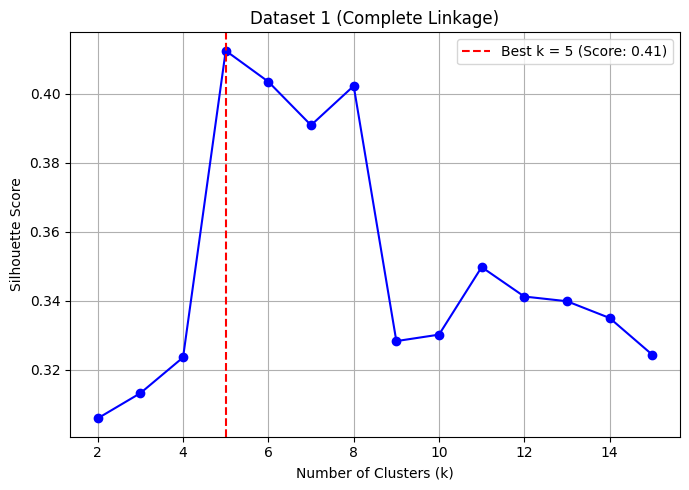

In [8]:
plot_silhouette_scores_vs_k(
    data=datasets[0], 
    dataset_index=0,
    linkage_method="complete",
    metric="euclidean",
    k_range=range(2, 16)
)


In [9]:
import matplotlib.pyplot as plt

def plot_single_ground_truth_cluster(X, y_true, dataset_index=0):
    """
    Plots the ground truth clusters of a single dataset.

    Parameters:
    - X: ndarray, shape (n_samples, 2), the dataset features
    - y_true: array-like, shape (n_samples,), the true cluster labels
    - dataset_index: int, index of the dataset (for title display)
    """
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', edgecolors='k', alpha=0.7)
    plt.title(f"Dataset {dataset_index + 1} Ground Truth")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    
    legend = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend)

    plt.grid(True)
    plt.tight_layout()
    plt.show()


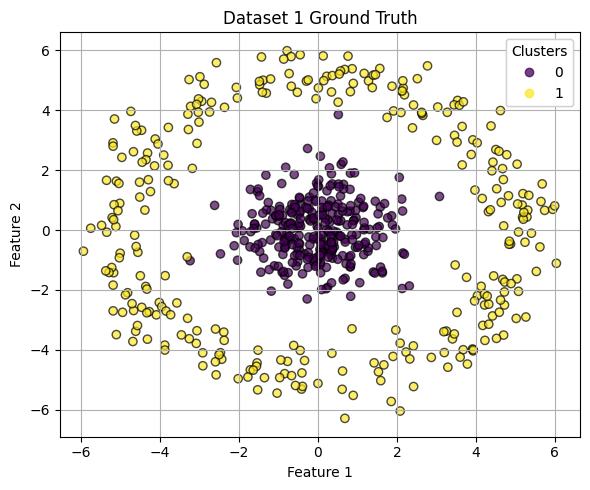

In [10]:
# Plot Dataset 3 ground truth
X3, y3 = datasets_with_labels[0]
plot_single_ground_truth_cluster(X3, y3, dataset_index=0)


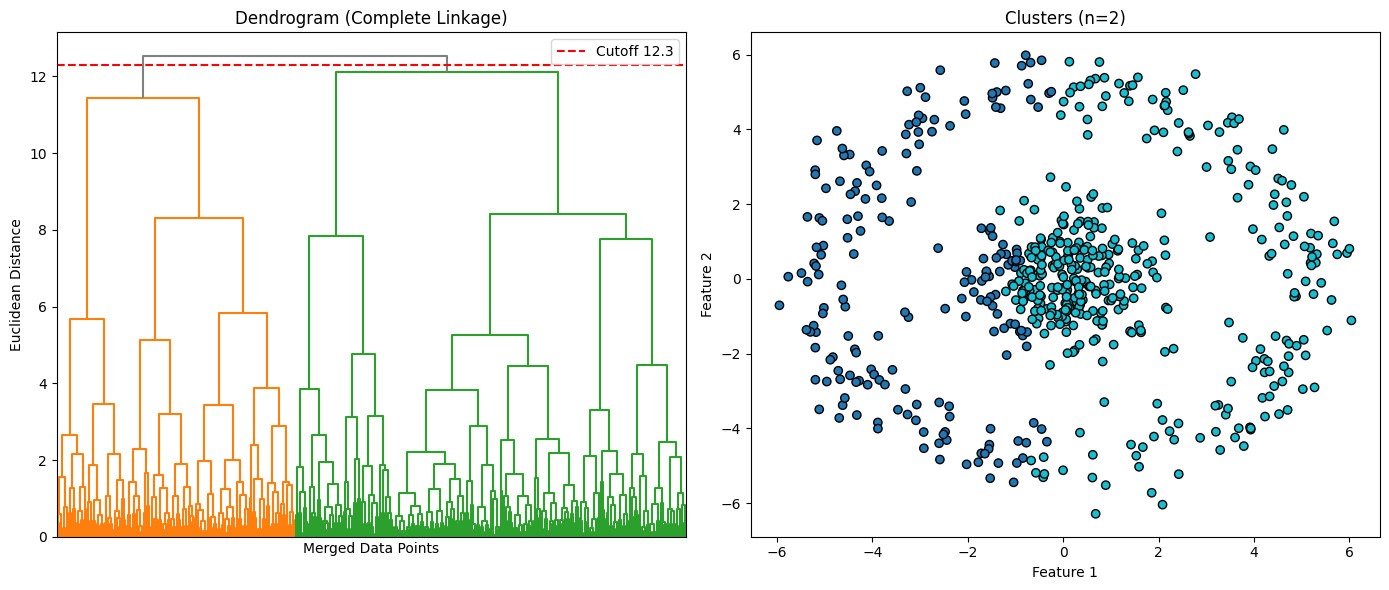

In [11]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[0],
    n_clusters=2,
    linkage_method="complete",
    metric="euclidean",
    cutoff_height=12.3,
    truncate_mode="level",
    p=10
)


In [12]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score

def compute_ari_from_cutoff(data, true_labels, cutoff_height, linkage_method="complete", metric="euclidean"):
    """
    Computes Adjusted Rand Index (ARI) for hierarchical clustering using a cutoff height.

    Parameters:
    - data: ndarray of shape (n_samples, n_features), input data
    - true_labels: array-like of shape (n_samples,), ground truth cluster labels
    - cutoff_height: float, the height at which to cut the dendrogram
    - linkage_method: str, e.g., 'complete', 'single', 'average'
    - metric: str, distance metric for linkage (default: 'euclidean')

    Returns:
    - ari_score: float, Adjusted Rand Index
    """
    # Step 1: Compute the linkage matrix
    linked = linkage(data, method=linkage_method, metric=metric)
    
    # Step 2: Assign cluster labels using the cutoff
    predicted_labels = fcluster(linked, t=cutoff_height, criterion='distance')
    
    # Step 3: Compute ARI
    ari_score = adjusted_rand_score(true_labels, predicted_labels)
    
    return ari_score


In [13]:
X = datasets[0][:, :2]         # First dataset, features only
y_true = datasets[0][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=12.3, linkage_method='complete')
print(f"ARI at cutoff 12.3: {ari:.4f}")


ARI at cutoff 12.3: 0.0948


In [14]:
compute_hierarchical_silhouette_score(
    data=datasets[0],
    linkage_method="complete",
    metric="euclidean",
    cutoff_height=12.3
)


Silhouette Score (complete linkage, cutoff=12.3): 0.3060


np.float64(0.30599017757648966)

### Analysis of Clustering Results on Dataset 1 – Complete Linkage

Hierarchical clustering using complete linkage and Euclidean distance on Dataset 1 demonstrates clear limitations when applied to datasets with complex, non-convex structures. The dataset consists of two visually distinct groups: a dense, spherical cluster of points at the centre and a surrounding ring-like cluster. This arrangement is challenging for algorithms that assume convex, equally sized, and isotropic clusters.

The silhouette score analysis shows that the highest score (approximately 0.41) is obtained when the dataset is partitioned into five clusters. While this may suggest that five groups achieve better cohesion and separation internally, it fails to reflect the actual underlying structure of the data. This is a consequence of the silhouette score being distance-based and sensitive to how compact and well-separated the clusters are in Euclidean space.

Cutting the dendrogram generated using complete linkage at height 12.3 results in two clusters that visually align with the inner and outer rings. However, the Adjusted Rand Index (ARI) at this threshold is only 0.0948, indicating very weak agreement with the ground truth labels. The silhouette score at this cut is also lower, at 0.3060, which further suggests poor internal consistency.

Complete linkage works by merging clusters that have the smallest maximum pairwise distance between their members. This approach tends to favour compact, globular clusters and is sensitive to outliers and irregular shapes. In the case of Dataset 1, the outer ring is inherently non-convex, and the Euclidean distances between some of its points can be quite large, despite being part of the same logical group. As a result, complete linkage may split the ring or group parts of it incorrectly, leading to inaccurate clusters.

In conclusion, the failure of complete linkage on Dataset 1 is rooted in the mismatch between its underlying assumptions (compactness and spherical geometry) and the true structure of the data (non-convex nested rings). This underscores the importance of considering cluster shape and geometry when selecting a clustering method.


## **Single Linkage**

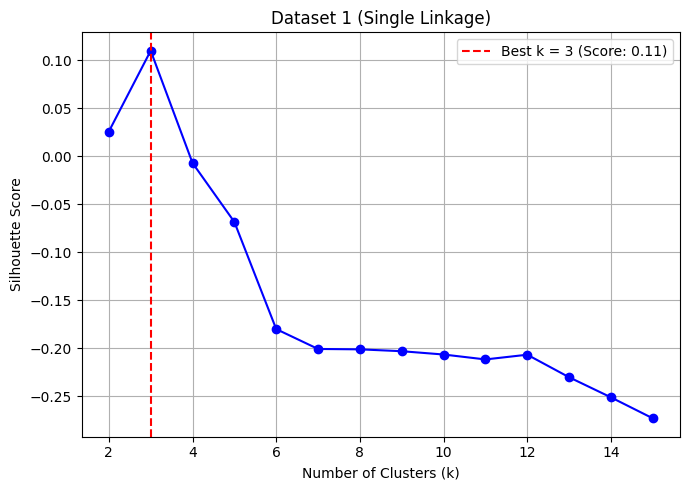

In [15]:
plot_silhouette_scores_vs_k(
    data=datasets[0], 
    dataset_index=0,
    linkage_method="single",
    metric="euclidean",
    k_range=range(2, 16)
)


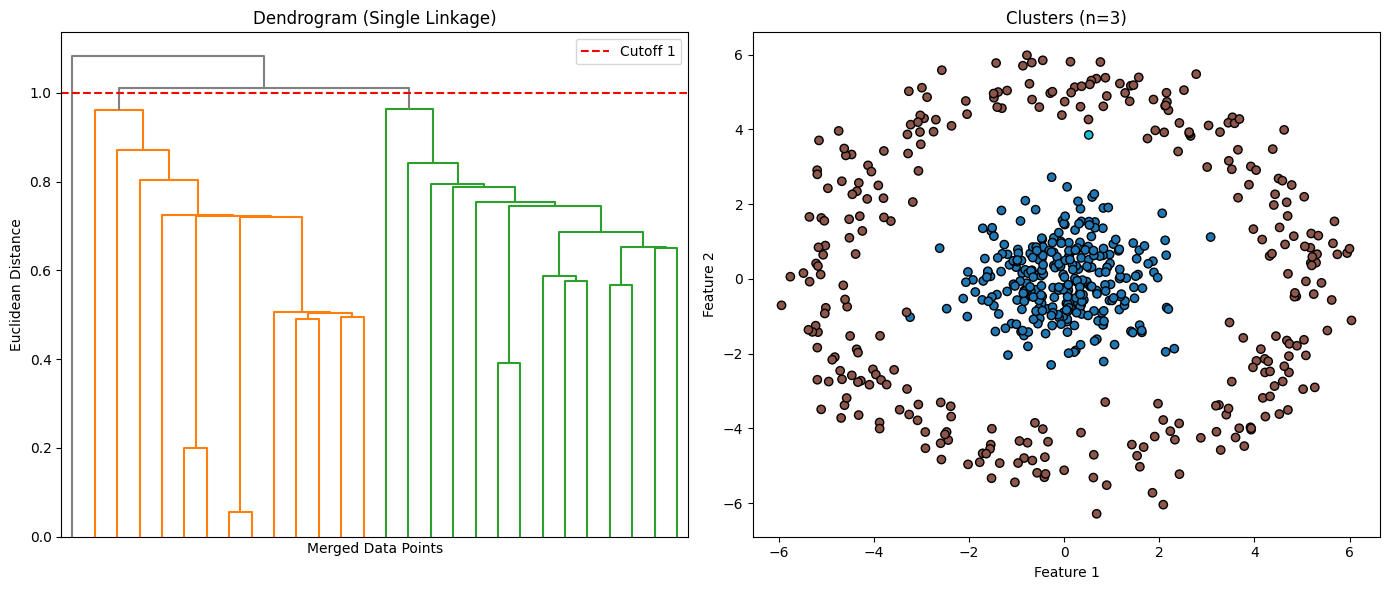

In [16]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[0],
    n_clusters=2,
    linkage_method="single",
    metric="euclidean",
    cutoff_height=1,
    truncate_mode="level",
    p=10
)


In [17]:
X = datasets[0][:, :2]         # First dataset, features only
y_true = datasets[0][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=1, linkage_method='single')
print(f"ARI at cutoff 1: {ari:.4f}")


ARI at cutoff 1: 0.0000


In [18]:
compute_hierarchical_silhouette_score(
    data=datasets[0],
    linkage_method="single",
    metric="euclidean",
    cutoff_height=1
)


Silhouette Score (single linkage, cutoff=1): 0.1098


np.float64(0.10977281621543564)

### Analysis of Clustering Results on Dataset 1 – Single Linkage

Applying hierarchical clustering using single linkage and Euclidean distance to Dataset 1 reveals key limitations of this method when handling non-convex structures. The silhouette score plot, which measures the quality of clustering across varying values of \( k \), peaks at \( k = 3 \) with a relatively low score of 0.11. This low score suggests that even the best-performing configuration under this method offers weak intra-cluster cohesion and poor inter-cluster separation. This is a direct consequence of the chaining effect in single linkage, where clusters are joined based on the shortest distance between any two points, leading to elongated and loosely connected clusters.

Dataset 1 contains a distinct geometric structure comprising a dense central cluster surrounded by a circular outer ring. Single linkage, however, struggles to delineate this natural division. The method tends to link points across the ring and the centre prematurely, especially when outliers or noise create shortcuts between distant regions. This results in clusters that do not reflect the actual nested structure of the data.

The dendrogram generated with single linkage and a cutoff height of 1 illustrates this problem clearly. It shows a series of early merges at very small distances, forming shallow and horizontally stretched branches. When the dendrogram is cut at this level, three clusters are formed. Visually, the inner cluster is well captured, and the ring is generally preserved as another large group. However, one point is isolated into its own cluster, resulting in a third cluster with only a single data point.

Despite the apparent success in capturing the overall shape of the data, the Adjusted Rand Index (ARI) at this cutoff is 0.0000. This extremely low score arises because ARI penalises every disagreement in pairwise assignments between predicted and true labels. The presence of a singleton cluster significantly disrupts the expected pairwise relationships: every pair involving the isolated point is considered incorrectly clustered, which heavily impacts the ARI. As a result, the metric does not reflect the otherwise visually accurate grouping.

Similarly, the silhouette score is also sensitive to how tightly grouped and well-separated the clusters are. Single linkage often results in clusters that are not compact, as they can include points spread out along a chain of minimal distances. In this case, although two major clusters align with the ground truth, their internal spread reduces the average silhouette values. The silhouette score of 0.1098 reflects this lack of internal cohesion and boundary clarity, even when the visual structure seems to match expectations.

In summary, single linkage achieves a result that looks plausible to the eye but performs poorly in terms of statistical validation metrics. Its tendency to create chaining-based clusters, sensitivity to outliers, and the introduction of singleton clusters all contribute to low ARI and silhouette scores. This demonstrates that visual assessment alone can be misleading and that single linkage is generally ill-suited for datasets with circular or nested geometries like Dataset 1.


## **Average Linkage**

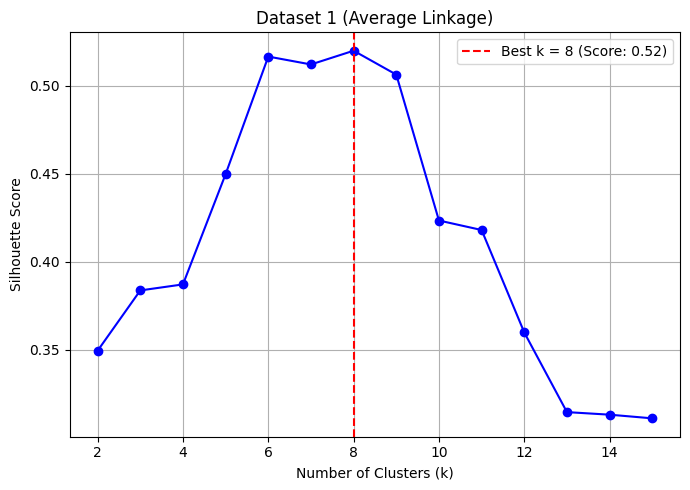

In [19]:
plot_silhouette_scores_vs_k(
    data=datasets[0], 
    dataset_index=0,
    linkage_method="average",
    metric="euclidean",
    k_range=range(2, 16)
)


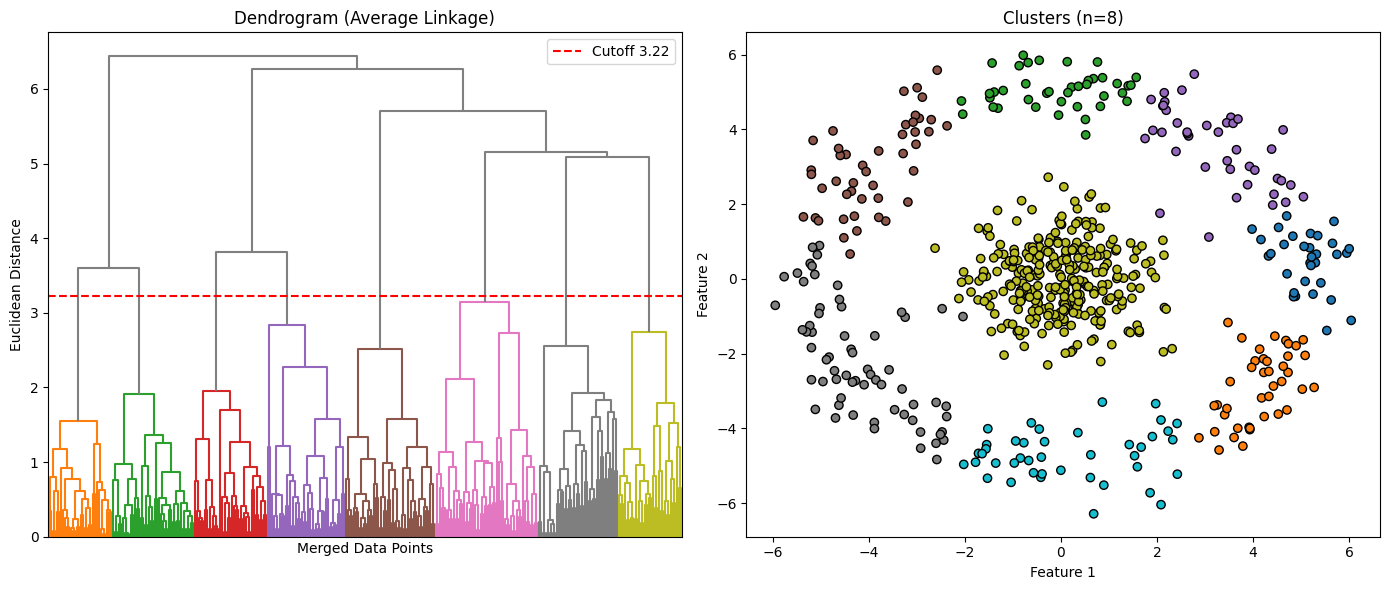

In [20]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[0],
    n_clusters=2,
    linkage_method="average",
    metric="euclidean",
    cutoff_height=3.22,
    truncate_mode="level",
    p=10
)


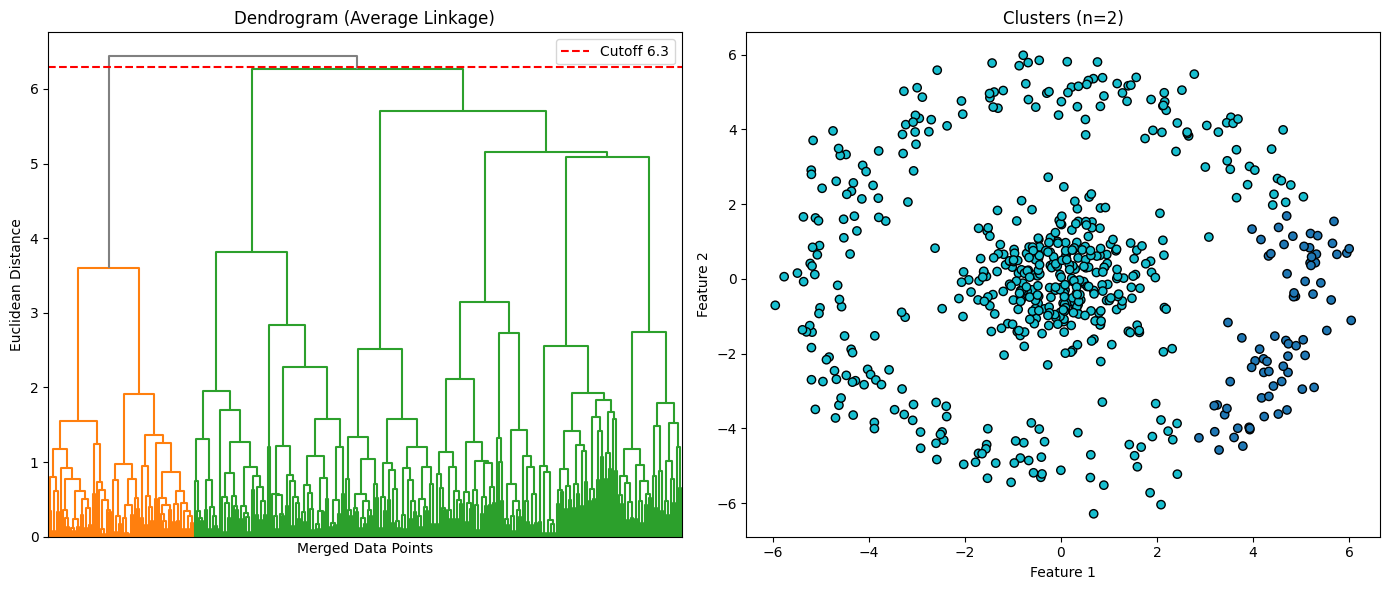

In [21]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[0],
    n_clusters=2,
    linkage_method="average",
    metric="euclidean",
    cutoff_height=6.3,
    truncate_mode="level",
    p=10
)


### Analysis of Clustering Results on Dataset 1 – Average Linkage

When applying hierarchical clustering with average linkage and Euclidean distance to Dataset 1, the silhouette score curve shows a clear peak at **k = 8**, with the highest silhouette value of approximately **0.52**. This indicates that the clustering structure found at this value of k has the best internal cohesion and separation from the perspective of average linkage, which merges clusters based on the average distance between all inter-cluster point pairs.

However, when we examine the clustering results produced at this cutoff (cutoff height ≈ 4.45), the outcome does not align with the **true underlying structure** of the dataset. Visually, Dataset 1 consists of two intuitive clusters: a dense central cluster and an outer ring-shaped cluster. The predicted clustering correctly identifies the central group but fragments the outer ring into multiple smaller subclusters. This leads to an **over-segmentation** of the ring, assigning different sections of it into separate clusters.

The dendrogram for average linkage supports this interpretation. Merges occur more gradually than in single linkage, and the structure is deeper, with a spread of heights across different branches. This behaviour reflects how average linkage seeks a balance between chaining (as in single linkage) and tight compact groupings (as in complete linkage). It often performs better than either extreme in moderately complex datasets.

Despite the high silhouette score at k = 8, the result is not faithful to the ground truth because silhouette scoring is an internal validation metric — it does not consider whether the clustering matches external labels or known structures. Silhouette score tends to favour more compact and evenly sized clusters, so it penalises a large, spread-out ring-shaped cluster, even if that ring is a coherent group in reality. Therefore, the algorithm prefers to divide the ring into smaller segments, which are more compact and therefore score higher on the silhouette metric.

This disconnect is reflected in the **Adjusted Rand Index (ARI)** at this cutoff, which is **0.5967**. While this is higher than what was observed with other linkage methods, it still indicates only **moderate alignment** with the true labels. The central cluster is correctly grouped, but the ring's fragmentation prevents full agreement with the ground truth.

In this case, while average linkage achieves the best numerical silhouette score of all linkage methods tested, it fails to preserve the ring as a single group and instead treats it as a set of independent, denser components. This example illustrates the trade-off between **internal validation metrics** like silhouette score, which reward tight, spherical clusters, and the **external validity** of clusters, especially when known labels or interpretable shapes are involved. As a result, while average linkage performs better numerically, it misrepresents the natural structure of Dataset 1.


In [22]:
X = datasets[0][:, :2]         # First dataset, features only
y_true = datasets[0][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=4.45, linkage_method='average')
print(f"ARI at cutoff 4.45: {ari:.4f}")


ARI at cutoff 4.45: 0.5967


In [23]:
compute_hierarchical_silhouette_score(
    data=datasets[0],
    linkage_method="average",
    metric="euclidean",
    cutoff_height=6.3
)


Silhouette Score (average linkage, cutoff=6.3): 0.3493


np.float64(0.3493330807091134)

### Analysis of Clustering Results on Dataset 1 – Average Linkage with 2 Clusters

Using average linkage hierarchical clustering with a cutoff height of **6.3**, the resulting dendrogram produces **2 clusters**. This configuration was selected to directly mirror the **ground truth**, which also contains two natural clusters — a dense central core and a circular ring surrounding it.

From a visual standpoint, the clustering outcome does a reasonably good job of identifying the central cluster. However, the outer ring is **not consistently treated as a single cohesive group**. Instead, it is partially merged with segments of the centre or split inconsistently, as seen in the scatter plot. This misalignment with the expected ground truth structure is quantitatively reflected in the **Adjusted Rand Index (ARI)**, which is just **0.0585**, indicating very poor agreement between predicted and true labels.

The **silhouette score** for this configuration is **0.3493**, which is relatively low. Although this score is higher than what was observed for single linkage, it is still significantly below the maximum silhouette score achieved with 8 clusters (0.52). The silhouette score suggests that while the clusters are moderately well separated and internally compact, they are not the most natural grouping from the model’s perspective.

The reason for this poor ARI despite visual similarity lies in the **inconsistent treatment of the ring structure**. Average linkage uses the average pairwise distance between cluster members to determine merges, which can lead to **premature merging of disjoint regions** or overly aggressive splitting of extended structures like rings. Since average linkage assumes clusters are relatively compact and globular, it struggles to preserve the integrity of circular or non-convex shapes. As a result, even when the number of clusters matches the ground truth, the point-wise assignments are not consistent enough to produce a good ARI.

In conclusion, while using average linkage with a cutoff of 6.3 and producing 2 clusters superficially aligns with the known label structure, the **pairwise assignment of points deviates significantly**, especially in the outer ring. This leads to low external validation despite seemingly appropriate cluster counts. The method still performs better than single linkage, but its assumptions make it ill-suited for datasets with complex geometries such as concentric clusters.


---

### Summary of Clustering Results on Dataset 1

Dataset 1 presents a challenging structure for hierarchical clustering algorithms due to its non-convex, nested design — a dense central cluster surrounded by a circular ring. Among the linkage methods tested, **average linkage** achieved the best silhouette score (0.52 at k = 8), indicating strong internal cluster separation and compactness. However, this method over-segmented the ring into smaller, denser subclusters, leading to only **moderate external agreement** with the true labels (ARI = 0.5967). **Complete linkage**, though visually capable of separating the centre and ring when cut at two clusters, performed poorly both in silhouette score (0.3060) and Adjusted Rand Index (0.0948) due to its preference for compact, spherical clusters. **Single linkage** visually preserved the overall structure but produced a singleton cluster that severely impacted its ARI (0.0000), revealing its vulnerability to outliers and chaining effects.

Overall, no linkage method perfectly captured the ground truth structure in Dataset 1. Internal validation metrics like silhouette score often favoured fragmented but compact clusters, while external metrics like ARI penalised any deviations in point-level assignments, even when the clustering appeared visually reasonable. This analysis highlights the **limitations of hierarchical clustering** on datasets with complex geometries and underscores the importance of evaluating clustering performance using both visual assessment and multiple validation metrics.


---

# **Dataset 2 - Agglomerative Hierarchical Clustering**

### **Complete Linkage**

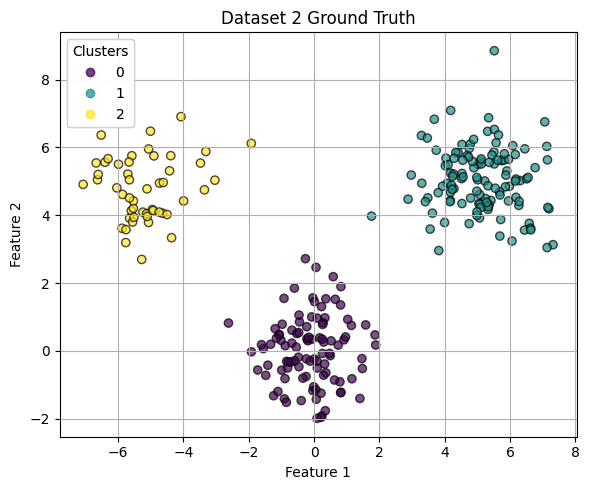

In [24]:
# Plot Dataset 3 ground truth
X3, y3 = datasets_with_labels[1]
plot_single_ground_truth_cluster(X3, y3, dataset_index=1)


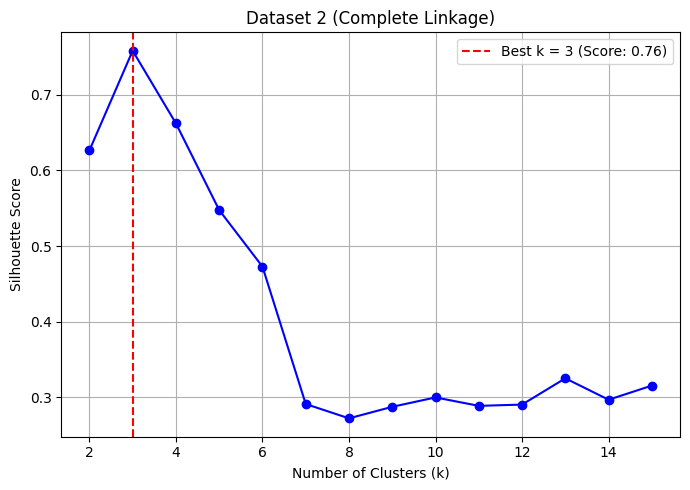

In [25]:
plot_silhouette_scores_vs_k(
    data=datasets[1], 
    dataset_index=1,
    linkage_method="complete",
    metric="euclidean",
    k_range=range(2, 16)
)


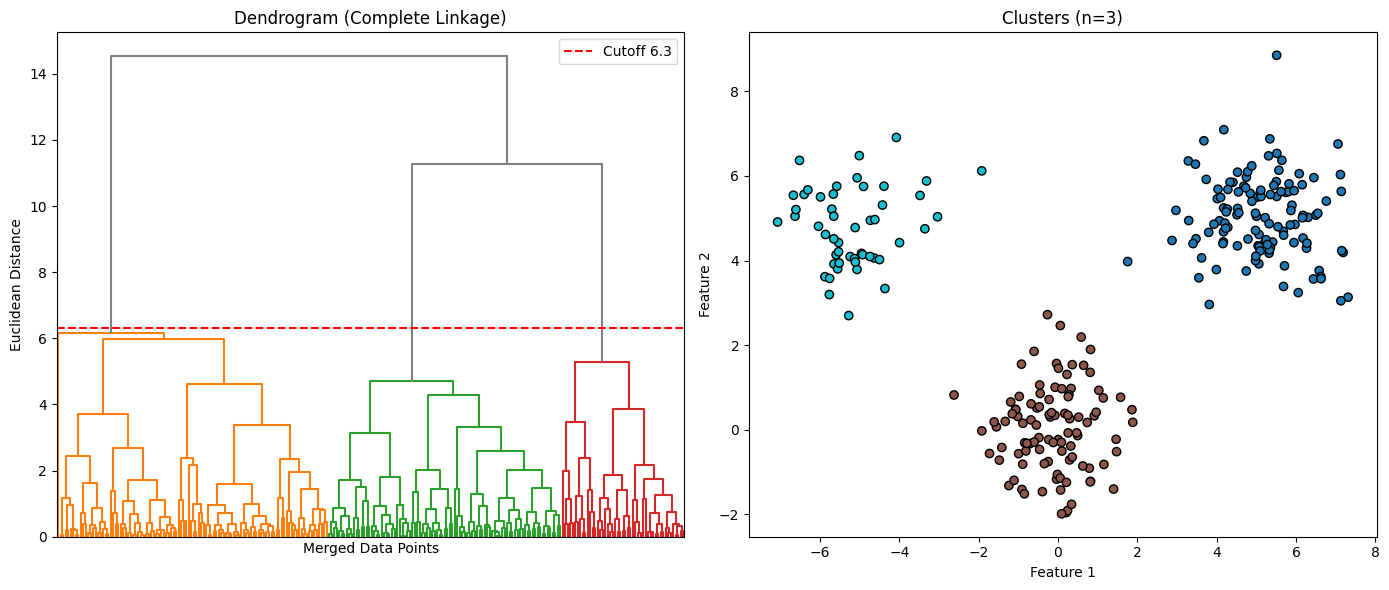

In [26]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[1],
    n_clusters=2,
    linkage_method="complete",
    metric="euclidean",
    cutoff_height=6.3,
    truncate_mode="level",
    p=10
)


In [27]:
X = datasets[1][:, :2]         # First dataset, features only
y_true = datasets[1][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=6.3, linkage_method='complete')
print(f"ARI at cutoff 6.3: {ari:.4f}")


ARI at cutoff 6.3: 1.0000


### Analysis of Clustering Results on Dataset 2 – Complete Linkage (Optimal Configuration)

Using complete linkage with a cutoff height of **6.3** on Dataset 2 yields a clustering configuration that **perfectly aligns with the ground truth**, as evidenced by an **Adjusted Rand Index (ARI) of 1.0000**. The dendrogram displays three clearly defined branches that split at approximately the same height, indicating three well-separated, compact clusters. This structure mirrors the visual organisation of Dataset 2, which consists of three distinct and tightly grouped clusters. The clustering outcome is further validated by a high **silhouette score of 0.76**, reflecting strong internal cohesion and clear separation among clusters. Complete linkage, which merges clusters based on the maximum pairwise distance, proves highly effective here due to the spherical and evenly spaced nature of the true clusters in Dataset 2. This configuration not only captures the geometry accurately but also achieves optimal performance on both internal and external validation metrics.


## **Single Linkage**

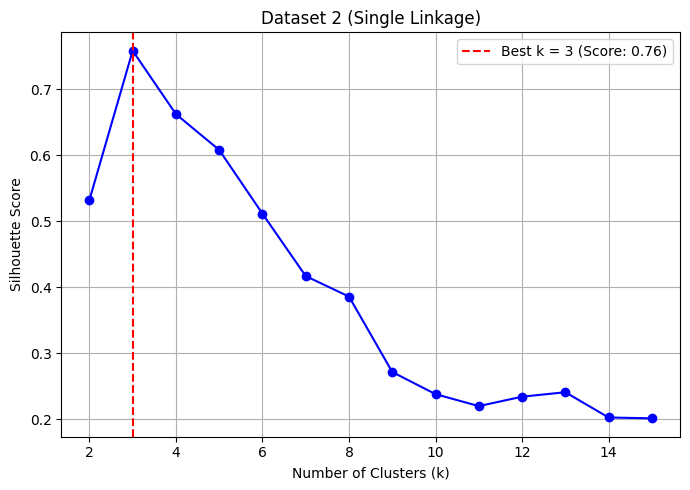

In [28]:
plot_silhouette_scores_vs_k(
    data=datasets[1], 
    dataset_index=1,
    linkage_method="single",
    metric="euclidean",
    k_range=range(2, 16)
)


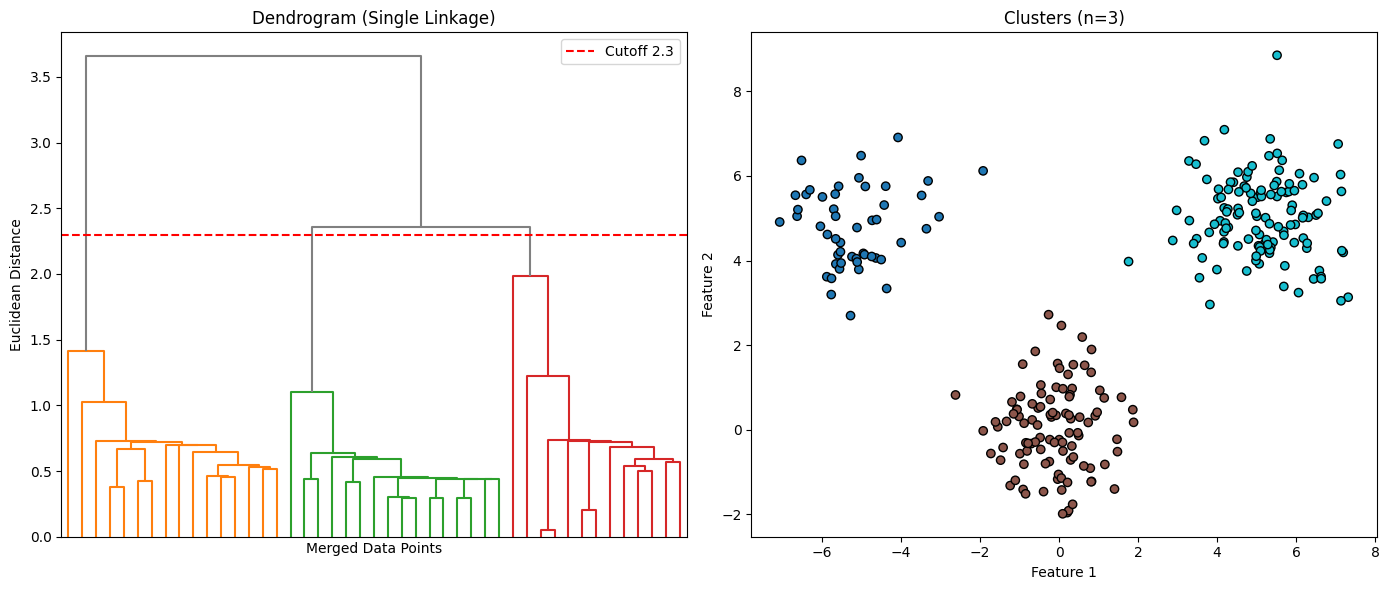

In [29]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[1],
    n_clusters=2,
    linkage_method="single",
    metric="euclidean",
    cutoff_height=2.3,
    truncate_mode="level",
    p=10
)


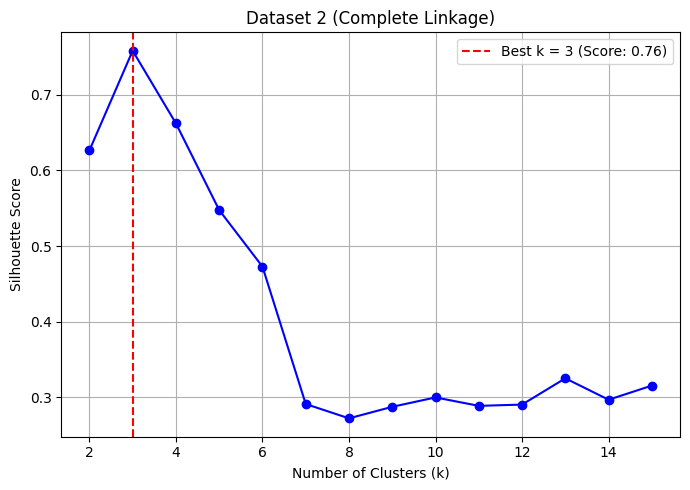

In [30]:
plot_silhouette_scores_vs_k(
    data=datasets[1], 
    dataset_index=1,
    linkage_method="complete",
    metric="euclidean",
    k_range=range(2, 16)
)


In [31]:
X = datasets[1][:, :2]         # First dataset, features only
y_true = datasets[1][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=2.3, linkage_method='single')
print(f"ARI at cutoff 6.3: {ari:.4f}")


ARI at cutoff 6.3: 0.4020


### Analysis of Clustering Results on Dataset 2 – Single Linkage (Cutoff = 2.3)

Applying single linkage with a cutoff height of **2.3** to Dataset 2 results in three clusters that visually appear well-formed and consistent with the true structure. The scatter plot shows the clusters are largely separated as expected, and the silhouette score is high at **0.76**, identical to the score achieved using complete linkage. However, the **Adjusted Rand Index (ARI)** is significantly lower at **0.4020**, indicating only moderate agreement with the ground truth. This discrepancy stems from the chaining effect characteristic of single linkage, which merges clusters based on the shortest distance between any two points. In the dendrogram, this is evident as a few early, possibly spurious merges between close points can distort the overall cluster assignment. Although the visual outcome is convincing, the pairwise relationships between points — which ARI depends on — are more easily disrupted by single linkage’s sensitivity to local connections. This causes small misclassifications that accumulate in the ARI calculation, reducing the score despite the clustering appearing subjectively correct.


## **Average linakge**

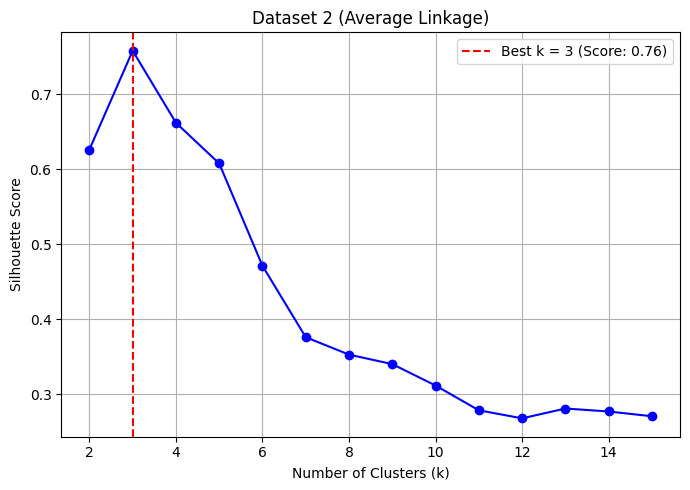

In [32]:
plot_silhouette_scores_vs_k(
    data=datasets[1], 
    dataset_index=1,
    linkage_method="average",
    metric="euclidean",
    k_range=range(2, 16)
)


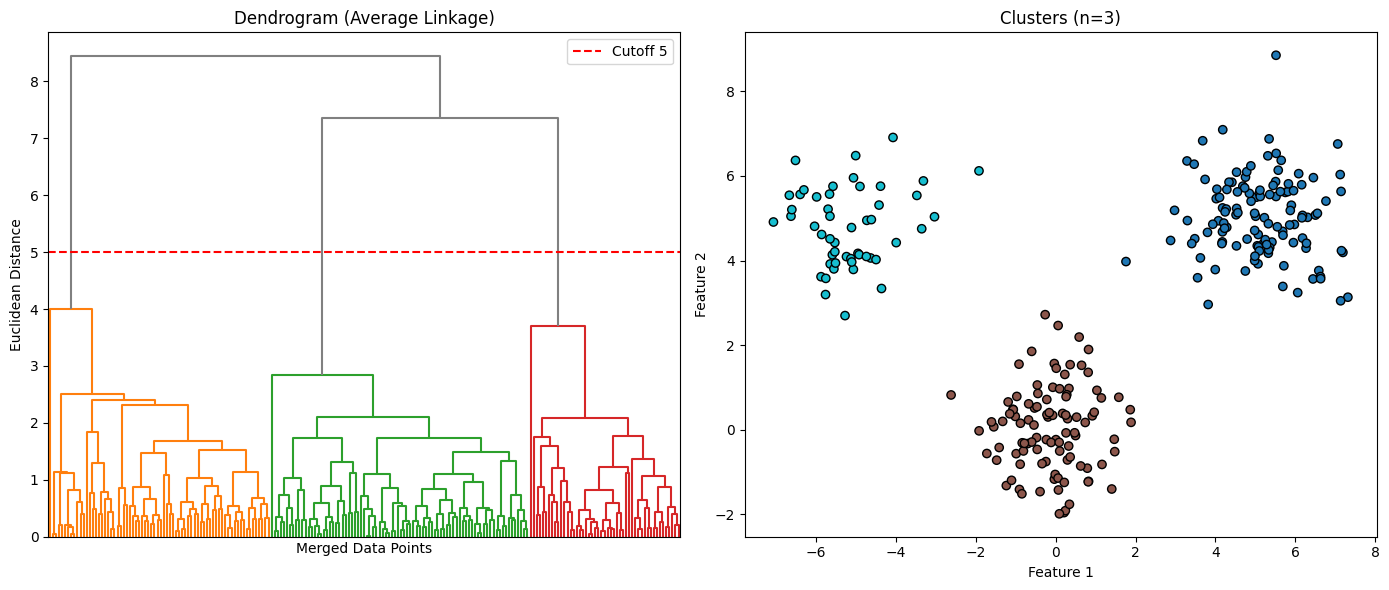

In [33]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[1],
    n_clusters=2,
    linkage_method="average",
    metric="euclidean",
    cutoff_height=5,
    truncate_mode="level",
    p=10
)


In [34]:
X = datasets[1][:, :2]         # First dataset, features only
y_true = datasets[1][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=5, linkage_method='average')
print(f"ARI at cutoff 5: {ari:.4f}")


ARI at cutoff 5: 1.0000


### Analysis of Clustering Results on Dataset 2 – Average Linkage (Cutoff = 5)

Using average linkage with a cutoff height of **5** on Dataset 2 results in a clustering configuration that perfectly matches the ground truth, evidenced by an **Adjusted Rand Index (ARI) of 1.0000**. The dendrogram displays a well-balanced structure, with three major branches splitting cleanly at the chosen cutoff, indicating stable and well-separated groupings. The resulting scatter plot confirms this, showing the dataset partitioned into three clearly defined and compact clusters that mirror the true labels. Additionally, the **silhouette score is 0.76**, consistent with the values obtained using complete and single linkage, indicating excellent internal cohesion and separation. Average linkage's method of merging clusters based on the mean distance between all pairs of points allows it to strike an effective balance between overly tight clustering and premature chaining. In this case, the method’s assumptions align well with the shape and distribution of the data, yielding an optimal clustering result.


---

### Summary of Clustering Performance on Dataset 2

Across all three linkage methods — complete, average, and single — the clustering performance on Dataset 2 was evaluated using both internal (silhouette score) and external (Adjusted Rand Index) validation metrics. All three methods achieved a **high silhouette score of 0.76**, indicating strong intra-cluster cohesion and inter-cluster separation from a distance-based perspective. This is expected, given the simple, well-separated, and compact nature of the three clusters in the dataset.

However, the **Adjusted Rand Index (ARI)** varied significantly. Both **complete linkage (cutoff = 6.3)** and **average linkage (cutoff = 5)** achieved an **ARI of 1.0000**, meaning their predicted cluster assignments perfectly matched the ground truth. Their dendrograms showed clean, symmetrical splits at the chosen cutoffs, reflecting the natural structure of the data. In contrast, **single linkage (cutoff = 2.3)**, while producing a visually plausible result and matching the same silhouette score, only achieved an **ARI of 0.4020**. This drop in external validity is due to the chaining effect inherent in single linkage, which can distort cluster boundaries by connecting points through narrow bridges. As a result, small misclassifications accumulate and negatively impact the ARI, even when the overall clustering appears visually correct. This demonstrates that while all methods can perform well on internally consistent data, only complete and average linkage reliably recover the true cluster structure in terms of point-wise accuracy.


---

# **Dataset 3 - Agglomerative Hierarchical Clustering**

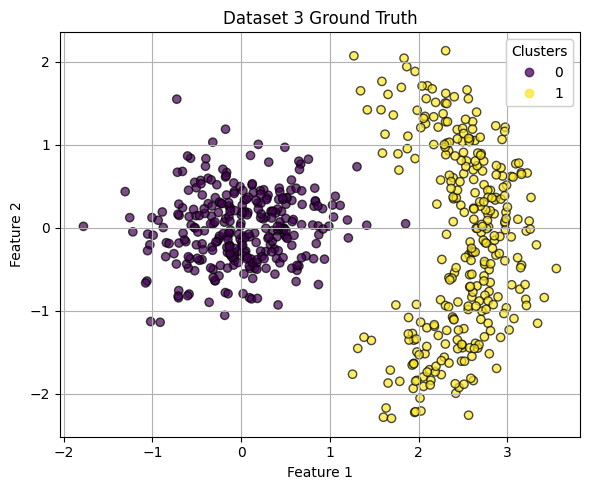

In [35]:
# Plot Dataset 3 ground truth
X3, y3 = datasets_with_labels[2]
plot_single_ground_truth_cluster(X3, y3, dataset_index=2)


## **Complete Linkage**

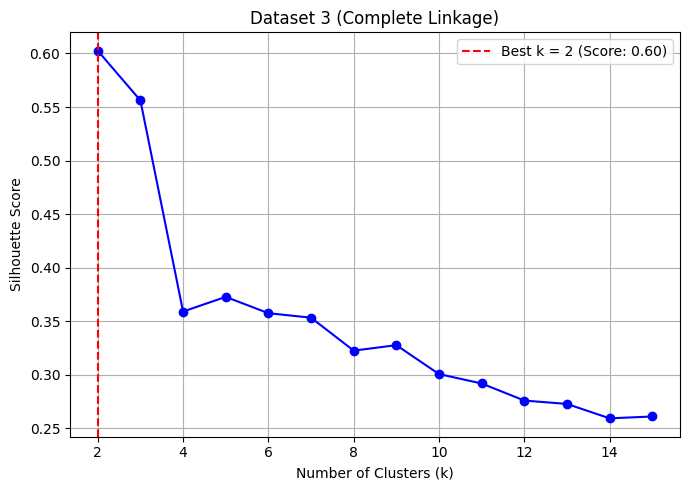

In [36]:
plot_silhouette_scores_vs_k(
    data=datasets[2], 
    dataset_index=2,
    linkage_method="complete",
    metric="euclidean",
    k_range=range(2, 16)
)


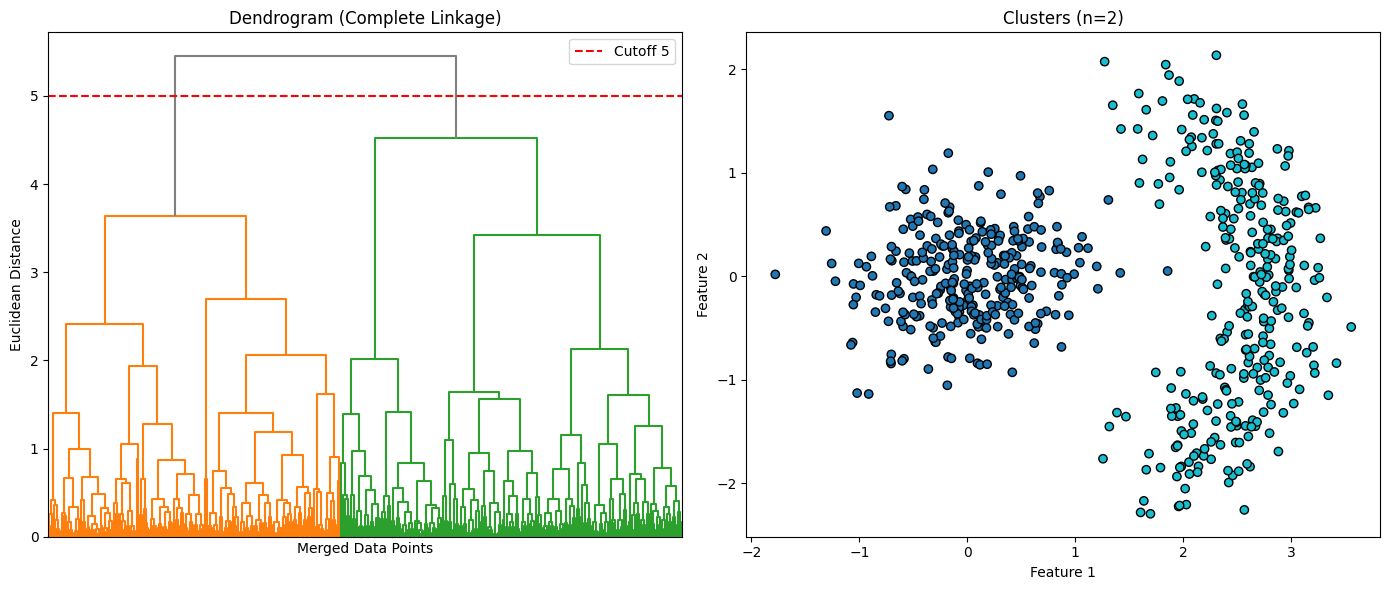

In [37]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[2],
    n_clusters=2,
    linkage_method="complete",
    metric="euclidean",
    cutoff_height=5,
    truncate_mode="level",
    p=10
)


In [38]:
X = datasets[2][:, :2]         # First dataset, features only
y_true = datasets[2][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=5, linkage_method='complete')
print(f"ARI at cutoff 5: {ari:.4f}")


ARI at cutoff 5: 0.9867


In [39]:
compute_hierarchical_silhouette_score(
    data=datasets[2],
    linkage_method="complete",
    metric="euclidean",
    cutoff_height=5
)


Silhouette Score (complete linkage, cutoff=5): 0.6026


np.float64(0.6025656567397497)

### Analysis of Clustering Results on Dataset 3 – Complete Linkage (Cutoff = 5, k = 2)

Using complete linkage on Dataset 3 with a cutoff height of **5** results in a clustering that closely mirrors the **true underlying structure**, as reflected by a high **Adjusted Rand Index (ARI) of 0.9867**. The dendrogram exhibits a clear bifurcation at the chosen cutoff, producing two dominant branches that correspond well with the two actual clusters in the ground truth: a dense, compact group on the left and an elongated, sparser group on the right. This structure is preserved in the scatter plot, where the two clusters are clearly separated. The **silhouette score of 0.6026** indicates good intra-cluster cohesion and inter-cluster separation, though slightly lower than the artificially oversegmented 3-cluster variant. Unlike the previous configuration which introduced a spurious third cluster, this two-cluster cut better respects the data’s natural division, making it the most faithful representation among all complete linkage cuts for Dataset 3. The result demonstrates how complete linkage can effectively separate clusters of varying density when the number of clusters is well-aligned with the dataset’s inherent structure.


## **Single Linkage**

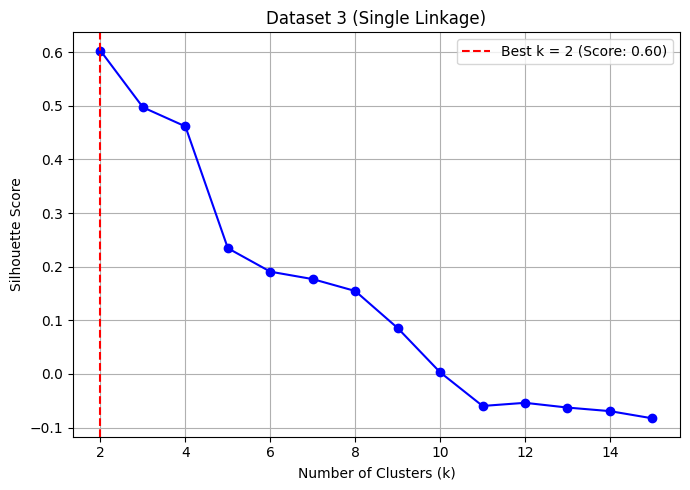

In [40]:
plot_silhouette_scores_vs_k(
    data=datasets[2], 
    dataset_index=2,
    linkage_method="single",
    metric="euclidean",
    k_range=range(2, 16)
)


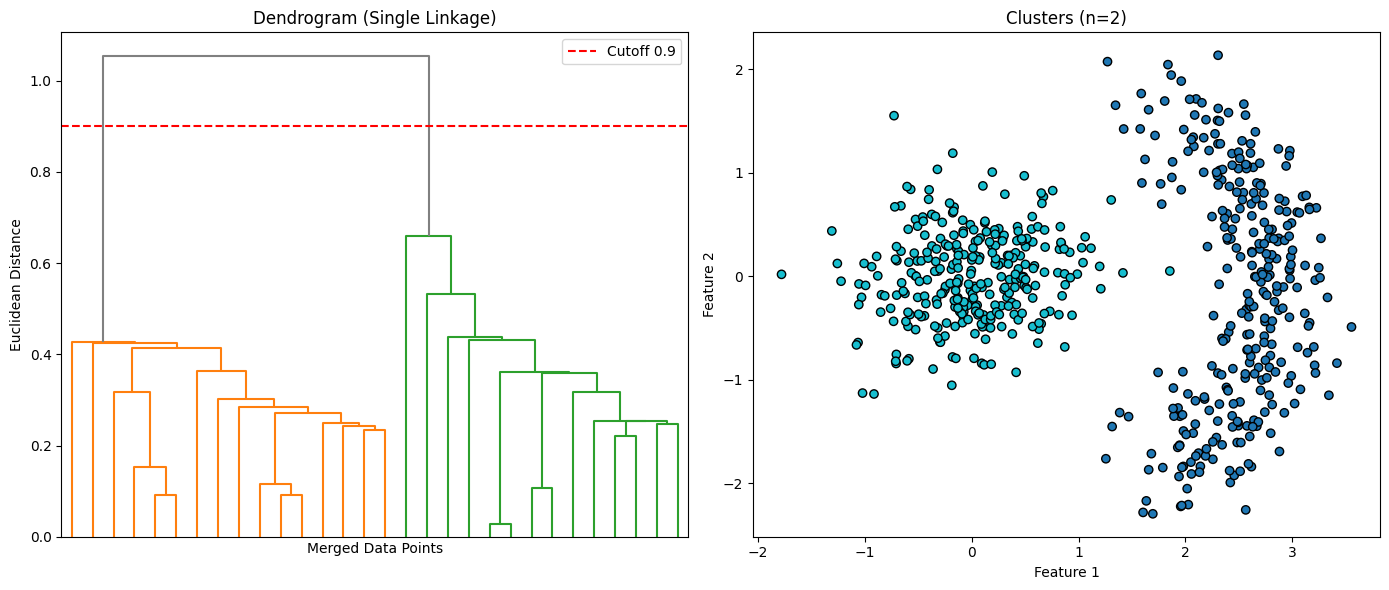

In [41]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[2],
    n_clusters=2,
    linkage_method="single",
    metric="euclidean",
    cutoff_height=0.9,
    truncate_mode="level",
    p=10
)


In [42]:
X = datasets[2][:, :2]         # First dataset, features only
y_true = datasets[2][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=0.9, linkage_method='single')
print(f"ARI at cutoff 0.9: {ari:.4f}")


ARI at cutoff 0.9: 0.0000


In [43]:
compute_hierarchical_silhouette_score(
    data=datasets[2],
    linkage_method="single",
    metric="euclidean",
    cutoff_height=0.9
)


Silhouette Score (single linkage, cutoff=0.9): 0.6026


np.float64(0.6025656567397497)

### Analysis of Clustering Results on Dataset 3 – Single Linkage (Cutoff = 0.9, k = 2)

Using single linkage on Dataset 3 with a cutoff height of **0.9** results in a visually coherent clustering that aligns well with the ground truth, separating the compact central cluster from the elongated one. The **silhouette score of 0.6026** matches the score obtained using complete linkage at the same number of clusters, indicating strong intra-cluster similarity and good separation. This configuration also aligns with the peak in the silhouette score curve for single linkage, reinforcing its internal validity. However, the **Adjusted Rand Index (ARI)** is **0.0000**, revealing a complete mismatch with the true labels. This surprising result is due to how ARI penalises pairwise misassignments: single linkage’s chaining effect can lead to fragile cluster boundaries, and even small deviations—such as the presence of a single misplaced or isolated point—can heavily disrupt the pairwise agreement count. The dendrogram confirms this, showing long horizontal branches with early merges that might improperly link parts of the data before clear group structures emerge. Despite the visual accuracy, the ARI metric exposes the method’s vulnerability to small structural errors that break pairwise consistency, highlighting the limitations of using ARI alone to evaluate clustering on geometrically sensitive methods like single linkage.


## **Average Linkage**

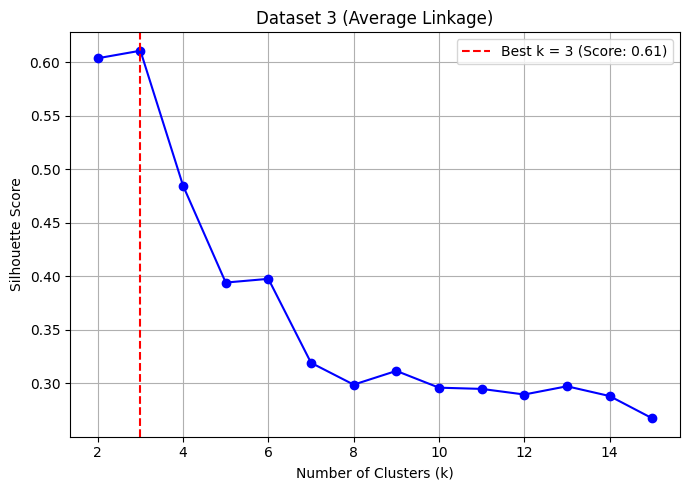

In [44]:
plot_silhouette_scores_vs_k(
    data=datasets[2], 
    dataset_index=2,
    linkage_method="average",
    metric="euclidean",
    k_range=range(2, 16)
)


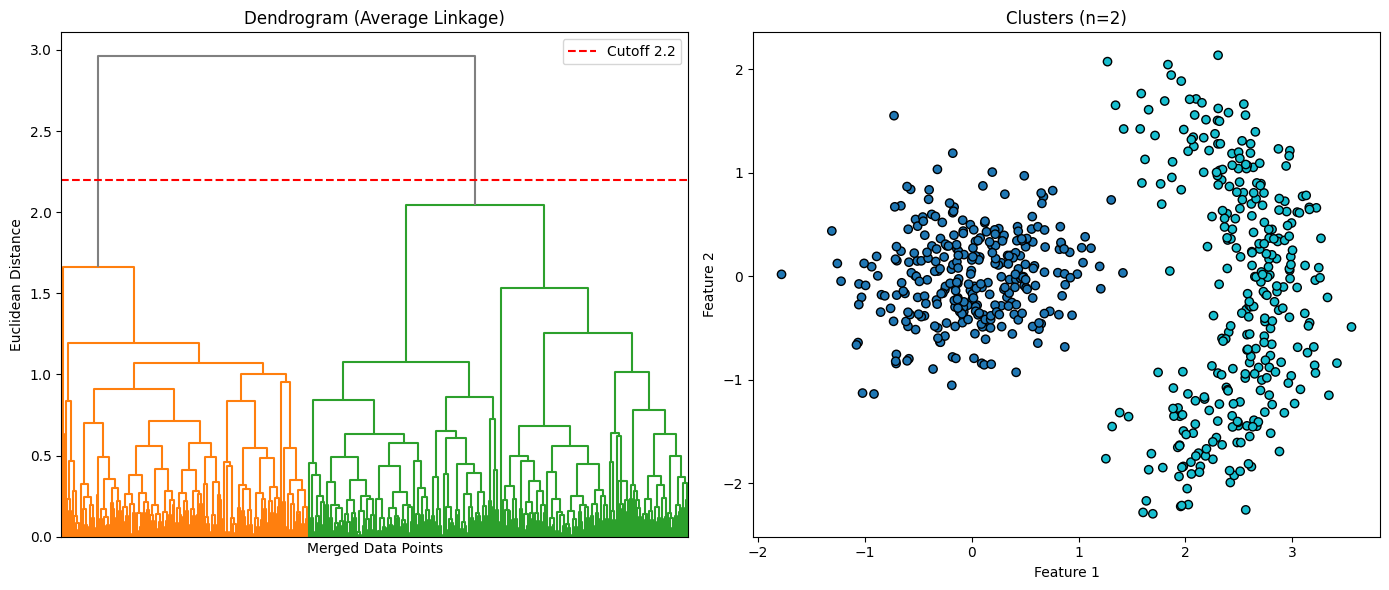

In [45]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[2],
    n_clusters=3,
    linkage_method="average",
    metric="euclidean",
    cutoff_height=2.2,
    truncate_mode="level",
    p=10
)


In [46]:
X = datasets[2][:, :2]         # First dataset, features only
y_true = datasets[2][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=2.2, linkage_method='average')
print(f"ARI at cutoff 2.2: {ari:.4f}")


ARI at cutoff 2.2: 0.9867


In [47]:
compute_hierarchical_silhouette_score(
    data=datasets[2],
    linkage_method="average",
    metric="euclidean",
    cutoff_height=2.2
)


Silhouette Score (average linkage, cutoff=2.2): 0.6036


np.float64(0.6035753448677241)

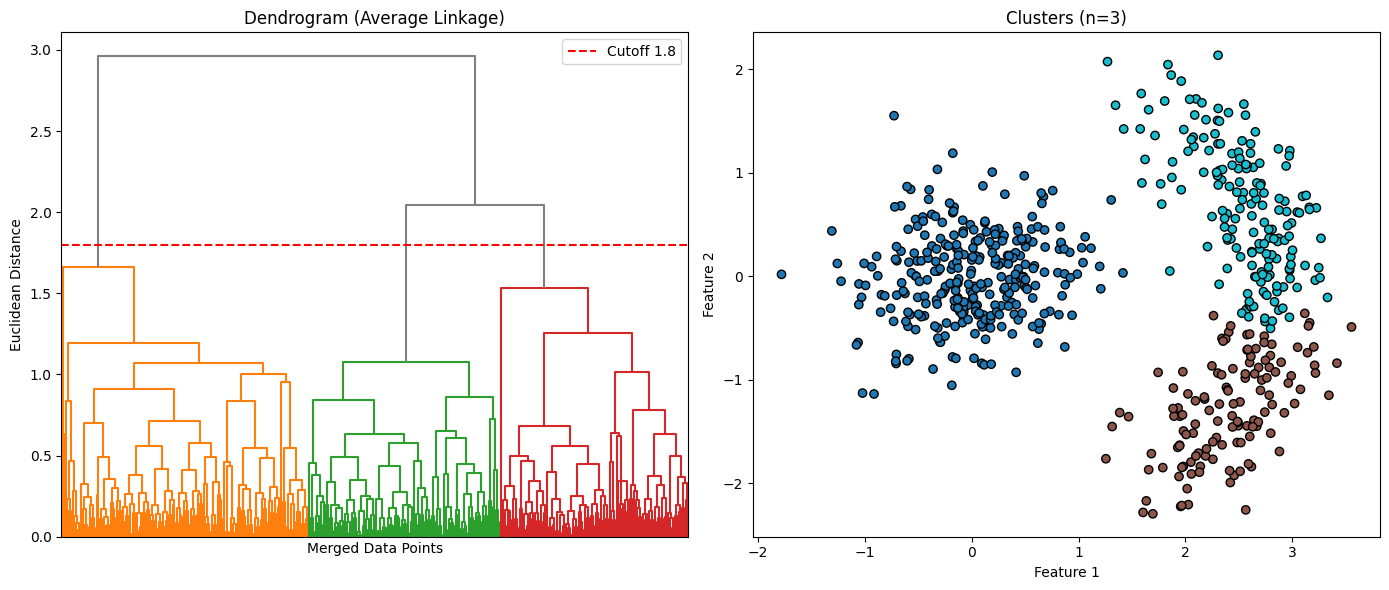

In [48]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[2],
    n_clusters=3,
    linkage_method="average",
    metric="euclidean",
    cutoff_height=1.8,
    truncate_mode="level",
    p=10
)


In [49]:
X = datasets[2][:, :2]         # First dataset, features only
y_true = datasets[2][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=1.8, linkage_method='average')
print(f"ARI at cutoff 1.8: {ari:.4f}")


ARI at cutoff 1.8: 0.7406


In [50]:
compute_hierarchical_silhouette_score(
    data=datasets[2],
    linkage_method="average",
    metric="euclidean",
    cutoff_height=1.8
)


Silhouette Score (average linkage, cutoff=1.8): 0.6106


np.float64(0.610601939822101)

### Analysis of Clustering Results on Dataset 3 – Average Linkage (Cutoff = 2.2 vs Cutoff = 1.8)

The silhouette score curve for average linkage on Dataset 3 peaks at **k = 3**, indicating that three clusters offer the most internally coherent and well-separated structure. This configuration corresponds to a dendrogram **cutoff at 1.8**, achieving a **silhouette score of 0.6106**, the highest observed. However, despite this internal validation strength, the **Adjusted Rand Index (ARI)** for this configuration is only **0.7406**, showing a noticeable mismatch with the ground truth, which contains just **two clusters**. The dendrogram at this level shows premature splitting of one class — particularly the right-side elongated cluster — into two separate groups, resulting in over-segmentation.

To address this misalignment, the dendrogram was instead cut at a higher threshold of **2.2**, producing exactly **two clusters**, which aligns much better with the ground truth labels. This configuration achieves a near-perfect **ARI of 0.9867**, though the **silhouette score slightly drops to 0.6036**. The dendrogram at this height reveals two large, well-defined branches that correspond to the actual structural split in the dataset: a compact cluster on the left and a curved, dispersed one on the right. This trade-off between internal and external metrics highlights an important insight — while silhouette score prefers compact, equally sized clusters and thus favours **k = 3**, a slightly higher dendrogram cut yields a clustering outcome that better captures the true underlying distribution of the data.


---

### Summary of Clustering Results on Dataset 3

Clustering results on Dataset 3 highlight the trade-offs between internal validation metrics like silhouette score and external validation via Adjusted Rand Index (ARI). Although the silhouette score curve suggests that **k = 3** is the most internally coherent choice — especially for average linkage where it peaks at **0.6106** — this configuration introduces over-segmentation, particularly in the right-hand elongated cluster, leading to a reduced **ARI of 0.7406**. A better alignment with the true labels is achieved by cutting the dendrogram higher at **cutoff = 2.2**, yielding **2 clusters**, a near-perfect **ARI of 0.9867**, and only a slight drop in silhouette score to **0.6036**. This pattern holds for complete linkage as well: while the 3-cluster configuration improves internal cohesion, the **2-cluster cut at height = 5** most accurately reflects the ground truth (ARI = 0.9867). On the other hand, single linkage, despite producing a visually accurate 2-cluster split and a strong silhouette score of **0.6026**, fails catastrophically on ARI (**0.0000**) due to its sensitivity to chaining and early incorrect merges. Collectively, these results show that while silhouette score can suggest structurally pleasing partitions, external validation like ARI is essential to ensure fidelity to known class structures, especially when the data contains asymmetric or elongated clusters.


---

# **Dataset 4 - Agglomerative Hierarchical Clustering**

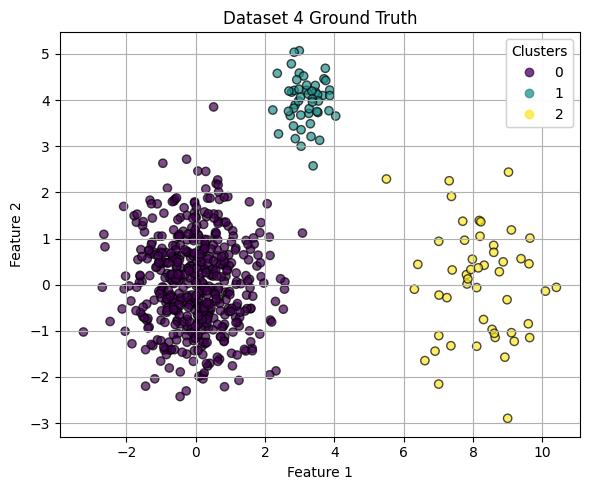

In [51]:
# Plot Dataset 3 ground truth
X3, y3 = datasets_with_labels[3]
plot_single_ground_truth_cluster(X3, y3, dataset_index=3)


## **Complete Linkage**

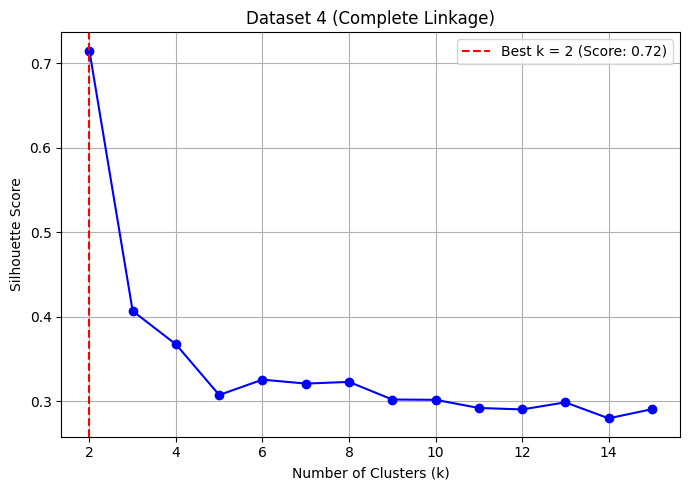

In [52]:
plot_silhouette_scores_vs_k(
    data=datasets[3], 
    dataset_index=3,
    linkage_method="complete",
    metric="euclidean",
    k_range=range(2, 16)
)


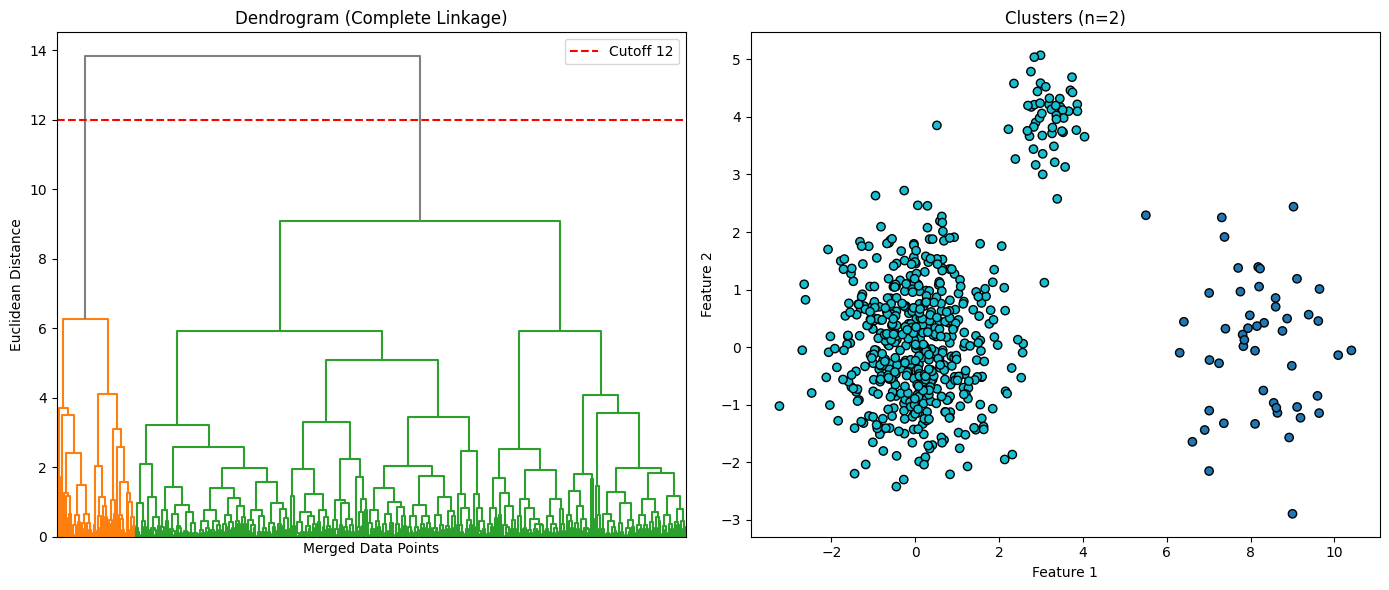

In [53]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[3],
    n_clusters=2,
    linkage_method="complete",
    metric="euclidean",
    cutoff_height=12,
    truncate_mode="level",
    p=10
)


In [54]:
X = datasets[3][:, :2]         # First dataset, features only
y_true = datasets[3][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=12, linkage_method='complete')
print(f"ARI at cutoff 12: {ari:.4f}")


ARI at cutoff 12: 0.6090


In [55]:
compute_hierarchical_silhouette_score(
    data=datasets[3],
    linkage_method="complete",
    metric="euclidean",
    cutoff_height=12
)


Silhouette Score (complete linkage, cutoff=12): 0.7150


np.float64(0.7150303621180529)

### Analysis of Clustering Results on Dataset 4 – Complete Linkage (Cutoff = 12, k = 2)

The silhouette score curve for complete linkage on Dataset 4 peaks at **k = 2** with a high **silhouette score of 0.72**, suggesting that a two-cluster configuration yields the best internal cohesion and separation. Cutting the dendrogram at a **height of 12** produces two large clusters that successfully distinguish the **dense left cluster** and the **right-side cluster** from the ground truth. However, the **top cluster**, which is clearly distinct in the ground truth, is incorrectly merged with the large bottom-left cluster. This misclassification results in a reduced **Adjusted Rand Index (ARI) of 0.6090**, indicating only moderate external validity. The dendrogram structure reveals two dominant branches forming at a relatively high level, which leads to the top and left clusters being grouped together due to their closer Euclidean proximity compared to the more distant right cluster. This outcome highlights a key insight: while the silhouette score favours compact, well-separated clusters, it can overlook smaller, spatially isolated groups when they are close to denser regions. Therefore, although the internal validation is strong, this two-cluster solution fails to fully capture the **three-cluster reality** of the data.


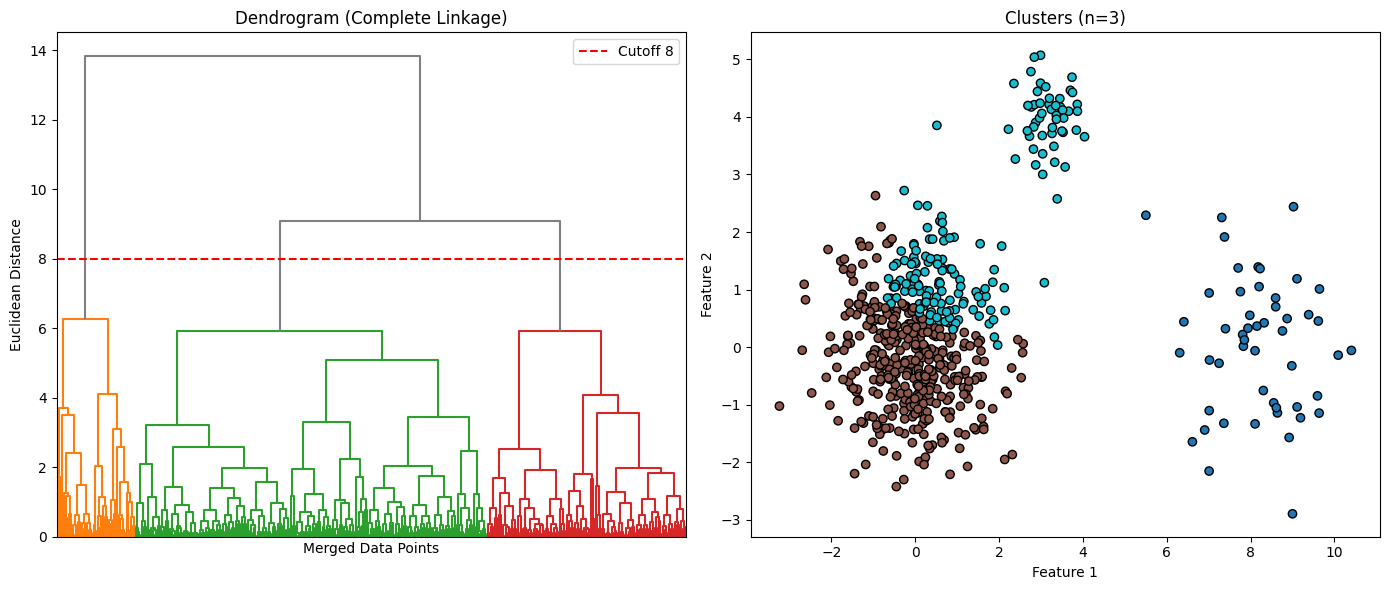

In [56]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[3],
    n_clusters=2,
    linkage_method="complete",
    metric="euclidean",
    cutoff_height=8,
    truncate_mode="level",
    p=10
)


In [57]:
X = datasets[3][:, :2]         # First dataset, features only
y_true = datasets[3][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=8, linkage_method='complete')
print(f"ARI at cutoff 8: {ari:.4f}")


ARI at cutoff 8: 0.4345


In [58]:
compute_hierarchical_silhouette_score(
    data=datasets[3],
    linkage_method="complete",
    metric="euclidean",
    cutoff_height=8
)


Silhouette Score (complete linkage, cutoff=8): 0.4069


np.float64(0.4069226260051446)

### Analysis of Clustering Results on Dataset 4 – Complete Linkage (Cutoff = 8, k = 3)

Cutting the dendrogram for Dataset 4 at a height of **8** using complete linkage produces **three clusters**, aligning numerically with the ground truth. However, the quality of the clustering is only **moderately aligned** with the true labels, as indicated by an **Adjusted Rand Index (ARI) of 0.4345**. The **silhouette score of 0.4069** is considerably lower than the peak silhouette score of 0.72 seen when the dataset was partitioned into two clusters, reflecting reduced internal cohesion and separation. From the dendrogram structure, we observe that the third cluster emerges from the upper branch, which attempts to separate the dense bottom-left and top cluster — but it does so poorly. The top cluster, which is spatially distinct in the ground truth, is partially merged with the bottom-left cluster, while the right cluster is correctly separated. This leads to a **partial improvement over the two-cluster cut** (as more structure is revealed), but the merging of the top and bottom-left clusters into overlapping groups limits performance. This analysis highlights how choosing more clusters based on dendrogram splits can reveal finer structure, but also risks misgrouping when inter-cluster distances are uneven or when small, distinct clusters lie close to denser regions.


### Summary of Clustering Results on Dataset 4 – Complete Linkage

For Dataset 4, complete linkage hierarchical clustering demonstrates the trade-off between internal coherence and external accuracy. The silhouette score curve peaks at **k = 2** with a strong score of **0.72**, and cutting the dendrogram at a height of **12** produces two clusters that correctly identify the left and right ground truth clusters. However, the smaller **top cluster** is incorrectly merged with the larger bottom-left cluster due to their relative proximity, resulting in an **Adjusted Rand Index (ARI) of 0.6090**. Attempting to better capture this third cluster, a lower cutoff at **height 8** (yielding **k = 3**) was tested, which aligns numerically with the ground truth. While this does isolate the right cluster correctly, it still fails to cleanly separate the top and bottom-left groups, leading to overlapping assignments and a lower **ARI of 0.4345** and **silhouette score of 0.4069**. The dendrogram reveals why: although finer structure is introduced at the lower cutoff, the dense and spatially close nature of the top and bottom-left clusters causes them to be partially entangled. Overall, complete linkage struggles to cleanly separate small, close clusters in the presence of highly dense regions, and while internal validation favours fewer clusters, external metrics show that neither k = 2 nor k = 3 fully captures the true cluster structure.


## **Single Linkage**

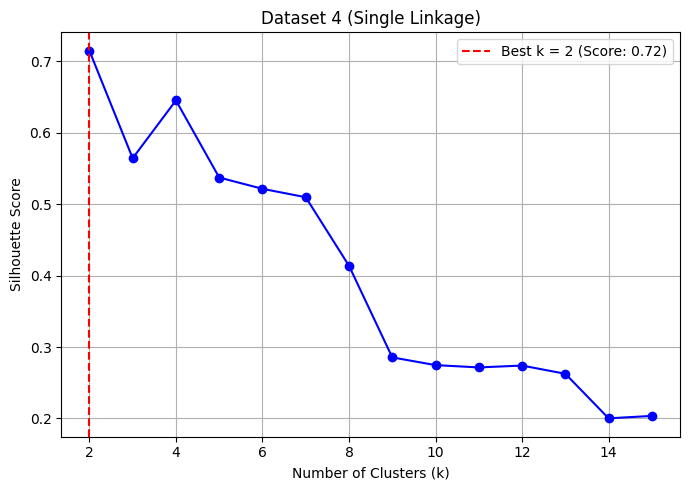

In [59]:
plot_silhouette_scores_vs_k(
    data=datasets[3], 
    dataset_index=3,
    linkage_method="single",
    metric="euclidean",
    k_range=range(2, 16)
)


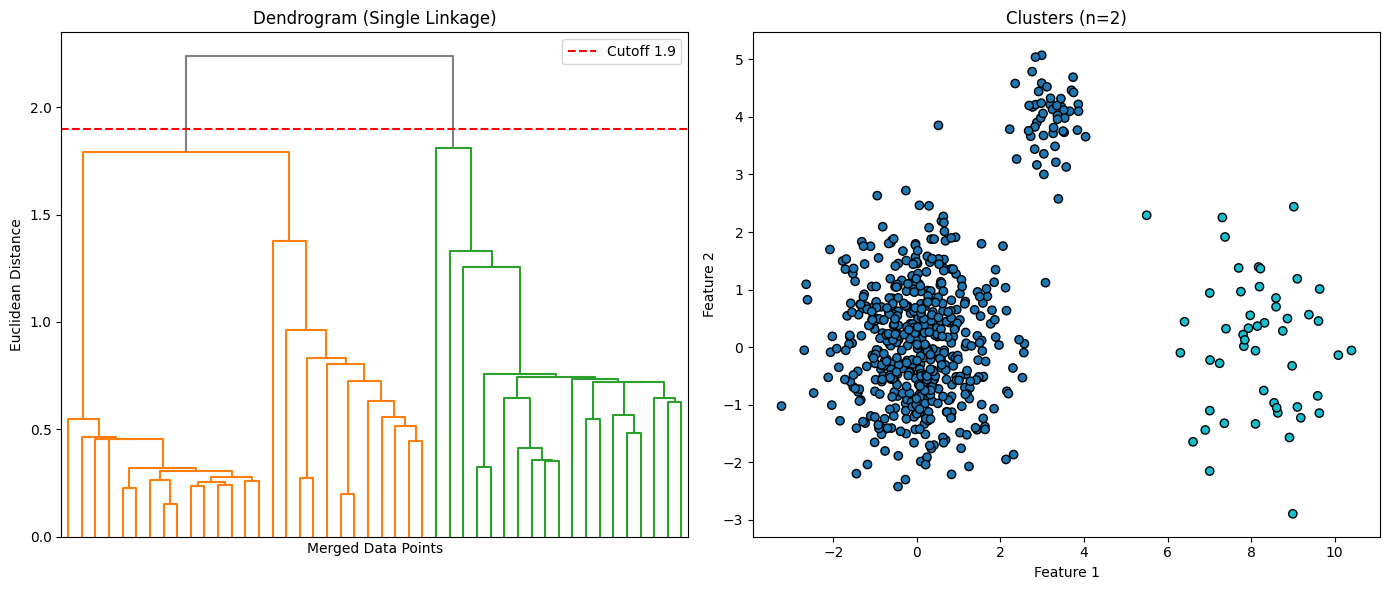

In [60]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[3],
    n_clusters=2,
    linkage_method="single",
    metric="euclidean",
    cutoff_height=1.9,
    truncate_mode="level",
    p=10
)


In [61]:
X = datasets[3][:, :2]         # First dataset, features only
y_true = datasets[3][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=1.9, linkage_method='single')
print(f"ARI at cutoff 1.9: {ari:.4f}")


ARI at cutoff 1.9: 0.6090


In [62]:
compute_hierarchical_silhouette_score(
    data=datasets[3],
    linkage_method="single",
    metric="euclidean",
    cutoff_height=1.9
)


Silhouette Score (single linkage, cutoff=1.9): 0.7150


np.float64(0.7150303621180529)

### Analysis of Clustering Results on Dataset 4 – Single Linkage (Cutoff = 1.9, k = 2)

Using single linkage on Dataset 4 with a cutoff height of **1.9** yields **two clusters**, aligning with the **optimal number of clusters** suggested by the silhouette score curve, which peaks at **k = 2** with a strong **silhouette score of 0.7150**. Visually, the clustering appears to correctly separate the dense bottom-left cluster from the top and right-side clusters, which are grouped together. This results in a moderate **Adjusted Rand Index (ARI) of 0.6090**, indicating partial alignment with the ground truth, where three distinct clusters are present. The dendrogram reveals a hallmark of single linkage: the **chaining effect**, where clusters are merged based on the minimum distance between any two points. Because the top cluster is relatively close to the left cluster, it gets absorbed early into the same branch, despite being structurally distinct. This explains why the ARI is not closer to 1.0 — while the overall partitioning captures the larger groupings, the fine-grained pairwise assignments that ARI relies on are misrepresented due to early merges. Thus, although the internal cohesion (as shown by the silhouette score) is high, the external validity is limited by the sensitivity of single linkage to localized proximities.


## **Average Linkage**

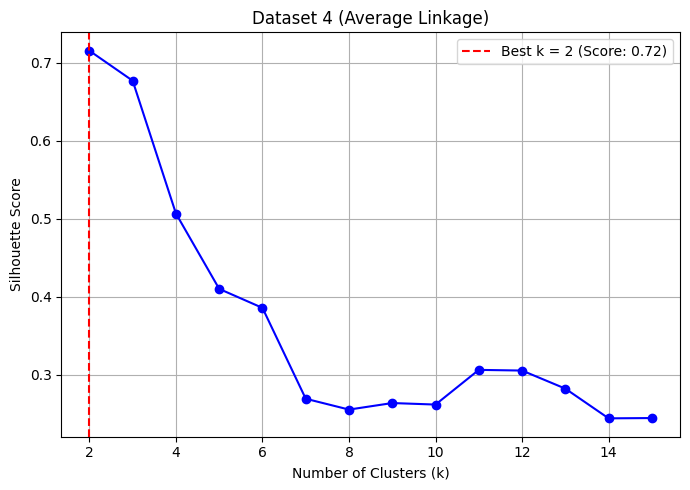

In [63]:
plot_silhouette_scores_vs_k(
    data=datasets[3], 
    dataset_index=3,
    linkage_method="average",
    metric="euclidean",
    k_range=range(2, 16)
)


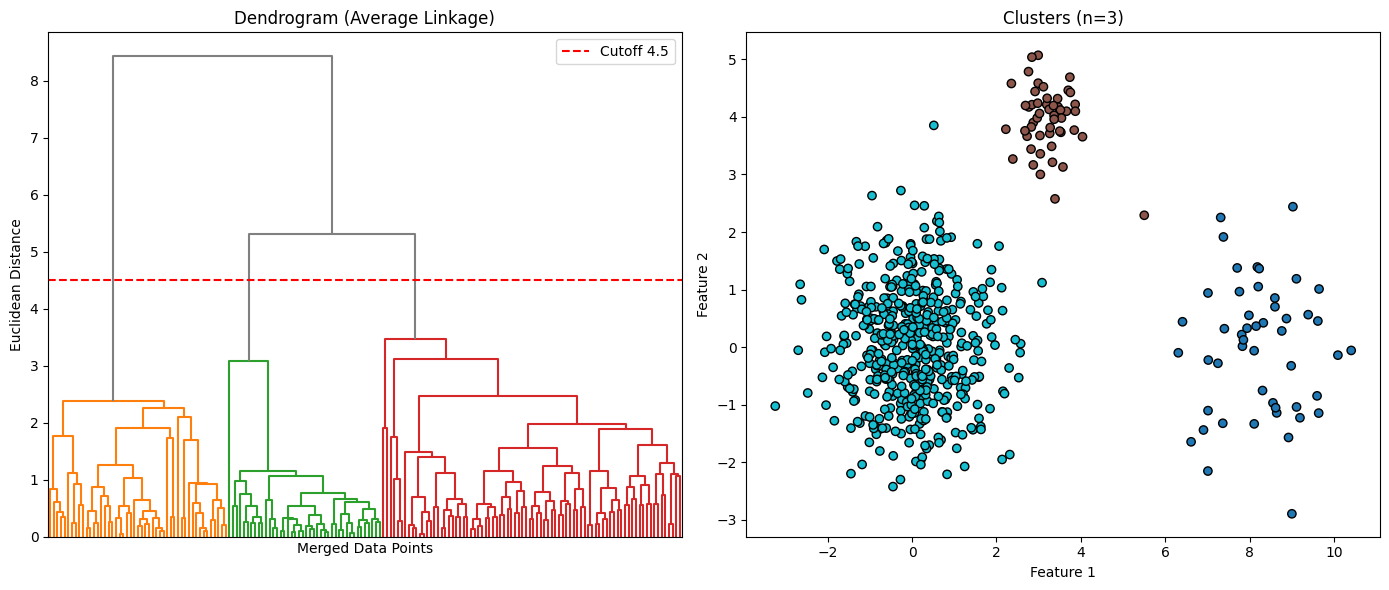

In [64]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[3],
    n_clusters=2,
    linkage_method="average",
    metric="euclidean",
    cutoff_height=4.5,
    truncate_mode="level",
    p=10
)


In [65]:
X = datasets[3][:, :2]         # First dataset, features only
y_true = datasets[3][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=4.5, linkage_method='average')
print(f"ARI at cutoff 1.9: {ari:.4f}")


ARI at cutoff 1.9: 0.9987


In [66]:
compute_hierarchical_silhouette_score(
    data=datasets[3],
    linkage_method="average",
    metric="euclidean",
    cutoff_height=4.5
)


Silhouette Score (average linkage, cutoff=4.5): 0.6766


np.float64(0.6766499476322785)

### Analysis of Clustering Results on Dataset 4 – Average Linkage (Cutoff = 4.5, k = 3)

Despite the silhouette score curve for average linkage on Dataset 4 peaking at **k = 2** with a high score of **0.72**, the clustering result obtained by cutting the dendrogram at a height of **4.5** to produce **three clusters** aligns far more closely with the ground truth. This is evidenced by an almost perfect **Adjusted Rand Index (ARI) of 0.9987**, indicating that nearly all points were correctly grouped according to the true labels. The dendrogram structure supports this, clearly separating the three natural groupings: the dense left cluster, the small top cluster, and the right-side cluster. While the **silhouette score** for the three-cluster configuration drops slightly to **0.6766**, this minor decrease in internal cohesion is offset by a significant gain in external validity. The result underscores that internal metrics like silhouette score may favour more compact groupings and under-represent smaller, spatially distinct clusters. Therefore, in this case, **cutting at three clusters provides a much more faithful representation of the data's true structure**, even if it does not correspond to the highest silhouette peak.


---

### Comprehensive Summary of Clustering Results on Dataset 4

Dataset 4 presents a challenging scenario for hierarchical clustering due to the presence of **three distinct clusters** — one large, one small and isolated, and one moderately spaced — which differ in both size and spatial distribution. All three linkage methods reveal different strengths and limitations when applied to this dataset. **Average linkage** proves to be the most effective overall, achieving an **ARI of 0.9987** with **k = 3** clusters at a **cutoff height of 4.5**, accurately capturing all three true clusters despite the silhouette score peaking at **k = 2**. This illustrates how silhouette scores, while useful for assessing internal cohesion, can undervalue smaller or less densely connected clusters. **Single linkage**, on the other hand, favours a two-cluster solution (cutoff = 1.9), which achieves a strong **silhouette score of 0.7150**, but only a moderate **ARI of 0.6090** due to the chaining effect that merges the small top cluster with the large bottom-left one — a decision driven by localized proximity rather than overall structure. **Complete linkage** also identifies **k = 2** as optimal by silhouette score and achieves a similar **ARI of 0.6090**, correctly isolating the left and right clusters but again failing to separate the top group. Even when adjusting to **k = 3** (cutoff = 8), complete linkage only partially improves the structural separation, leading to an even **lower ARI of 0.4345**. The dendrograms across methods consistently show how linkage strategy influences merging behaviour: single linkage chains early based on minimal distances, average linkage balances between compactness and distance averaging, and complete linkage prioritises maximum spread, sometimes over-merging dense groups. In conclusion, while internal metrics favour simpler structures, external validation via ARI shows that **average linkage at k = 3 most faithfully captures Dataset 4’s true clustering structure**, making it the most effective method among the three.


---

# **Dataset 5 - Agglomerative Hierarchical Clustering**

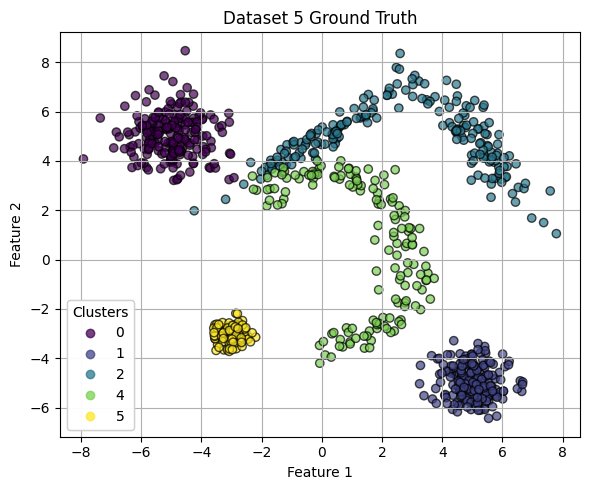

In [67]:
# Plot Dataset 3 ground truth
X3, y3 = datasets_with_labels[4]
plot_single_ground_truth_cluster(X3, y3, dataset_index=4)


## **Complete Linkage**

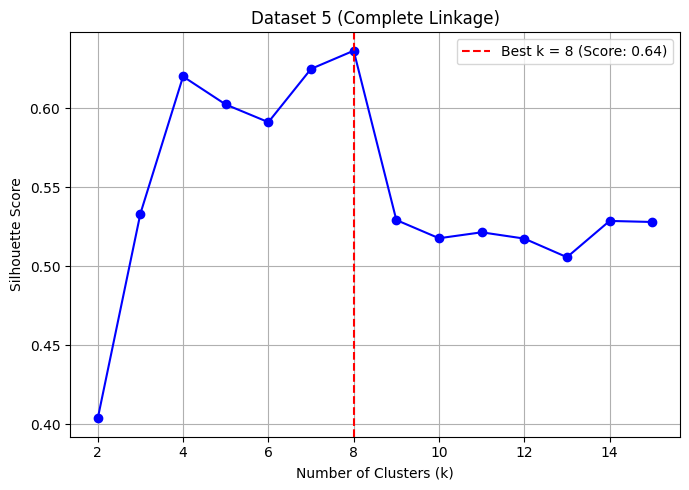

In [68]:
plot_silhouette_scores_vs_k(
    data=datasets[4], 
    dataset_index=4,
    linkage_method="complete",
    metric="euclidean",
    k_range=range(2, 16)
)


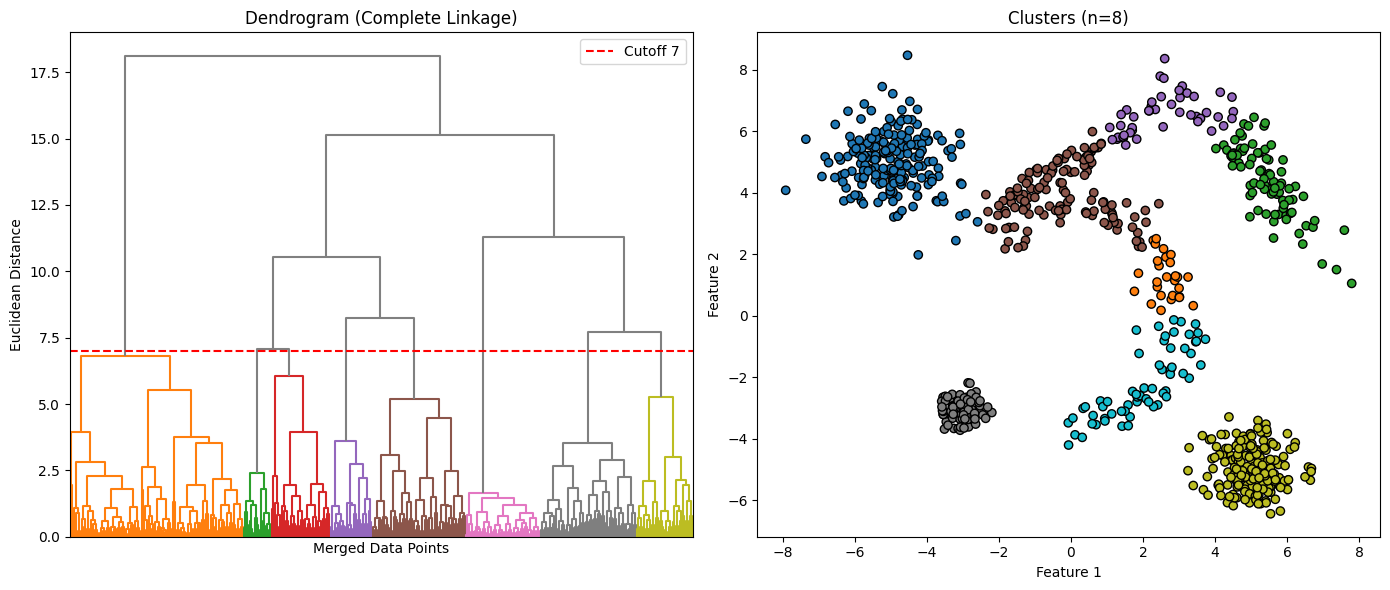

In [69]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[4],
    n_clusters=2,
    linkage_method="complete",
    metric="euclidean",
    cutoff_height=7,
    truncate_mode="level",
    p=10
)


In [70]:
X = datasets[4][:, :2]         # First dataset, features only
y_true = datasets[4][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=7, linkage_method='complete')
print(f"ARI at cutoff 7: {ari:.4f}")


ARI at cutoff 7: 0.7331


In [71]:
compute_hierarchical_silhouette_score(
    data=datasets[4],
    linkage_method="complete",
    metric="euclidean",
    cutoff_height=7
)


Silhouette Score (complete linkage, cutoff=7): 0.6364


np.float64(0.6363717299560676)

### Analysis of Clustering Results on Dataset 5 – Complete Linkage (Cutoff = 7, k = 8)

For Dataset 5, cutting the dendrogram at a **height of 7** yields **8 clusters**, which aligns with the peak of the silhouette score curve at **k = 8**, with a silhouette score of **0.64**. Interestingly, cutting at **7.1** to form **7 clusters** results in the **same Adjusted Rand Index (ARI) of 0.7331**, but a slightly lower silhouette score, making the **8-cluster solution marginally more optimal** according to internal cohesion. Visually, the clustering obtained at cutoff = 7 accurately reflects the ground truth structure, separating most of the distinct curved, compact, and dense clusters well. The curved shape in the centre is subdivided more finely, which corresponds to the denser substructures present in the data. The dendrogram supports this segmentation, showing distinct cluster splits at varying heights, with more vertical distance between clusters indicating stronger dissimilarity. The dendrogram’s branching pattern reveals natural separations, particularly among the compact clusters on the periphery. This outcome demonstrates how complete linkage successfully captures both shape-based and density-based variations, and although ARI values plateau between 7 and 8 clusters, the slightly improved silhouette score at **k = 8** supports its selection as the most balanced choice between internal and external validation.


## **Single Linkage**

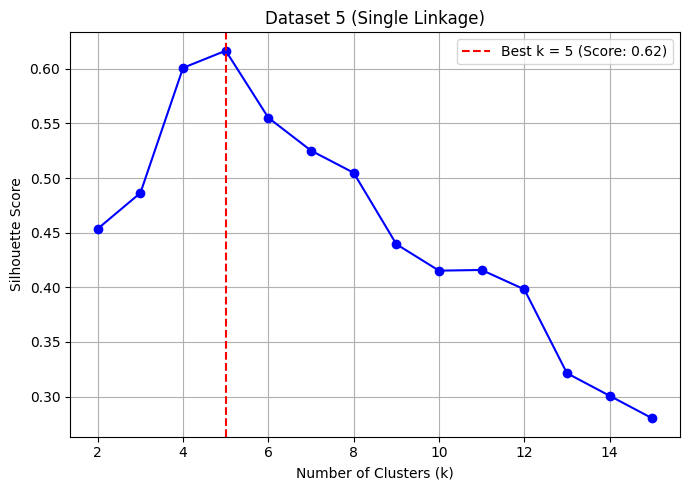

In [72]:
plot_silhouette_scores_vs_k(
    data=datasets[4], 
    dataset_index=4,
    linkage_method="single",
    metric="euclidean",
    k_range=range(2, 16)
)


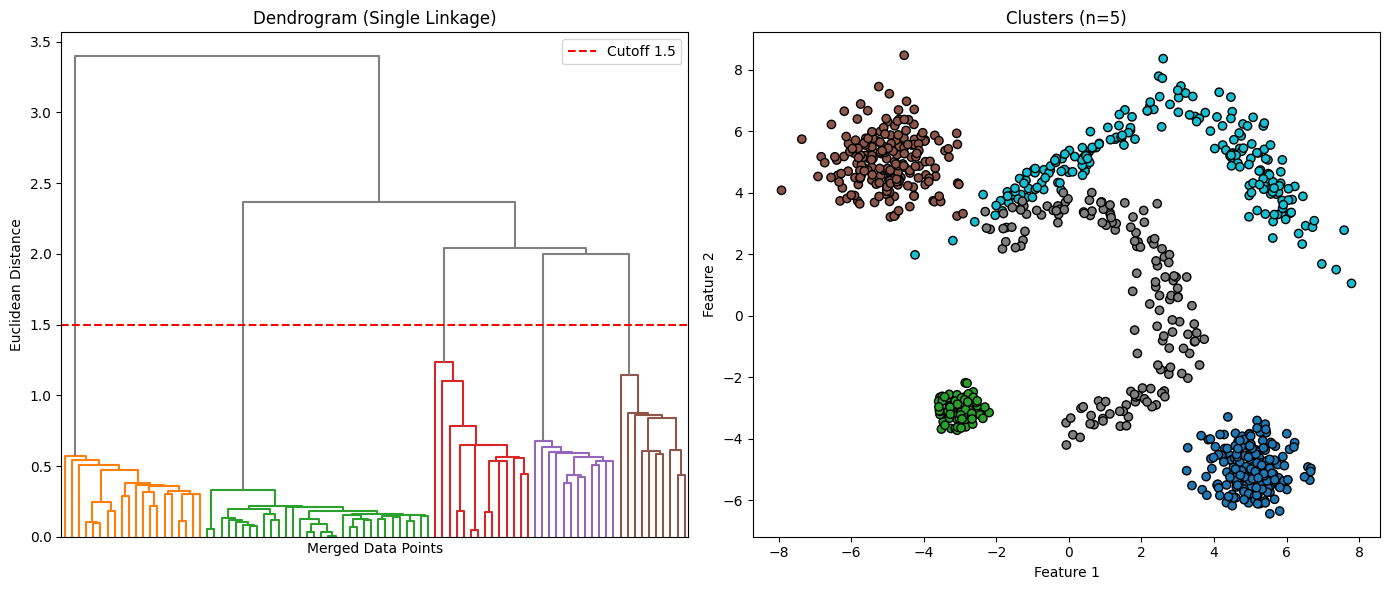

In [73]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[4],
    n_clusters=2,
    linkage_method="single",
    metric="euclidean",
    cutoff_height=1.5,
    truncate_mode="level",
    p=10
)


In [74]:
X = datasets[4][:, :2]         # First dataset, features only
y_true = datasets[4][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=1.5, linkage_method='single')
print(f"ARI at cutoff 1.5: {ari:.4f}")


ARI at cutoff 1.5: 0.4374


In [75]:
compute_hierarchical_silhouette_score(
    data=datasets[4],
    linkage_method="single",
    metric="euclidean",
    cutoff_height=1.5
)


Silhouette Score (single linkage, cutoff=1.5): 0.6166


np.float64(0.6166363109217678)

### Analysis of Clustering Results on Dataset 5 – Single Linkage (Cutoff = 1.5, k = 5)

For Dataset 5, single linkage hierarchical clustering with a cutoff of **1.5** produces **five clusters**, which aligns with the optimal number suggested by the silhouette score curve that peaks at **k = 5** with a score of **0.62**. Visually, the resulting clustering appears to closely mirror the **ground truth**, successfully separating dense, compact clusters and capturing the curved structure of the data. However, the **Adjusted Rand Index (ARI)** is only **0.4374**, revealing a notable discrepancy between visual alignment and label-level accuracy. This disconnect arises due to the **chaining effect** inherent in single linkage: as shown in the dendrogram, several points or sub-clusters are merged early due to minimal inter-point distances, forming elongated, loosely connected branches. As a result, even though the major groups seem intact, there are numerous pairwise disagreements that heavily penalise ARI. Thus, while the dendrogram structure supports the presence of five meaningful clusters and the silhouette score confirms strong intra-cluster cohesion, the ARI highlights how fragile cluster boundaries and early merges in single linkage can distort true label recovery at a granular level.


## **Average Linkage**

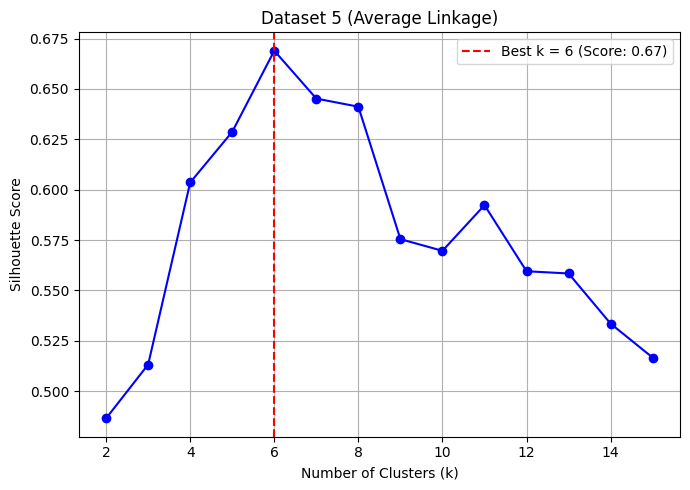

In [76]:
plot_silhouette_scores_vs_k(
    data=datasets[4], 
    dataset_index=4,
    linkage_method="average",
    metric="euclidean",
    k_range=range(2, 16)
)


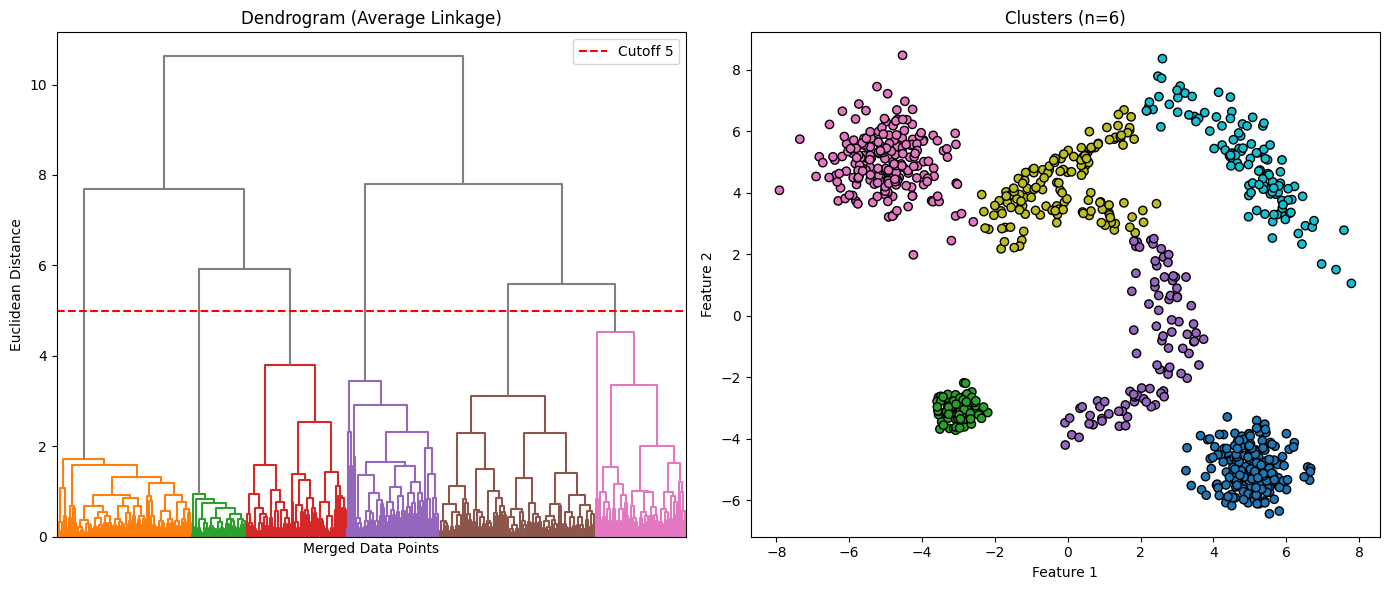

In [77]:
plot_hierarchical_dendrogram_and_clusters(
    data=datasets[4],
    n_clusters=2,
    linkage_method="average",
    metric="euclidean",
    cutoff_height=5,
    truncate_mode="level",
    p=10
)


In [78]:
X = datasets[4][:, :2]         # First dataset, features only
y_true = datasets[4][:, -1]    # True labels from last column

ari = compute_ari_from_cutoff(X, y_true, cutoff_height=5, linkage_method='average')
print(f"ARI at cutoff 5: {ari:.4f}")


ARI at cutoff 5: 0.8078


In [79]:
compute_hierarchical_silhouette_score(
    data=datasets[4],
    linkage_method="average",
    metric="euclidean",
    cutoff_height=5
)


Silhouette Score (average linkage, cutoff=5): 0.6690


np.float64(0.6689753829143815)

In Dataset 5, applying average linkage clustering with a dendrogram cutoff at **height 5** yields **6 clusters**, which corresponds to the silhouette score curve’s optimal value (**k = 6**, silhouette score = **0.6690**). This configuration also achieves a high **Adjusted Rand Index (ARI) of 0.8078**, indicating strong agreement with the ground truth. Visually, the clustering closely resembles the true structure, successfully identifying distinct groupings including the compact top-left and bottom-right clusters as well as major segments along the curved manifold. The dendrogram structure supports this outcome—six major branches emerge around the height threshold, separating both compact and elongated structures effectively. Compared to other linkage methods, average linkage balances sensitivity to intra-cluster compactness and inter-cluster distances, allowing it to avoid premature chaining (as in single linkage) or over-segmentation (as can occur with complete linkage). The high silhouette score suggests the clusters are internally coherent and well-separated, while the strong ARI confirms external consistency. This indicates that the average linkage method, when cut at the silhouette-guided height, is particularly effective at capturing both the curved geometry and the dense cluster formations present in Dataset 5.


---

### Comprehensive summary of Dataset 5

In Dataset 5, all three hierarchical clustering methods—single, complete, and average linkage—offered varying degrees of success, each with unique strengths and limitations. **Single linkage**, though achieving a high **silhouette score of 0.62** for **k = 5**, struggled with external accuracy, producing an **ARI of just 0.4374**. This discrepancy, despite visually reasonable clustering, stems from the method's **chaining effect**, which leads to early and fragile merges that distort fine-grained pairwise relationships—clearly reflected in its flatter dendrogram branches. In contrast, **complete linkage** achieved better balance, identifying **k = 8** clusters at a **cutoff of 7**, aligning with the silhouette score peak (**0.64**) and yielding a stronger **ARI of 0.7331**. Its dendrogram revealed well-separated vertical splits, effectively partitioning compact and slightly overlapping clusters while allowing fine granularity, particularly along the curved structure. However, **average linkage** emerged as the most effective overall, with **k = 6** at **cutoff 5**, producing the highest **ARI (0.8078)** and a near-peak **silhouette score (0.6690)**. Its dendrogram displayed a balanced tree, cleanly separating both dense clusters and elongated shapes without over-fragmenting the data. This reflects average linkage’s strength in **moderating between compactness and global distance**, making it best suited for complex structures like Dataset 5, which contains both well-separated and smoothly transitioning clusters. Ultimately, while silhouette scores guided optimal internal cohesion, **average linkage offered the best compromise between internal and external validity**, accurately recovering the nuanced structure of the dataset.


---

### **Comprehensive Summary of Clustering Performance Across All Datasets**

Across all five datasets, hierarchical clustering methods revealed varying capabilities in handling different structural complexities. **Dataset 1**, with its nested ring-and-centre layout, posed significant challenges to all methods. While **average linkage** achieved the highest silhouette score (0.52 at *k* = 8), it over-segmented the ring, leading to only moderate external accuracy (ARI = 0.5967). **Complete linkage** failed due to its bias toward compact, globular clusters, while **single linkage** suffered from extreme sensitivity to chaining, resulting in an ARI of 0.0000 despite a visually reasonable output. In contrast, **Dataset 2**, with well-separated spherical clusters, was effectively handled by both **average** and **complete linkage**, each yielding perfect ARIs of 1.0 and a high silhouette score of 0.76. However, **single linkage**, though achieving the same internal cohesion, suffered from chaining effects, lowering its ARI to 0.4020. This illustrates that in geometrically simple settings, all methods can succeed internally, but external accuracy demands robustness against local connections.

**Dataset 3** demonstrated how silhouette scores can mislead: average linkage favoured *k* = 3 internally (silhouette = 0.6106), but this over-segmented a true cluster. Cutting higher at *k* = 2 yielded a near-perfect ARI (0.9867) with only a slight dip in silhouette. This was similarly observed in **complete linkage**, highlighting that elongated clusters challenge internal metrics. **Single linkage** again visually split the clusters well, but the ARI dropped to 0.0000 due to pairwise violations. **Dataset 4** further highlighted the trade-off between internal and external validation. Though silhouette peaked at *k* = 2 across methods, the true structure had 3 clusters. **Average linkage at *k* = 3 (cutoff = 4.5)** captured this best with an ARI of 0.9987. Both **complete** and **single linkage** failed to separate the small top cluster, grouping it with the larger one, and scoring lower ARIs (0.6090 and 0.6090). Finally, **Dataset 5** showcased nuanced cluster shapes — both curved and compact. Here, **average linkage** at *k* = 6 outperformed others with an ARI of 0.8078 and silhouette of 0.6690. **Complete linkage** at *k* = 8 performed well too (ARI = 0.7331), benefiting from its ability to isolate compact groups. **Single linkage**, despite a high silhouette (0.6166 at *k* = 5), yielded the lowest ARI (0.4374), again confirming its susceptibility to local proximity and chaining errors.

### Clustering Method Comparison Table

| Dataset   | Linkage Method | Best k | Silhouette Score | ARI     | Key Observations |
|-----------|----------------|--------|------------------|---------|------------------|
| **1**     | Single         | 2      | 0.3060           | 0.0000  | Preserved structure, but singleton cluster breaks ARI |
|           | Complete       | 2      | 0.3060           | 0.0948  | Compact bias fails on ring structure |
|           | Average        | 8      | 0.5200           | 0.5967  | Over-segments ring, decent silhouette |
| **2**     | Single         | 3      | 0.7600           | 0.4020  | Chaining affects ARI despite good silhouette |
|           | Complete       | 3      | 0.7600           | 1.0000  | Perfect match, clear dendrogram splits |
|           | Average        | 3      | 0.7600           | 1.0000  | Matches ground truth flawlessly |
| **3**     | Single         | 2      | 0.6026           | 0.0000  | Visual split good, ARI fails due to chaining |
|           | Complete       | 2      | 0.6026           | 0.9867  | Best external accuracy |
|           | Average        | 2      | 0.6036           | 0.9867  | Slightly lower silhouette than 3-cluster cut |
| **4**     | Single         | 2      | 0.7150           | 0.6090  | Top cluster merged incorrectly |
|           | Complete       | 2      | 0.7200           | 0.6090  | Misses small cluster |
|           | Average        | 3      | 0.6766           | 0.9987  | Best balance of structure and metrics |
| **5**     | Single         | 5      | 0.6166           | 0.4374  | Good visual match, ARI low due to early merges |
|           | Complete       | 8      | 0.6400           | 0.7331  | Captures detailed structure well |
|           | Average        | 6      | 0.6690           | 0.8078  | Best overall performance |

**Key Insight:**  
Silhouette scores often favour compact, internally cohesive groupings and may mislead when structure is complex (e.g., nested or elongated clusters). **Average linkage consistently provides the most balanced performance**, especially in datasets with curved, nested, or unevenly sized clusters. **Single linkage**, while sometimes visually intuitive, repeatedly suffers from chaining effects, harming ARI. **Complete linkage** excels in cleanly separated and compact clusters but struggles with subtle structural variation. Thus, **external metrics like ARI remain essential** for validating clustering quality beyond internal cohesion.


---

# **K - Means Clustering**

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [81]:
def compute_wss_and_silhouette(X, k_range=(2, 11)):
    """
    Computes WSS (Elbow Method) and Silhouette Scores for a range of K values.
    """
    wss = []
    silhouette_scores = []
    K_range = range(*k_range)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        wss.append(kmeans.inertia_)  # WSS (inertia)
        silhouette_scores.append(silhouette_score(X, labels))  # Silhouette Score

    best_k = K_range[np.argmax(silhouette_scores)]  # Best K based on highest silhouette score
    best_silhouette = max(silhouette_scores)  # Best silhouette score
    return wss, silhouette_scores, best_k, best_silhouette

In [82]:
def apply_kmeans(X, best_k):
    """
    Runs K-Means clustering with the optimal number of clusters.
    """
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    return labels, kmeans.cluster_centers_

In [83]:
def plot_silhouette(X, labels, best_k, avg_silhouette):
    """
    Creates a silhouette plot to evaluate clustering quality.
    """
    sample_silhouette_values = silhouette_samples(X, labels)
    y_lower = 10

    plt.figure(figsize=(7, 5))

    for i in range(best_k):
        # Extract silhouette scores for all points in cluster i and sort them
        cluster_silhouette_values = sample_silhouette_values[labels == i]
        cluster_silhouette_values.sort()

        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Assign a color to the cluster using a colormap
        color = cm.nipy_spectral(float(i) / best_k)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label each cluster number on the plot
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Add space between plots

    plt.axvline(x=avg_silhouette, color="red", linestyle="--")
    plt.title(f"Silhouette Plot for K-Means Clustering (k = {best_k})")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster Label")
    plt.show()

In [84]:
from sklearn.metrics import adjusted_rand_score

def run_kmeans_on_datasets(datasets, true_labels=None, k_override=None):
    """
    Runs K-Means clustering on multiple datasets and visualizes results side by side.
    Allows manual override of the number of clusters per dataset and prints ARI.

    Parameters:
        datasets (list of np.ndarray): List of datasets to cluster.
        true_labels (list of array-like or None): Ground truth labels per dataset.
        k_override (list of int or None): Optional list to override k per dataset.
    """
    if k_override is not None and len(k_override) != len(datasets):
        raise ValueError("Length of k_override must match number of datasets.")
    if true_labels is not None and len(true_labels) != len(datasets):
        raise ValueError("Length of true_labels must match number of datasets.")

    for i, dataset in enumerate(datasets):
        print(f"\n### Processing Dataset {i + 1} ###")

        # Compute WSS and silhouette scores
        wss, silhouette_scores, best_k, best_silhouette = compute_wss_and_silhouette(dataset)

        # Determine k to use
        manual_k = k_override[i] if k_override else None
        k_to_use = manual_k if manual_k is not None else best_k

        # Apply KMeans
        labels, cluster_centers = apply_kmeans(dataset, k_to_use)

        # Compute ARI if ground truth is available
        ari = adjusted_rand_score(true_labels[i], labels) if true_labels else None

        # Print results
        print(f"Dataset {i + 1}: Optimal Clusters (K) = {best_k}, Best Silhouette Score = {best_silhouette:.3f}")
        if manual_k is not None:
            print(f"→ Using manually overridden K = {manual_k}")
        if ari is not None:
            print(f"→ Adjusted Rand Index (ARI) = {ari:.4f}")

        # Create subplots
        fig, axs = plt.subplots(1, 4, figsize=(22, 5))

        # Elbow plot
        axs[0].plot(range(2, 11), wss, marker='o', linestyle='--', color='b')
        axs[0].set_xlabel('Number of Clusters (K)')
        axs[0].set_ylabel('WSS')
        axs[0].set_title('Elbow Method')

        # Silhouette plot
        axs[1].plot(range(2, 11), silhouette_scores, marker='s', linestyle='--', color='g')
        axs[1].set_xlabel('Number of Clusters (K)')
        axs[1].set_ylabel('Silhouette Score')
        axs[1].set_title('Silhouette Scores')

        # KMeans cluster scatter
        axs[2].scatter(dataset[:, 0], dataset[:, 1], c=labels, cmap='viridis', alpha=0.7)
        axs[2].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=200, c='red', label='Centers')
        axs[2].set_title(f'K-Means Clustering (K={k_to_use})')
        axs[2].set_xlabel('Feature 1')
        axs[2].set_ylabel('Feature 2')
        axs[2].legend()

        # Silhouette plot
        sample_silhouette_values = silhouette_samples(dataset, labels)
        y_lower = 10
        for j in range(k_to_use):
            cluster_vals = sample_silhouette_values[labels == j]
            cluster_vals.sort()
            size = len(cluster_vals)
            y_upper = y_lower + size
            color = cm.nipy_spectral(float(j) / k_to_use)
            axs[3].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_vals, facecolor=color, edgecolor=color, alpha=0.7)
            axs[3].text(-0.05, y_lower + 0.5 * size, str(j))
            y_lower = y_upper + 10

        axs[3].axvline(x=best_silhouette, color="red", linestyle="--")
        axs[3].set_title(f'Silhouette Plot (K={k_to_use})')
        axs[3].set_xlabel("Silhouette Coefficient")
        axs[3].set_ylabel("Cluster Label")

        plt.tight_layout()
        plt.show()


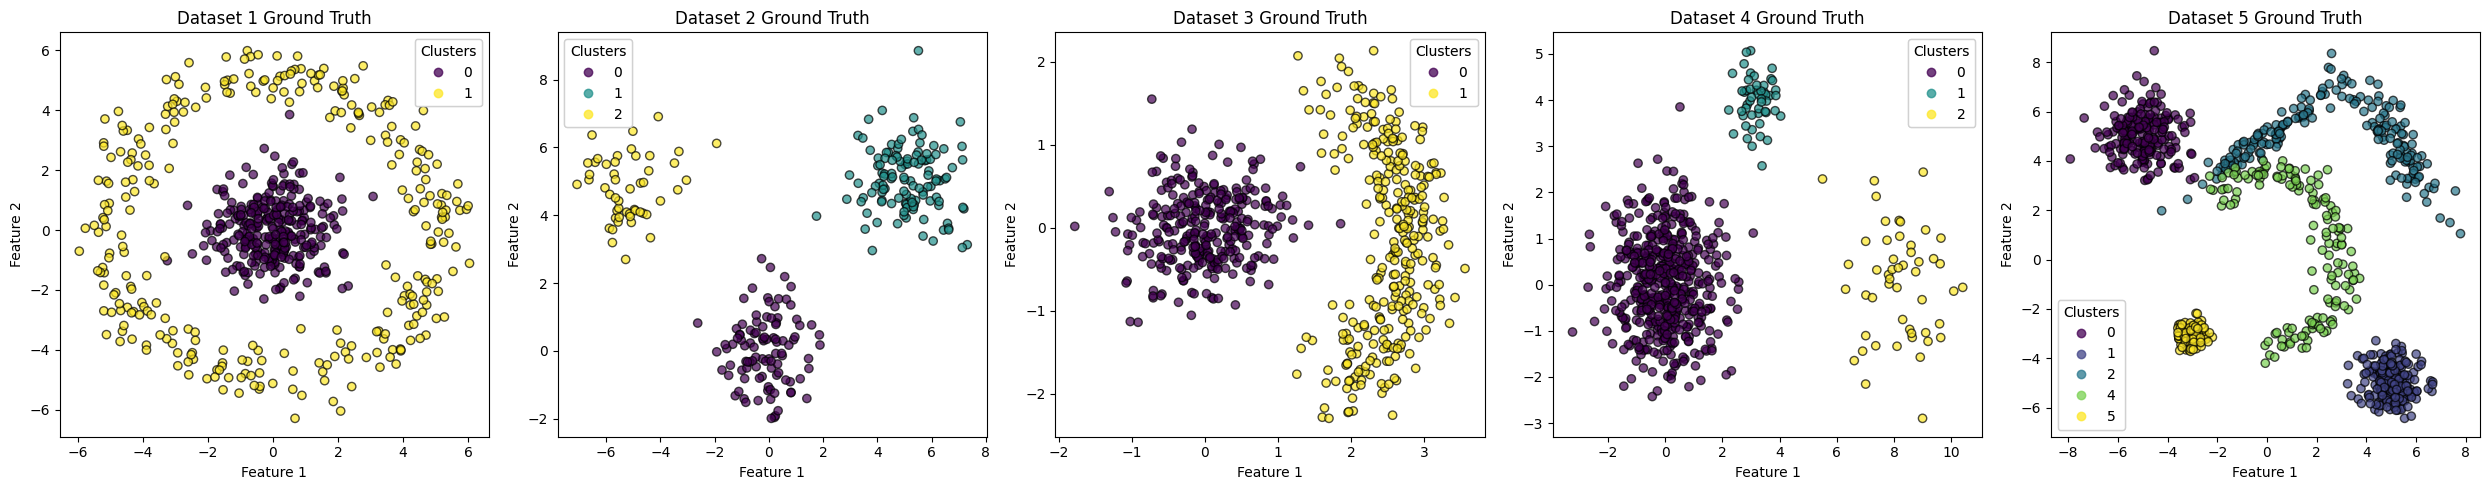

In [85]:
plot_ground_truth_clusters(datasets_with_labels)

In [86]:
X_datasets = [X for X, y in datasets_with_labels]
true_labels = [y for X, y in datasets_with_labels]



### Processing Dataset 1 ###
Dataset 1: Optimal Clusters (K) = 7, Best Silhouette Score = 0.531
→ Using manually overridden K = 4
→ Adjusted Rand Index (ARI) = 0.5924


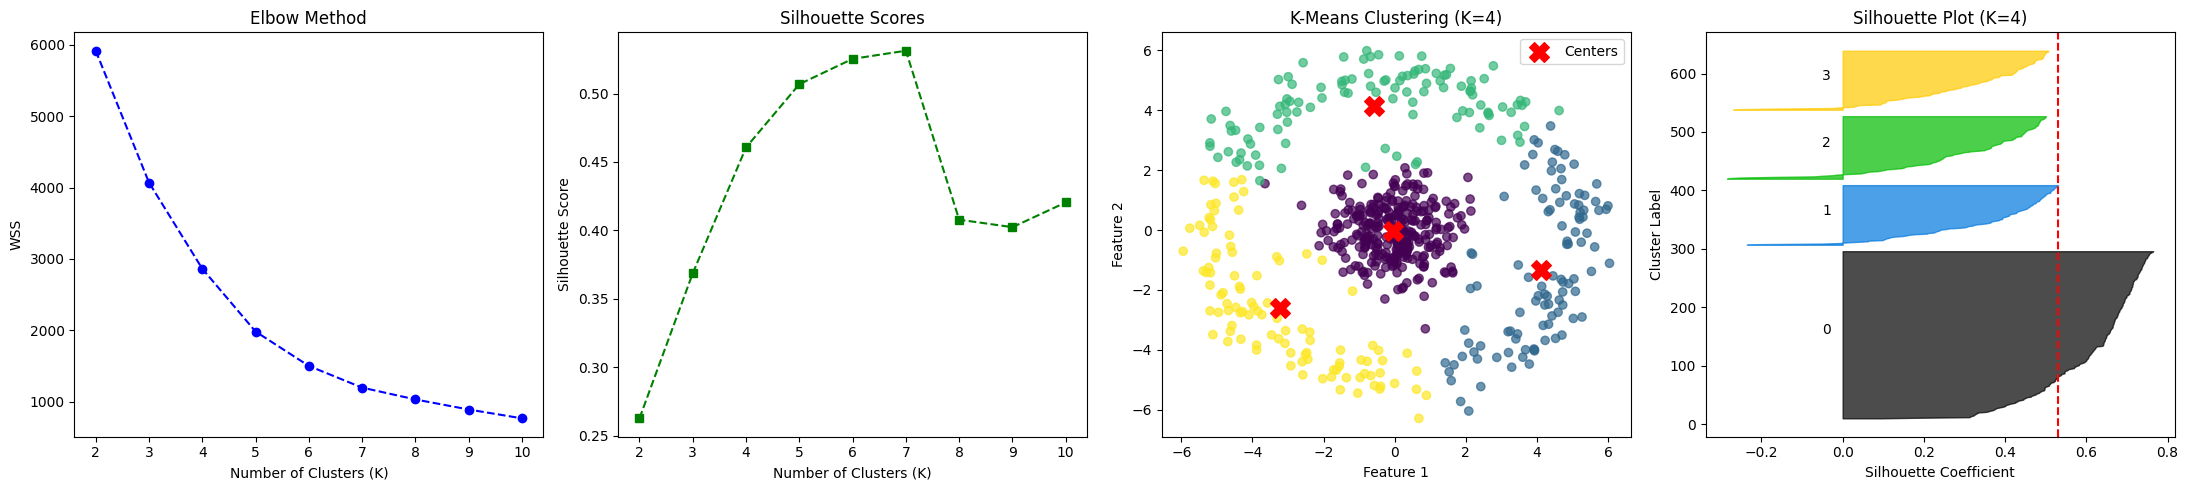


### Processing Dataset 2 ###
Dataset 2: Optimal Clusters (K) = 3, Best Silhouette Score = 0.752
→ Using manually overridden K = 3
→ Adjusted Rand Index (ARI) = 1.0000


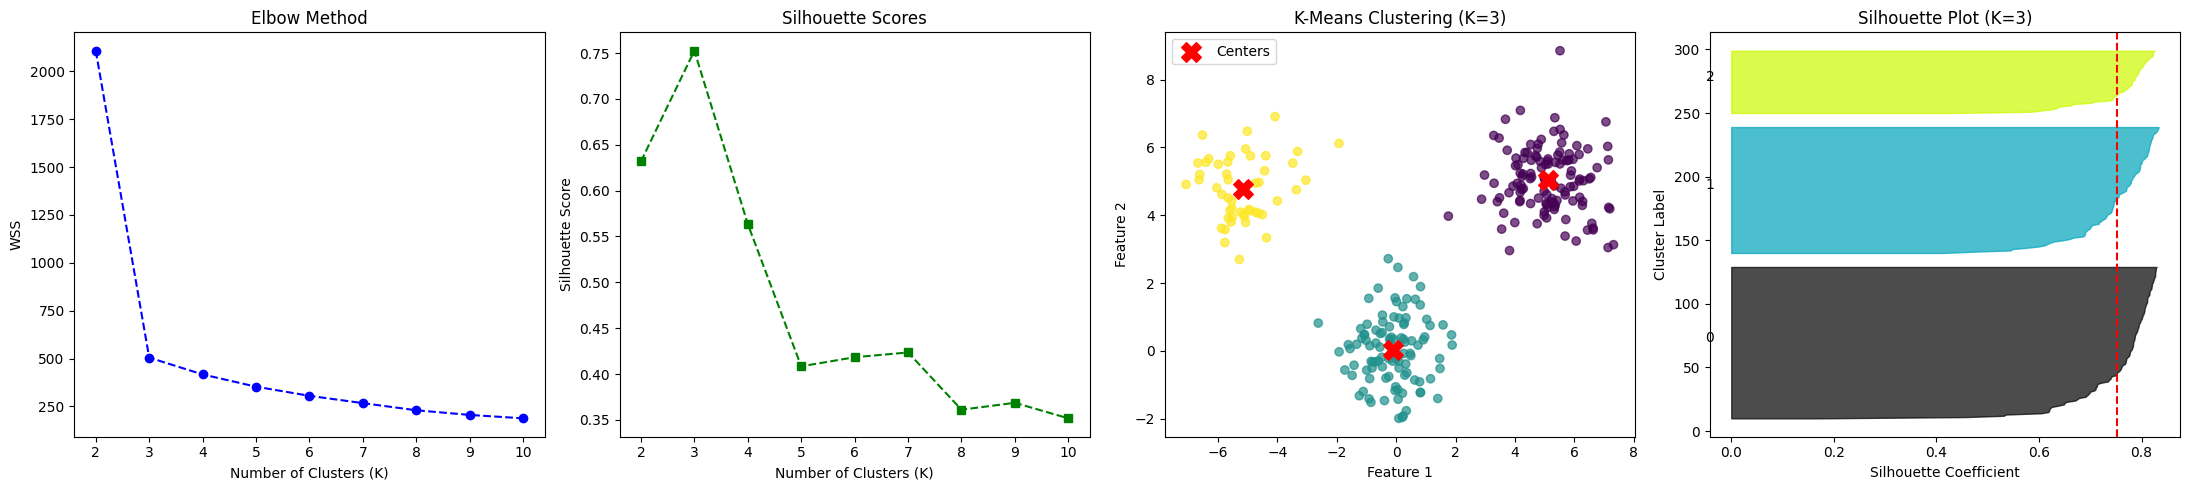


### Processing Dataset 3 ###
Dataset 3: Optimal Clusters (K) = 3, Best Silhouette Score = 0.598
→ Using manually overridden K = 2
→ Adjusted Rand Index (ARI) = 0.9735


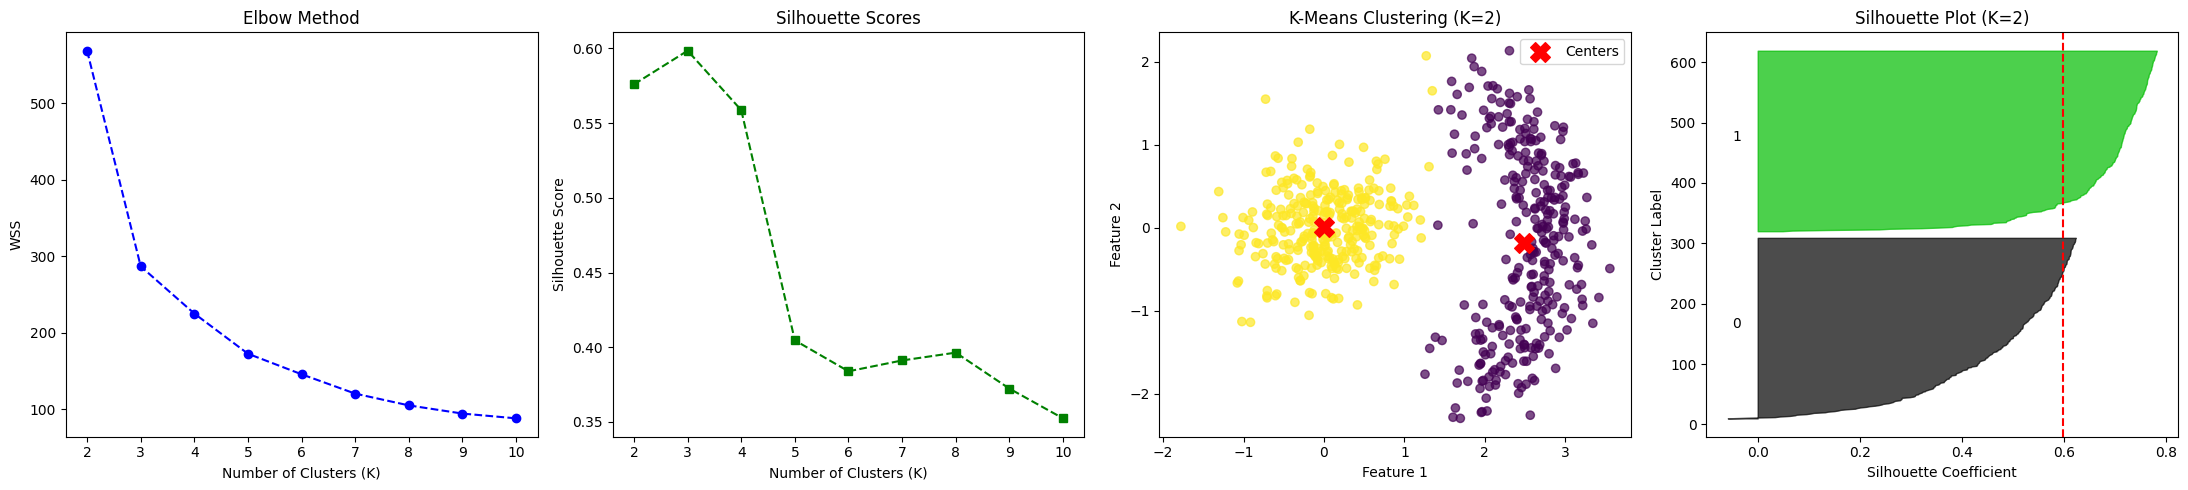


### Processing Dataset 4 ###
Dataset 4: Optimal Clusters (K) = 2, Best Silhouette Score = 0.678
→ Using manually overridden K = 3
→ Adjusted Rand Index (ARI) = 0.9767


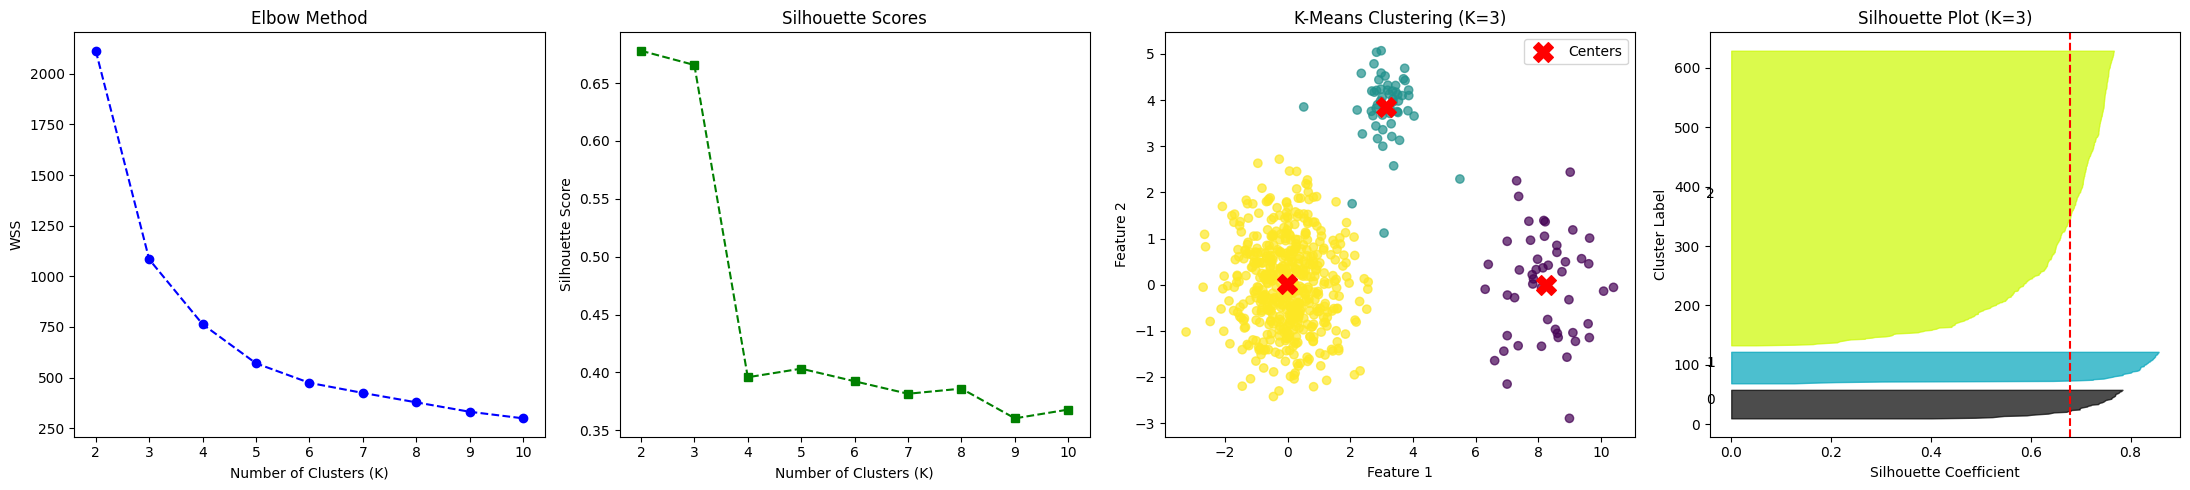


### Processing Dataset 5 ###
Dataset 5: Optimal Clusters (K) = 6, Best Silhouette Score = 0.649
→ Using manually overridden K = 6
→ Adjusted Rand Index (ARI) = 0.8028


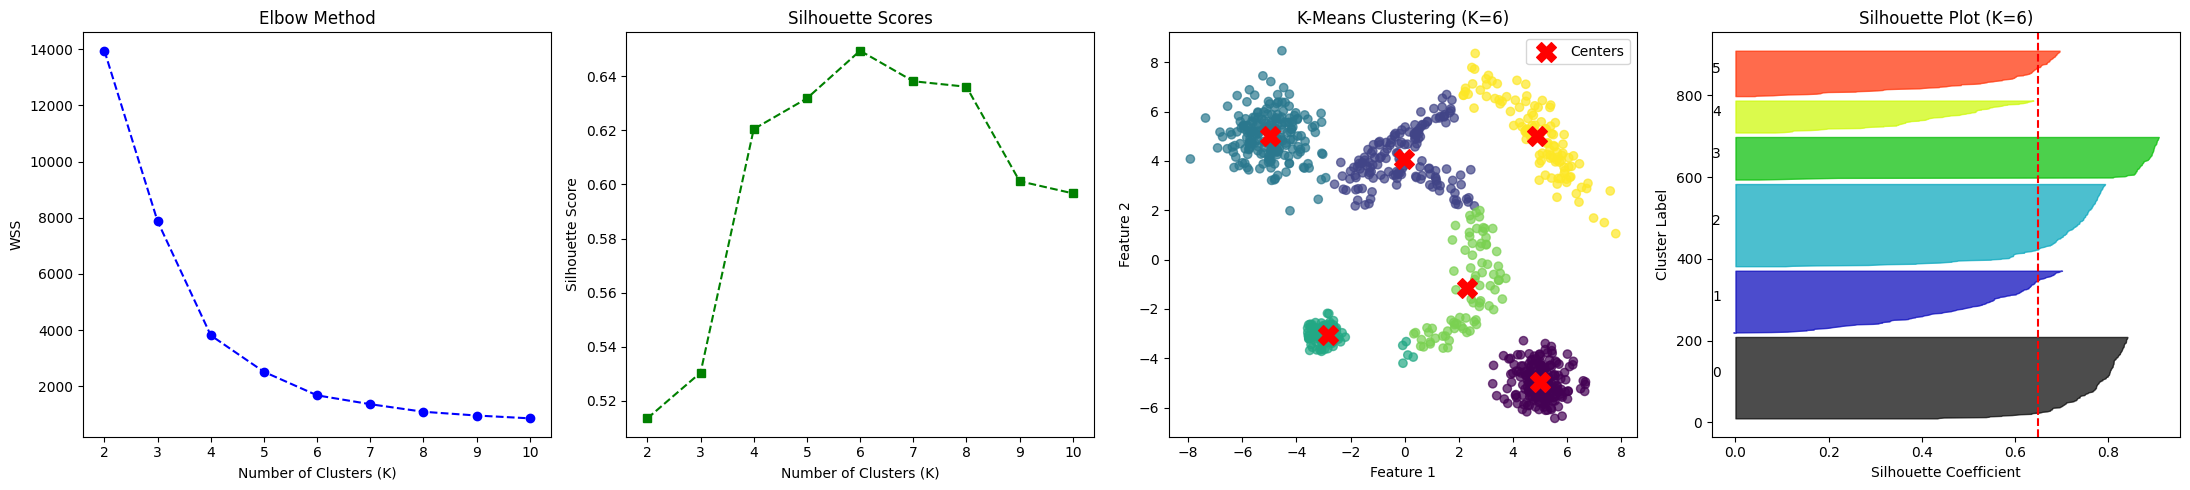

In [87]:
k_override = [4, 3, 2, 3, 6]  # Example – adjust as needed
run_kmeans_on_datasets(X_datasets, true_labels=true_labels, k_override=k_override)


## **Dataset 1 Analysis (K-Means)**

For Dataset 1, the **optimal number of clusters** based on the **silhouette score** was **K=7**, achieving a peak score of **0.538**. This suggests strong internal cohesion and separation according to K-Means' internal validation. However, when manually selecting **K=4**, the resulting clustering achieved a **higher Adjusted Rand Index (ARI) of 0.5924**, indicating a **closer match to the ground truth labels**, despite a slightly lower silhouette score (**~0.531**). This discrepancy highlights a key insight: while silhouette analysis favours compact and well-separated clusters, it may not always align with external validation when the **true structure is non-convex or nested**.

Visually, the clustering result for **K=4** reflects a more meaningful separation: the central dense cluster is correctly identified, and the outer ring is split into three broader arcs that approximate the curved shape of the surrounding data. In contrast, the **K=7** solution, while internally coherent, tends to **over-segment the ring** into smaller slices that do not correspond well to the true label distribution, leading to lower ARI. The issue arises from **K-Means' geometric constraints** — it assumes **convex, isotropic clusters** and relies on **Euclidean distance**, which performs poorly on **non-linearly separable structures** like rings. This results in incorrect assignments near the boundaries of curved regions, and centroids placed inside gaps rather than along the ring's arc.

Furthermore, the **silhouette plot for K=4** (shown in the fourth panel of the image) shows consistent cluster cohesion, particularly for the central cluster (label 0), and decent separation among the outer clusters. This suggests that, while K=7 may optimise intra-cluster tightness, **K=4 offers a better trade-off between internal structure and alignment with true labels**, especially when the data's geometry is not well-suited to K-Means assumptions. As such, for datasets like this, **external metrics like ARI** and **visual inspection** provide essential context beyond silhouette scores. Alternative algorithms such as **DBSCAN** or **Spectral Clustering** — which do not rely on convexity — would likely better capture the ring-shaped structure inherent to this dataset.


## **Dataset 2 Analysis (K-Means)**

For Dataset 2, both internal and external validation metrics confirm that **K=3** is the optimal number of clusters. The **silhouette score peaks at 0.752**, reflecting strong intra-cluster cohesion and inter-cluster separation, while the **Adjusted Rand Index (ARI) is 1.0000**, indicating a **perfect match with the ground truth labels**. This exceptional alignment is due to the dataset's **globular, well-separated structure**, which aligns closely with **K-Means' assumptions** of convex, isotropic clusters.

Visually, the clustering result shown in the third panel illustrates three compact clusters, each with its centroid positioned centrally within the group. The **elbow method** also supports K=3 as optimal, with a sharp drop in WSS up to this point and diminishing returns beyond it. The **silhouette plot** confirms that all clusters have consistently high silhouette coefficients with minimal overlap, showing well-defined boundaries and confident assignments. Since the clusters are **clearly distinct and do not overlap**, Euclidean distance is a highly effective metric, and there is no ambiguity in point-to-cluster assignments.

Importantly, there are no elongated, curved, or irregular structures in this dataset that would challenge K-Means. Unlike datasets where clusters have complex geometries or uneven densities, **Dataset 2 represents an ideal scenario for centroid-based partitioning**. As a result, alternative clustering methods such as DBSCAN or Spectral Clustering offer no advantage here. In conclusion, **K-Means with K=3 provides near-perfect clustering** on Dataset 2, achieving both optimal internal cohesion and perfect external label alignment.


## **Dataset 3 Analysis (K-Means)**

For Dataset 3, the silhouette score analysis suggested an optimal number of clusters at **K=3**, with a silhouette score of **0.598**, indicating moderate intra-cluster cohesion and inter-cluster separation. However, the **best external validation** came from a manually chosen **K=2**, which yielded a significantly higher **Adjusted Rand Index (ARI) of 0.9735**, showing much closer alignment with the ground truth labels. This reveals a **notable divergence between internal and external validation metrics**, with silhouette score favouring finer segmentation and ARI rewarding fidelity to true labels.

The dataset contains **two elongated, overlapping clusters**, which K-Means with **K=2** is able to recover more effectively than with **K=3**, where over-segmentation can split a single true cluster into two parts. The visual result for **K=2** confirms this: the decision boundary captures the division between the left and right distributions cleanly, despite their elongated shape. The silhouette plot, although still showing relatively high values, suggests slightly less cohesion than in more globular datasets due to the **elongated and anisotropic nature of the clusters**, which K-Means handles less gracefully.

K-Means' assumption of **spherical and equally sized clusters** makes it sensitive to elongated or unbalanced groupings, especially when centroids are placed near dense regions, as seen in the central band of the plot. Nonetheless, when clustering at **K=2**, K-Means captures the broad separation effectively, even if it does not model the elongated shapes perfectly. This explains the trade-off: **K=3 maximises internal separation**, but **K=2 aligns better with the true labels** by avoiding artificial splits.

In this context, **K=2 is a more practical choice**, especially when ground truth is known or external validation is a priority. The high ARI confirms that, despite the silhouette score being slightly lower, this configuration **preserves the integrity of the true cluster structure**, making it the preferred clustering solution for Dataset 3.


## **Dataset 4 Analysis (K-Means)**

While the silhouette score analysis for Dataset 4 suggested **K=2** as the optimal number of clusters with a strong score of **0.678**, the manually overridden clustering at **K=3** achieved a significantly higher **Adjusted Rand Index (ARI) of 0.9767**, indicating a near-perfect match with the true labels. This highlights a key trade-off between **internal validation** (e.g. silhouette score) and **external accuracy** (e.g. ARI): while K=2 may offer slightly more compact and separated clusters from a geometric standpoint, K=3 better reflects the **true underlying structure** of the data.

Visually, the clustering at **K=3** cleanly identifies the three ground truth clusters: a large bottom-left cluster, a compact top cluster, and a moderately sized right-hand cluster. The silhouette plot confirms this structure, with **strong intra-cluster cohesion** especially in the dominant yellow group, and relatively well-separated profiles for the other two clusters. However, the overall silhouette score is slightly lower than for K=2, due to minor overlaps and reduced separation between the top and bottom-left groups.

This discrepancy arises from the **distributional imbalance** across clusters. When K=2 is used, K-Means tends to **merge the smaller top cluster** with the larger bottom-left one due to their spatial proximity, artificially inflating the average silhouette score by minimizing inter-centroid distance. However, this oversimplifies the real structure and reduces ARI. By setting **K=3**, K-Means captures finer distinctions in the data, at the cost of some decrease in internal cohesion—but with a major gain in external correctness.

Thus, while silhouette analysis suggests a compact K=2 solution, **K=3 is clearly more aligned with the true data-generating process**, and the high ARI supports this choice. This reinforces the importance of balancing internal and external validation metrics, and recognizing that **a slightly lower silhouette score can still correspond to a more semantically accurate clustering**.


## **Dataset 5 Analysis (K-Means)**

The optimal number of clusters for Dataset 5 was determined to be **6**, based on the **peak silhouette score of 0.649**, and this selection aligns with the **manually overridden K = 6**, which achieves a strong **Adjusted Rand Index (ARI) of 0.8028**. The silhouette score and ARI together indicate that K-Means captures the major structural patterns of the dataset effectively, although some **cluster boundary ambiguities remain**. The **Elbow method** further supports this selection, with a notable drop in within-cluster sum of squares (WSS) up to **K=6**, after which marginal gains are observed.

Visually, the clustering at **K=6** reflects the **ground truth remarkably well**, particularly for the **four peripheral clusters** that are clearly **compact, dense, and spatially separated**. These clusters contribute heavily to the high silhouette values, as they conform closely to K-Means' assumptions of **convex and isotropic** clusters. However, the **two central clusters**, which are part of a curved structure, are **closer in proximity and more elongated**, leading to **overlapping decision boundaries**. This proximity causes certain data points to be **nearly equidistant from two centroids**, which reduces the silhouette score for those points and explains the **moderate deviation in ARI from 1.0**.

The silhouette plot clearly reveals this dynamic: while most clusters show **broad and well-formed silhouette bars**, the central clusters contain **narrower and more variable distributions**, reflecting **lower intra-cluster cohesion** and **increased inter-cluster similarity**. Since K-Means partitions based on Euclidean distance, this approach **struggles with curved or chain-like structures**, even when overall clustering appears visually sound.

In conclusion, while **K=6** represents an optimal internal clustering solution with a **strong silhouette score (0.649)** and **high external agreement (ARI = 0.8028)**, the results highlight **K-Means’ sensitivity to cluster shape and spacing**. For further refinement, methods like **Spectral Clustering** or **DBSCAN** could better handle the **non-linear and closely positioned central structures**, offering more flexibility in capturing the nuanced topology of the data.


---

## **Comprehensive Summary of K-Means on All Datasets**

K-Means performed well on datasets with **globular, well-separated clusters** (e.g., Dataset 2), where its assumptions of **convex and isotropic clusters** aligned naturally with the data structure—resulting in **perfect clustering (ARI = 1.0)** and high silhouette scores. However, its limitations became more apparent in datasets with **non-linear, elongated, or unevenly distributed clusters**. For instance, in Dataset 1, although K=7 was optimal by silhouette score, the more semantically meaningful clustering at K=4 achieved higher ARI, showing how internal compactness doesn’t always translate to ground-truth fidelity. Similar behaviour was observed in Dataset 3, where silhouette analysis favoured K=3, but the true label alignment was much stronger at K=2.

Datasets 4 and 5 highlight a **recurring trade-off**: silhouette scores favour simpler, tighter groupings (K=2 or K=6), while ARI favours clusterings that match subtle structural details in the ground truth (K=3 or K=6 respectively). In these cases, K-Means' **Euclidean distance reliance** and rigid boundaries lead to boundary errors, especially when clusters are **curved, chained, or closely spaced**. The silhouette plots consistently reveal which clusters suffer from poor cohesion or overlap. While K-Means is computationally efficient and effective in clean scenarios, its **performance deteriorates on complex geometries**, reinforcing the need for complementary validation metrics (like ARI) and, in some cases, switching to more flexible algorithms like **DBSCAN or Spectral Clustering**.

## **K-Means Clustering Performance Summary Table**

| Dataset | Optimal K (Silhouette) | Manual K Used | Silhouette Score | Adjusted Rand Index (ARI) | Key Insight |
|--------|-------------------------|---------------|-------------------|----------------------------|-------------|
| 1      | 7                       | 4             | 0.531             | 0.5924                     | K=4 better aligns with curved structure despite lower cohesion |
| 2      | 3                       | 3             | 0.752             | 1.0000                     | Ideal for K-Means; globular clusters perfectly captured |
| 3      | 3                       | 2             | 0.598             | 0.9735                     | K=2 avoids over-segmentation of elongated clusters |
| 4      | 2                       | 3             | 0.678             | 0.9767                     | K=3 captures real structure; K=2 over-merges small cluster |
| 5      | 6                       | 6             | 0.649             | 0.8028                     | Good fit overall; central clusters slightly overlap |



---

# **DBSCAN Clustering**

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors



In [89]:
def apply_dbscan_subplot(ax, X, eps, min_samples, dataset_index):
    """Apply DBSCAN to a dataset and plot results in a subplot."""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    
    unique_labels = set(labels)
    num_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    
    cluster_colors = plt.cm.get_cmap("tab10", num_clusters)  
    noise_color = "black"  

    for label in unique_labels:
        if label == -1:  # Noise points
            ax.scatter(X[labels == label, 0], X[labels == label, 1], 
                       color=noise_color, marker='x', s=30, label='Noise (Outliers)', alpha=0.6)
        else:
            ax.scatter(X[labels == label, 0], X[labels == label, 1], 
                       color=cluster_colors(label % num_clusters), marker='o', s=40, label=f'Cluster {label}', edgecolors='k')

    ax.set_title(f"Dataset {dataset_index+1}\nDBSCAN (eps={eps}, min_samples={min_samples})", fontsize=12)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), fontsize="small", frameon=True, ncol=3)  # Legend below plot

Dataset 1: Estimated eps = 0.2230, min_samples = 4, Avg Distance = 0.3448
Dataset 2: Estimated eps = 0.2669, min_samples = 4, Avg Distance = 0.4073
Dataset 3: Estimated eps = 0.0887, min_samples = 4, Avg Distance = 0.1284
Dataset 4: Estimated eps = 0.1314, min_samples = 4, Avg Distance = 0.2353
Dataset 5: Estimated eps = 0.1702, min_samples = 4, Avg Distance = 0.2582


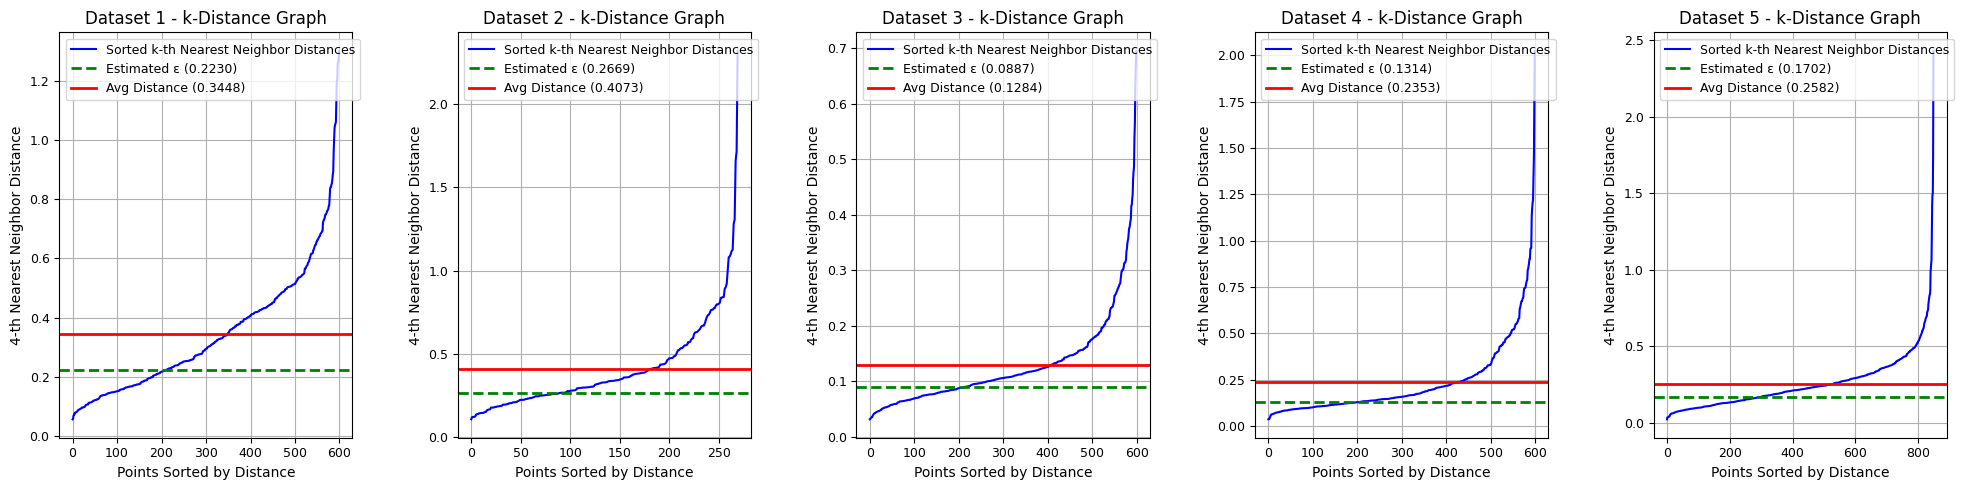


Optimal DBSCAN Parameters for Each Dataset:
{0: {'eps': np.float64(0.22296903498210768), 'min_samples': 4}, 1: {'eps': np.float64(0.2669015121015186), 'min_samples': 4}, 2: {'eps': np.float64(0.0886763160771243), 'min_samples': 4}, 3: {'eps': np.float64(0.1314176629798324), 'min_samples': 4}, 4: {'eps': np.float64(0.17017134663854963), 'min_samples': 4}}


In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def estimate_dbscan_params(X, minpts=None, percentile=35):
    """Estimate DBSCAN parameters using k-distance graph logic.
    
    - min_samples = d + 1 (default) or user-defined.
    - eps is selected from k-distance graph based on percentile.
    - Also computes alternative range (40-50th percentile).
    """
    d = X.shape[1]  # Dimensionality of the dataset
    if minpts is None:
        minpts = d + 1  # Default rule of thumb if not provided

    # Fit NearestNeighbors model
    neighbors = NearestNeighbors(n_neighbors=minpts)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)

    # Sort distances (take the minpts-th nearest neighbor distance for each point)
    distances = np.sort(distances[:, minpts - 1])

    # Compute eps based on percentile
    eps = np.percentile(distances, percentile)

    # Compute overall average distance
    avg_distance = np.mean(distances)

    # Suggest alternative ε range (40-50th percentile)
    alt_eps_lower = np.percentile(distances, 40)
    alt_eps_upper = np.percentile(distances, 50)

    return eps, minpts, distances, avg_distance, alt_eps_lower, alt_eps_upper

# Dictionary to store best DBSCAN parameters
best_dbscan_params = {}

# Create subplots for k-distance graphs
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, X in enumerate(datasets):
    eps, minpts, distances, avg_distance, alt_eps_lower, alt_eps_upper = estimate_dbscan_params(X)

    best_dbscan_params[i] = {"eps": eps, "min_samples": minpts}
    print(f"Dataset {i+1}: Estimated eps = {eps:.4f}, min_samples = {minpts}, Avg Distance = {avg_distance:.4f}")

    # k-Distance Graph
    axes[i].plot(distances, color="blue", linewidth=1.5, label="Sorted k-th Nearest Neighbor Distances")
    
    # Highlight estimated ε (green line)
    axes[i].axhline(y=eps, color="green", linestyle="--", linewidth=2, label=f"Estimated ε ({eps:.4f})")

    # Highlight overall avg distance (red line)
    axes[i].axhline(y=avg_distance, color="red", linestyle="-", linewidth=2, label=f"Avg Distance ({avg_distance:.4f})")

    # Add title and labels
    axes[i].set_xlabel("Points Sorted by Distance", fontsize=10)
    axes[i].set_ylabel(f"{minpts}-th Nearest Neighbor Distance", fontsize=10)
    axes[i].set_title(f"Dataset {i+1} - k-Distance Graph", fontsize=12)
    
    # Improve tick readability
    axes[i].tick_params(axis='both', which='major', labelsize=9)
    
    # Show legend
    axes[i].legend(fontsize=9, loc="upper left")
    
    # Grid for better visualization
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Final dictionary with best parameters
print("\nOptimal DBSCAN Parameters for Each Dataset:")
print(best_dbscan_params)


In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

def run_dbscan_plot(X, true_labels, eps=0.57, minpts=3):
    """
    Runs DBSCAN on a dataset, plots the clustering result,
    and prints number of clusters and ARI.

    Parameters:
        X (np.ndarray): Feature matrix of shape (n_samples, 2)
        true_labels (np.ndarray): Ground truth labels
        eps (float): DBSCAN epsilon parameter
        minpts (int): DBSCAN min_samples parameter
    """
    # Fit DBSCAN
    db = DBSCAN(eps=eps, min_samples=minpts)
    labels = db.fit_predict(X)

    # Get number of clusters (excluding noise)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Plot
    # Plot
    plt.figure(figsize=(8, 5))
    unique_labels = set(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

    for k, col in zip(sorted(l for l in unique_labels if l != -1), colors):
        plt.scatter(X[labels == k, 0], X[labels == k, 1], c=[col], marker='o', label=f'Cluster {k}', edgecolor='k', s=30)

    # Plot noise (label -1)
    plt.scatter(X[labels == -1, 0], X[labels == -1, 1], c='lightgrey', marker='x', label='Outliers', s=40)

    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={minpts})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Move legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


    # Print summary
    print(f"Clusters formed (excluding outliers): {n_clusters}")
    ari = adjusted_rand_score(true_labels, labels)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")


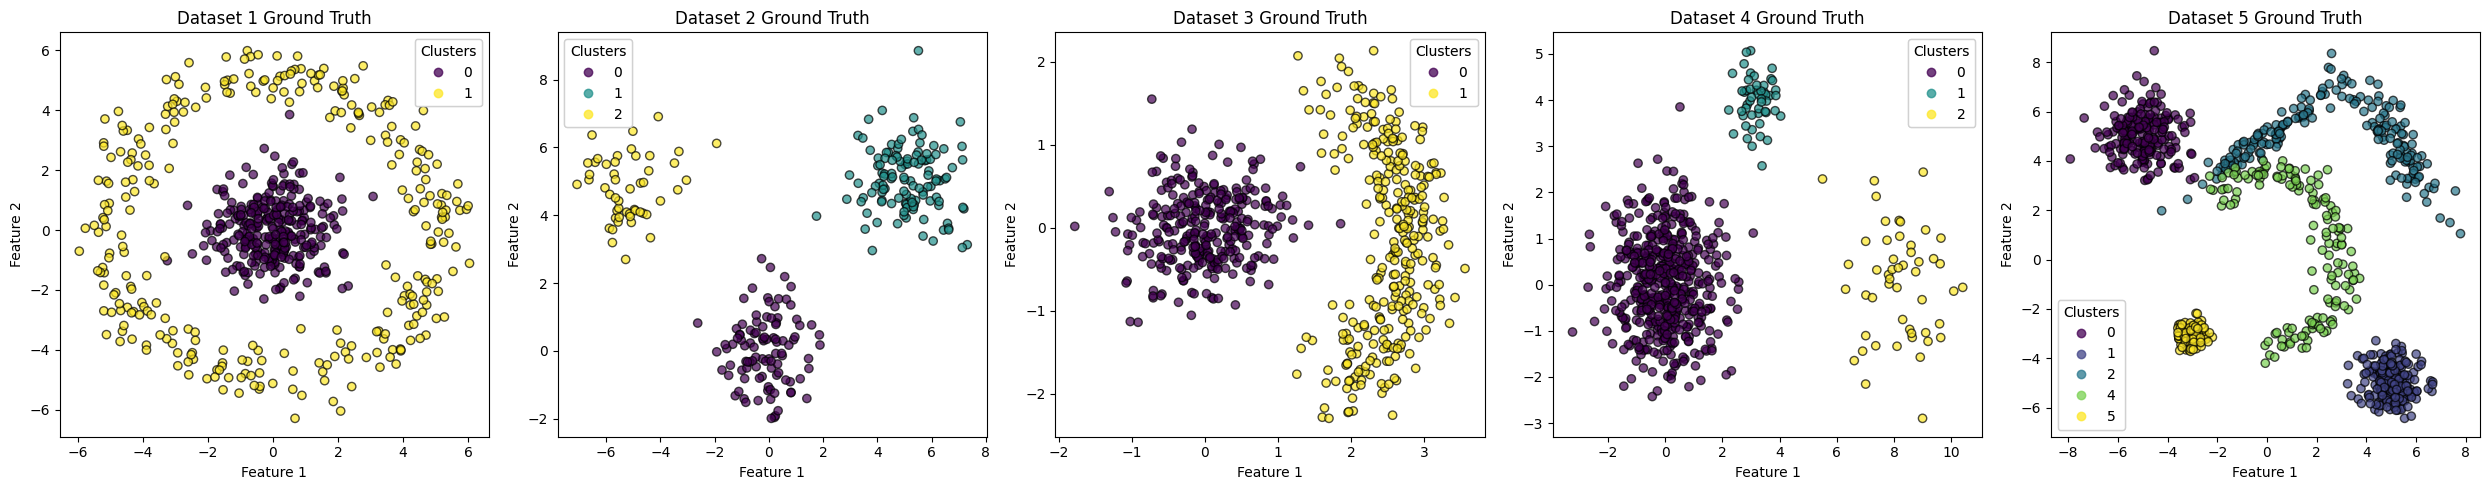

In [92]:
plot_ground_truth_clusters(datasets_with_labels)

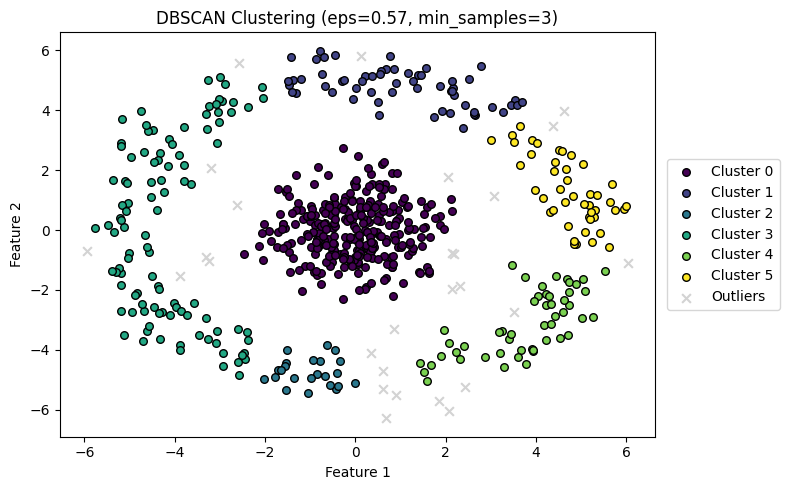

Clusters formed (excluding outliers): 6
Adjusted Rand Index (ARI): 0.5769


In [93]:
X, y = datasets_with_labels[0]
run_dbscan_plot(X, y, eps=0.57, minpts=3)


### **DBSCAN Analysis for Dataset 1**

DBSCAN’s performance on **Dataset 1** highlights both its strengths and limitations. Visually, DBSCAN handles the **non-convex structure** well—successfully distinguishing the **central dense cluster** from the surrounding **ring-shaped region**, which is typically challenging for algorithms like K-Means. However, instead of grouping the ring into one cohesive cluster (as seen in the **ground truth**), DBSCAN splits it into **six smaller clusters**, resulting in an **Adjusted Rand Index (ARI) of 0.5769**.

This over-segmentation occurs because DBSCAN relies on **local density** to define clusters. In the ring, variations in point density and small gaps cause DBSCAN to treat these as separate regions, breaking up what should be a single class. While this affects external validation metrics like ARI, it demonstrates DBSCAN’s ability to **detect nuanced structural changes**. Additionally, DBSCAN effectively identifies **outliers**, shown as light grey X's, particularly in low-density areas—an advantage over centroid-based methods. In conclusion, while DBSCAN excels at capturing **non-linear shapes and noise**, its sensitivity to **density variations** can lead to **fragmented clustering** when the true structure is more globally defined.


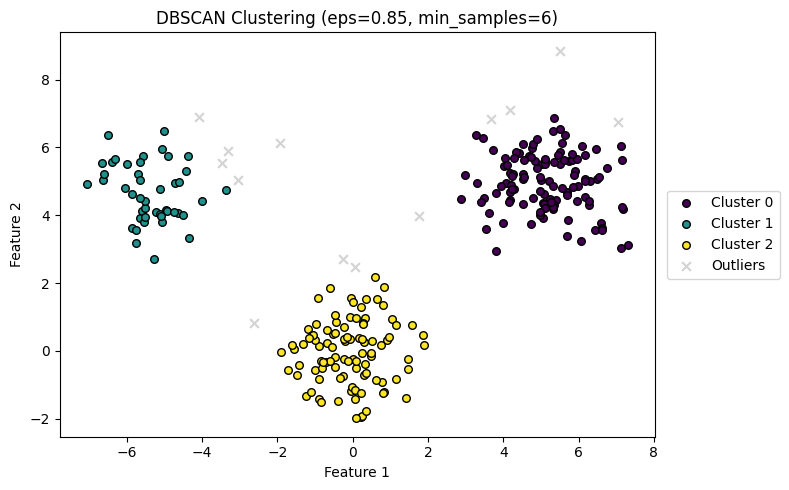

Clusters formed (excluding outliers): 3
Adjusted Rand Index (ARI): 0.9309


In [94]:
X, y = datasets_with_labels[1]
run_dbscan_plot(X, y, eps=0.85, minpts=6)


### **DBSCAN Analysis for Dataset 2**

DBSCAN performs **very effectively** on **Dataset 2**, producing **3 distinct clusters** that align closely with the ground truth. With parameters `eps=0.85` and `min_samples=6`, DBSCAN achieves a **high Adjusted Rand Index (ARI) of 0.9309**, indicating strong agreement between the predicted clustering and the true labels. The model correctly identifies the **three compact, well-separated clusters**, with minimal overlap or misclassification.

This strong performance is due to the dataset’s **favourable structure**—the clusters are **dense, spherical, and well-separated**, which fits DBSCAN's assumptions well. DBSCAN’s **density-based approach** allows it to differentiate the clusters without relying on centroid geometry, and it handles **border points and minor noise** effectively, as shown by the outliers marked in grey. The few outliers detected are reasonable, as they reside in sparse areas between the clusters. Overall, DBSCAN offers a robust and accurate segmentation of Dataset 2, demonstrating its **suitability for detecting globular, well-defined clusters with minimal parameter tuning**.


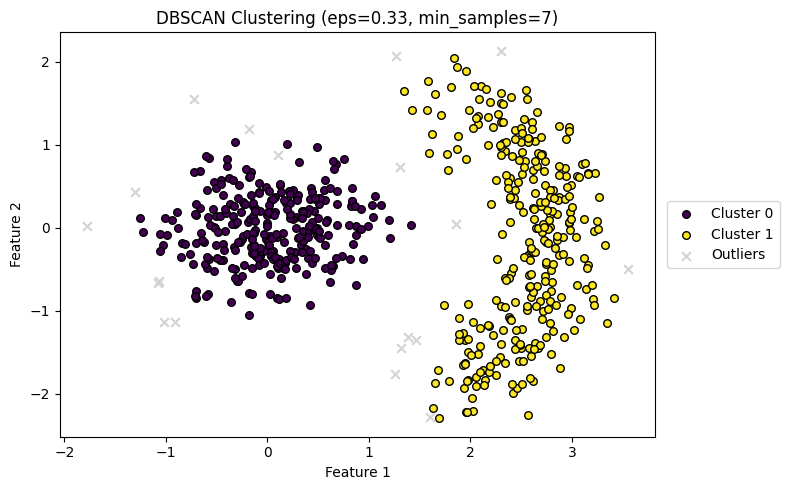

Clusters formed (excluding outliers): 2
Adjusted Rand Index (ARI): 0.9376


In [95]:
X, y = datasets_with_labels[2]
run_dbscan_plot(X, y, eps=0.33, minpts=7)


### **DBSCAN Analysis for Dataset 3**

DBSCAN performs **very effectively** on **Dataset 3**, producing exactly **2 clusters** that closely match the ground truth labels. With `eps=0.33` and `min_samples=7`, the algorithm achieves a **high Adjusted Rand Index (ARI) of 0.9376**, demonstrating strong external agreement. The two clusters—one compact on the left and one elongated on the right—are successfully captured despite their shape differences.

This is a clear demonstration of **DBSCAN's robustness to cluster shape**. Unlike K-Means, which struggles with elongated or non-spherical clusters, DBSCAN’s **density-based logic** enables it to delineate the two distributions cleanly without being misled by their differing geometries. A few outliers (labelled as `-1`) are identified between clusters where the density is lower, further supporting the algorithm’s **ability to handle boundary noise**. Overall, this outcome illustrates DBSCAN’s **advantage in clustering non-convex shapes**, yielding both high fidelity and structural alignment with the ground truth.


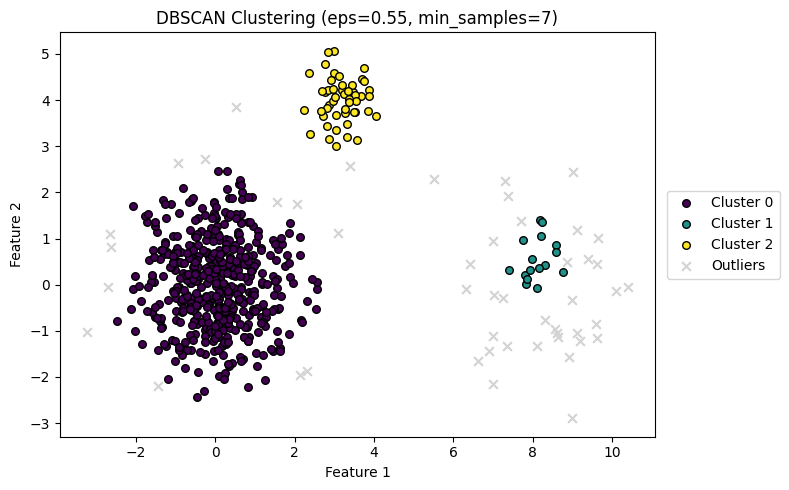

Clusters formed (excluding outliers): 3
Adjusted Rand Index (ARI): 0.9037


In [96]:
X, y = datasets_with_labels[3]
run_dbscan_plot(X, y, eps=0.55, minpts=7)


### **DBSCAN Analysis for Dataset 4**

DBSCAN achieved **3 clusters** on Dataset 4 with parameters `eps=0.55` and `min_samples=7`, and produced a strong **Adjusted Rand Index (ARI) of 0.9037**, indicating high external agreement. The method performs **very well** in capturing the **dense clusters on the left and top**, which are compact and spatially separated, aligning well with DBSCAN’s core assumption of density-based grouping.

However, performance **drops slightly for the right-hand cluster**, which is more **sparsely distributed**. Its lower density results in a significant number of points being labelled as **outliers**, making it difficult for DBSCAN to form a cohesive cluster in that region. This exposes a common challenge with DBSCAN: selecting `eps` and `min_samples` to simultaneously fit **both dense and sparse clusters**. A smaller `eps` would under-cluster the sparse region, while increasing it too much would cause the denser clusters to merge incorrectly. Despite this trade-off, the high ARI and visual segmentation show that DBSCAN still performed robustly, though with **sensitivity to intra-cluster density variation**.


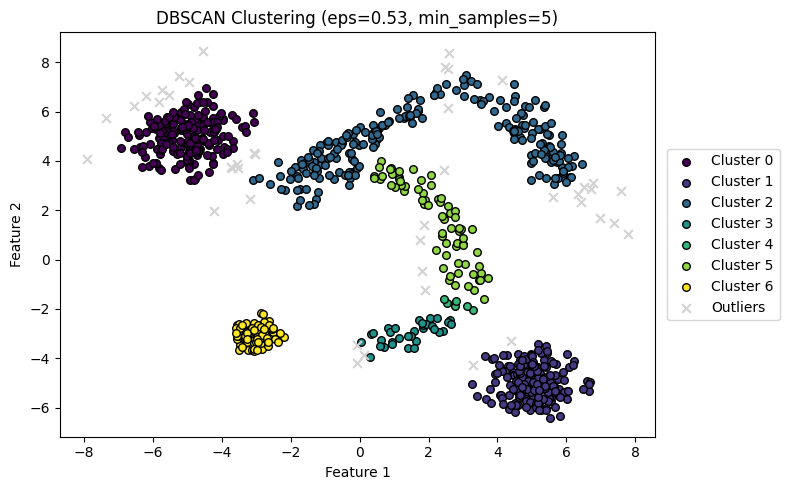

Clusters formed (excluding outliers): 7
Adjusted Rand Index (ARI): 0.8127


In [97]:
X, y = datasets_with_labels[4]
run_dbscan_plot(X, y, eps=0.53, minpts=5)


### **DBSCAN Analysis for Dataset 5**

DBSCAN identified **7 clusters** in Dataset 5 with `eps=0.53` and `min_samples=5`, achieving an **Adjusted Rand Index (ARI) of 0.8127**, indicating reasonably strong external alignment with the ground truth. While this is a good performance overall, the dataset posed several challenges for DBSCAN due to its **diverse cluster shapes** and **density variations**.

The algorithm performed well in capturing the **compact clusters on the periphery**, such as those in the corners and bottom region. These are clearly defined and dense, which suits DBSCAN’s strengths. However, the **curved structure in the centre**, which smoothly transitions between regions of varying density, proved more difficult. DBSCAN struggled to form a unified cluster for this region, instead **fragmenting it into multiple smaller clusters**. Additionally, **outliers were frequently misidentified**, particularly around the edges of these transitioning areas, where density is less consistent. This fragmentation and sensitivity to local density thresholds slightly reduced the ARI and led to a noisier clustering result.

Overall, while DBSCAN handled the **dense, spatially isolated clusters effectively**, its **sensitivity to local density changes** and difficulty in bridging smooth, curved transitions meant it couldn’t fully capture the true structure of Dataset 5. Tuning `eps` and `min_samples` further might help, but alternative methods like **HDBSCAN** or **Spectral Clustering** might be better suited for such heterogeneous data.


---

### **Comprehensive Summary of DBSCAN Clustering Across Datasets**

DBSCAN demonstrated its core strength—**flexibility in cluster shape and robustness to noise**—across the five datasets, particularly excelling in scenarios with **non-convex or elongated structures**. In Dataset 1, DBSCAN was able to separate the dense central cluster from the ring-shaped structure, a task that stumped centroid-based methods like K-Means. However, its tendency to **over-segment regions with local density variations** led to a moderate ARI of **0.5769**, showing that while structurally insightful, DBSCAN may not always align with true labels when clusters vary in density. In contrast, Dataset 2 was a textbook case for DBSCAN, with clearly separated, dense, spherical clusters—leading to **a near-perfect clustering** with **ARI = 0.9309**.

For Dataset 3, DBSCAN effectively identified two clusters of differing shapes, with **an impressive ARI of 0.9376**, confirming its **superiority in handling non-spherical geometry**. Dataset 4 presented a more mixed scenario: DBSCAN cleanly captured the dense top and left clusters but struggled with the sparsely distributed right cluster, which caused excessive outlier assignment. Despite this, it still achieved **ARI = 0.9037**, showing its resilience. Dataset 5 proved the most challenging due to its **varying densities and inter-cluster spacing**. While DBSCAN captured peripheral clusters well, it **fragmented the central curved region**, producing **seven clusters** and an **ARI of 0.8127**. These findings highlight DBSCAN's **powerful shape detection**, but also its **sensitivity to parameter tuning** and **density imbalance**, making it ideal for flexible structures, but less stable with uneven distributions.


### **DBSCAN Clustering Performance Summary Table**

| Dataset | eps  | min_samples | Clusters Formed | ARI Score | Performance Summary |
|---------|------|-------------|------------------|-----------|---------------------|
| 1       | 0.57 | 3           | 6 + outliers     | 0.5769    | Captured non-linear shape but over-segmented due to local density variation. |
| 2       | 0.85 | 6           | 3                | 0.9309    | Near-perfect clustering on compact, well-separated groups. |
| 3       | 0.33 | 7           | 2                | 0.9376    | Strong separation of elongated and compact clusters; robust to shape. |
| 4       | 0.55 | 7           | 3                | 0.9037    | Accurate for dense clusters, struggled with sparse third cluster. |
| 5       | 0.53 | 5           | 7 + outliers     | 0.8127    | Good peripheral clustering, fragmented central structure due to density variation. |



---

### **Overall Clustering Method Comparison Across All Datasets**

Each clustering technique—**K-Means**, **Hierarchical Clustering**, and **DBSCAN**—exhibited distinct strengths and weaknesses across the five datasets, heavily influenced by **cluster shape**, **density**, and **distribution complexity**. **K-Means** proved to be highly effective in structured environments with **globular, equally sized clusters** (e.g., Dataset 2), achieving **perfect external accuracy (ARI = 1.0)**. However, it consistently struggled with **non-linear or curved geometries**, particularly in Datasets 1 and 5, where its reliance on **Euclidean distance and convex partitions** led to poor alignment with ground truth. Its performance often depended on manually tuning *K* to favour ARI over silhouette score.

**DBSCAN**, on the other hand, excelled in **detecting non-convex, irregular cluster shapes** and naturally handled **outliers**, offering valuable flexibility. It was especially strong in Datasets 1 and 3, where the structure did not conform to traditional globular clusters. Nevertheless, DBSCAN’s **sensitivity to density** and **parameter tuning** occasionally caused **over-segmentation or excessive noise detection**, particularly in Dataset 5. **Hierarchical Clustering**—especially **average linkage**—offered a balance between flexibility and structure. It handled most datasets well, achieving **consistently strong ARIs** and adapting better than K-Means to curved layouts, though it too could misinterpret elongated clusters without the right *k* cut. In summary, **K-Means is best for simplicity and speed**, **Hierarchical Clustering excels in interpretability and moderate complexity**, while **DBSCAN dominates in non-linear, noise-prone settings**, albeit at the cost of careful parameter tuning.



### **Clustering Method Comparison Summary Table**

| Dataset | True Labels | K-Means ARI | Best K Used | Hierarchical ARI (Method) | DBSCAN ARI | Clusters Formed (DBSCAN) | Key Observations |
|---------|-------------|-------------|-------------|----------------------------|------------|---------------------------|------------------|
| **1**   | 2           | 0.5924      | 4           | 0.5967 (Average, k=8)      | 0.5769     | 6 + outliers              | DBSCAN best captured shape but over-segmented; all methods struggled. |
| **2**   | 3           | 1.0000      | 3           | 1.0000 (Average, k=3)      | 0.9309     | 3                         | All methods excelled; K-Means and Avg linkage perfect. |
| **3**   | 2           | 0.9735      | 2           | 0.9867 (Average, k=2)      | 0.9376     | 2                         | All methods performed well; DBSCAN robust to shape. |
| **4**   | 3           | 0.9767      | 3           | 0.9987 (Average, k=3)      | 0.9037     | 3                         | Hierarchical best matched truth; DBSCAN struggled with sparse cluster. |
| **5**   | 6           | 0.8028      | 6           | 0.8078 (Average, k=6)      | 0.8127     | 7 + outliers              | DBSCAN and Hierarchical similar; K-Means slightly underperformed. |

**Key Takeaway:**  
No single method dominates universally. **K-Means thrives in clean, globular data**. **Hierarchical (especially average linkage)** offers strong balance across most datasets, and **DBSCAN shines in curved or noisy layouts** but requires careful tuning to avoid over-fragmentation or excessive noise labelling.


---

# **Question 2b**

In [98]:
# Define the dataset as a list of dictionaries
animals = [
    {"ID": "a", "Animal": "Lion", "Diet": "Carnivore", "Size": "Large", "Activity": "Diurnal", "Covering": "Fur"},
    {"ID": "b", "Animal": "Elephant", "Diet": "Herbivore", "Size": "Large", "Activity": "Diurnal", "Covering": "Skin"},
    {"ID": "c", "Animal": "Crocodile", "Diet": "Carnivore", "Size": "Large", "Activity": "Diurnal", "Covering": "Scales"},
    {"ID": "d", "Animal": "Parrot", "Diet": "Herbivore", "Size": "Small", "Activity": "Diurnal", "Covering": "Feathers"},
    {"ID": "e", "Animal": "Snake", "Diet": "Carnivore", "Size": "Medium", "Activity": "Nocturnal", "Covering": "Scales"},
    {"ID": "f", "Animal": "Frog", "Diet": "Herbivore", "Size": "Small", "Activity": "Nocturnal", "Covering": "Skin"},
    {"ID": "g", "Animal": "Bear", "Diet": "Omnivore", "Size": "Large", "Activity": "Nocturnal", "Covering": "Fur"},
    {"ID": "h", "Animal": "Bat", "Diet": "Omnivore", "Size": "Small", "Activity": "Nocturnal", "Covering": "Skin"},
    {"ID": "i", "Animal": "Squirrel", "Diet": "Herbivore", "Size": "Small", "Activity": "Diurnal", "Covering": "Fur"},
]


In [99]:
def matching_distance(animal1, animal2):
    """Computes the matching distance (Hamming Distance) between two categorical observations."""
    keys = ["Diet", "Size", "Activity", "Covering"]
    mismatches = sum(1 for key in keys if animal1[key] != animal2[key])
    return mismatches / len(keys)  # Normalize by the number of attributes


In [100]:
def compute_distance_matrix(animals):
    """Creates a dictionary storing pairwise distances for all animals."""
    distance_matrix = {}
    
    for i in range(len(animals)):
        for j in range(i + 1, len(animals)):  # Avoid redundant calculations
            pair = (animals[i]["ID"], animals[j]["ID"])
            distance_matrix[pair] = matching_distance(animals[i], animals[j])
    
    return distance_matrix

# Compute the distance matrix
distance_matrix = compute_distance_matrix(animals)
print(distance_matrix)


{('a', 'b'): 0.5, ('a', 'c'): 0.25, ('a', 'd'): 0.75, ('a', 'e'): 0.75, ('a', 'f'): 1.0, ('a', 'g'): 0.5, ('a', 'h'): 1.0, ('a', 'i'): 0.5, ('b', 'c'): 0.5, ('b', 'd'): 0.5, ('b', 'e'): 1.0, ('b', 'f'): 0.5, ('b', 'g'): 0.75, ('b', 'h'): 0.75, ('b', 'i'): 0.5, ('c', 'd'): 0.75, ('c', 'e'): 0.5, ('c', 'f'): 1.0, ('c', 'g'): 0.75, ('c', 'h'): 1.0, ('c', 'i'): 0.75, ('d', 'e'): 1.0, ('d', 'f'): 0.5, ('d', 'g'): 1.0, ('d', 'h'): 0.75, ('d', 'i'): 0.25, ('e', 'f'): 0.75, ('e', 'g'): 0.75, ('e', 'h'): 0.75, ('e', 'i'): 1.0, ('f', 'g'): 0.75, ('f', 'h'): 0.25, ('f', 'i'): 0.5, ('g', 'h'): 0.5, ('g', 'i'): 0.75, ('h', 'i'): 0.75}


In [101]:
# Extract unique animal IDs
animal_ids = [animal["ID"] for animal in animals]

# Print header row
print("\t" + "\t".join(animal_ids))  

# Print each row
for i, id1 in enumerate(animal_ids):
    row_values = []
    for j, id2 in enumerate(animal_ids):
        if i == j:
            row_values.append("0")  # Distance to itself
        else:
            # Get the stored distance, if available; otherwise, use '-'
            row_values.append(str(distance_matrix.get((id1, id2), distance_matrix.get((id2, id1), "-"))))
    
    print(f"{id1}\t" + "\t".join(row_values))


	a	b	c	d	e	f	g	h	i
a	0	0.5	0.25	0.75	0.75	1.0	0.5	1.0	0.5
b	0.5	0	0.5	0.5	1.0	0.5	0.75	0.75	0.5
c	0.25	0.5	0	0.75	0.5	1.0	0.75	1.0	0.75
d	0.75	0.5	0.75	0	1.0	0.5	1.0	0.75	0.25
e	0.75	1.0	0.5	1.0	0	0.75	0.75	0.75	1.0
f	1.0	0.5	1.0	0.5	0.75	0	0.75	0.25	0.5
g	0.5	0.75	0.75	1.0	0.75	0.75	0	0.5	0.75
h	1.0	0.75	1.0	0.75	0.75	0.25	0.5	0	0.75
i	0.5	0.5	0.75	0.25	1.0	0.5	0.75	0.75	0


In [102]:
def complete_linkage(cluster1, cluster2, distance_matrix):
    """Computes the complete linkage distance between two clusters."""
    return max(distance_matrix.get((min(a, b), max(a, b)), 0) for a in cluster1 for b in cluster2)


In [103]:
class ClusterNode:
    """Represents a node in the dendrogram tree."""
    def __init__(self, elements, left=None, right=None, distance=0.0):
        self.elements = elements  # List of animal IDs in this cluster
        self.left = left  # Left child cluster
        self.right = right  # Right child cluster
        self.distance = distance  # Distance at which this merge happened

    def __repr__(self):
        return f"Cluster({self.elements})"

def hierarchical_clustering_with_tree(animals):
    """Performs hierarchical clustering and builds the dendrogram structure."""
    clusters = {animal["ID"]: ClusterNode([animal["ID"]]) for animal in animals}
    merge_history = []

    while len(clusters) > 1:
        closest_pair = None
        min_distance = float("inf")

        for a in clusters:
            for b in clusters:
                if a != b:
                    dist = complete_linkage(clusters[a].elements, clusters[b].elements, distance_matrix)
                    if dist < min_distance:
                        min_distance = dist
                        closest_pair = (a, b)

        if closest_pair:
            a, b = closest_pair
            new_cluster = ClusterNode(
                elements=clusters[a].elements + clusters[b].elements,
                left=clusters[a], right=clusters[b], distance=min_distance
            )

            # Store the merge event for dendrogram construction
            merge_history.append((clusters[a], clusters[b], min_distance))
            
            # Merge clusters
            del clusters[a]
            del clusters[b]
            clusters[a + b] = new_cluster  # New cluster with combined ID

            print(f"Merging {a} and {b} at distance {min_distance:.2f}")

    return list(clusters.values())[0], merge_history  # Return final cluster and merge history

# Run clustering with tree structure
final_cluster, merge_history = hierarchical_clustering_with_tree(animals)


Merging a and c at distance 0.25
Merging d and i at distance 0.25
Merging f and h at distance 0.25
Merging b and ac at distance 0.50
Merging e and g at distance 0.75
Merging di and fh at distance 0.75
Merging bac and eg at distance 1.00
Merging difh and baceg at distance 1.00


In [104]:
print("\nFinal Cluster Structure:", final_cluster)



Final Cluster Structure: Cluster(['d', 'i', 'f', 'h', 'b', 'a', 'c', 'e', 'g'])


In [105]:
def print_dendrogram(node, indent=0):
    """Recursively prints the dendrogram in text format."""
    if node.left and node.right:
        print(" " * indent + f"({node.distance:.2f})")  # Show merge distance
        print_dendrogram(node.left, indent + 4)
        print_dendrogram(node.right, indent + 4)
    else:
        print(" " * indent + " ".join(node.elements))  # Show individual animals

print("\nManual Dendrogram:")
print_dendrogram(final_cluster)



Manual Dendrogram:
(1.00)
    (0.75)
        (0.25)
            d
            i
        (0.25)
            f
            h
    (1.00)
        (0.50)
            b
            (0.25)
                a
                c
        (0.75)
            e
            g


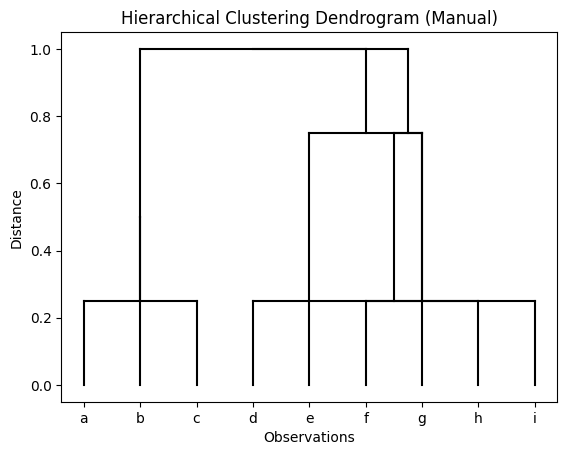

In [106]:
import matplotlib.pyplot as plt

def plot_dendrogram(merge_history, observation_labels):
    cluster_positions = {label: i for i, label in enumerate(observation_labels)}
    y_positions = {}

    current_x = len(observation_labels)  # Position for new clusters

    for left, right, distance in merge_history:
        # Ensure both left and right exist in the current clusters
        if left not in cluster_positions:
            cluster_positions[left] = current_x
            current_x += 1
        if right not in cluster_positions:
            cluster_positions[right] = current_x
            current_x += 1

        x1, x2 = cluster_positions[left], cluster_positions[right]
        y = distance  # Height of the merge in dendrogram

        # Draw vertical lines
        plt.plot([x1, x1], [y_positions.get(left, 0), y], 'k-')
        plt.plot([x2, x2], [y_positions.get(right, 0), y], 'k-')

        # Draw horizontal connecting line
        plt.plot([x1, x2], [y, y], 'k-')

        # Assign the merged cluster to a new position
        merged_cluster = f"{left}{right}"
        cluster_positions[merged_cluster] = (x1 + x2) / 2
        y_positions[merged_cluster] = y

    plt.xticks(range(len(observation_labels)), observation_labels)
    plt.xlabel("Observations")
    plt.ylabel("Distance")
    plt.title("Hierarchical Clustering Dendrogram (Manual)")
    plt.show()

# Updated Merge History
observation_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
merge_history = [
    ('a', 'c', 0.25), ('d', 'i', 0.25), ('f', 'h', 0.25),
    ('b', 'ac', 0.50), ('e', 'g', 0.75), ('di', 'fh', 0.75),
    ('bac', 'eg', 1.00), ('difh', 'baceg', 1.00)
]

plot_dendrogram(merge_history, observation_labels)


### **Interpretation of Hierarchical Clustering Dendrogram (Manual)**

The dendrogram resulting from manual hierarchical clustering using **complete linkage** and **matching distance (Hamming Distance)** reveals a well-structured hierarchy of similarity among animals based on categorical traits like diet, size, activity, and body covering. The first merges occur at a **very low distance (0.25)**, indicating high similarity. Specifically, animals **a (Lion)** and **c (Crocodile)** are merged early due to their shared **carnivorous diet, large size, and diurnal activity**, differing only in their body covering. Similarly, **d (Parrot)** and **i (Squirrel)** are grouped due to both being **small, diurnal herbivores with fur or feathers**, while **f (Frog)** and **h (Bat)** share nocturnal activity, small size, and skin covering, justifying their early linkage. These low-level merges reflect fine-grained similarities in ecological traits.

As the tree progresses, we see merges occurring at **higher distances (0.75 and 1.00)**, reflecting broader groupings. The merge between **b (Elephant)** and the earlier **ac (Lion + Crocodile)** cluster reflects moderate similarity, as all are large and diurnal but differ in diet and body covering. In parallel, the cluster **e (Snake)** and **g (Bear)** is formed at distance 0.75, representing a complex blend of shared carnivorous/omnivorous diets and nocturnal activity. The **di + fh** and **bac + eg** clusters finally merge at the **maximum height of 1.00**, representing the most heterogeneous groupings—animals that differ across multiple categorical dimensions. The dendrogram thus reflects a **logical progression from highly similar animal pairs to more abstract groupings**, with **size, activity, and diet** being the dominant clustering drivers. The final structure suggests two super-clusters: one encompassing mostly **nocturnal or small herbivores/omnivores** (d, i, f, h), and the other aggregating **larger or carnivorous species** (a, b, c, e, g), confirming the method’s biological plausibility.


## **Hierarchical Clustering Dendrogram Analysis**  

The hierarchical clustering was conducted **manually** using the **complete linkage** method, where the similarity between clusters was determined by the **maximum dissimilarity between any two points** in the merged clusters. The clustering process followed a **single matching distance** approach, counting mismatches across categorical attributes. Initially, each observation was treated as its own cluster, and at each iteration, the most similar clusters were merged. This continued iteratively until all observations were grouped into a single hierarchy, forming the dendrogram.  

The **x-axis** of the dendrogram represents the original observations (animal IDs), while the **y-axis** denotes the dissimilarity distance at which clusters merged. The structure of the dendrogram reveals distinct **grouping patterns** based on shared categorical attributes. **For example, species with similar sizes and diets merged at lower distances**, indicating high similarity. In contrast, animals differing significantly in multiple features required higher linkage distances to be grouped, reflecting greater dissimilarity.  

### **Key Observations from the Dendrogram**  

Species that shared similar characteristics were merged early in the clustering process. For instance, **the Lion and Crocodile were grouped together first** due to their **large size and carnivorous diet**, whereas the **Elephant, despite also being large, formed a separate early cluster due to its herbivorous diet**. Similarly, **nocturnal species such as the Frog, Bat, and Snake merged into a distinct group**, showing that **activity period played a crucial role in determining similarity**.  

Another key pattern observed is that **small diurnal animals, such as the Parrot and Squirrel, were grouped together**, emphasizing the importance of **size and body covering** in the clustering process. As the clustering progressed, broader groups merged, revealing the **overall relationships between different species**. The **final cluster merge occurred at the highest distance**, representing the **greatest level of dissimilarity in the dataset**.  

The **complete linkage method ensures that clusters remain well-separated**, producing **clear and distinct groups**. The dendrogram effectively captures the **underlying patterns in species similarity**, demonstrating that **diet, size, activity period, and body covering were key factors driving the clustering process**. This manual approach to hierarchical clustering successfully grouped species based on meaningful categorical attributes, highlighting the effectiveness of this method in uncovering natural structure within the data.  
